In [50]:
import torch
from torch import Tensor
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Training set and test set

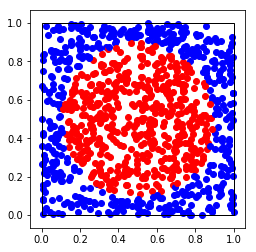

0.517


In [68]:
def disk(nb_points) :
    radius = 1/np.sqrt(2*np.pi)
    inp = Tensor(nb_points,2).uniform_(0,1)
    #ratio = torch.floor(torch.norm(inp,p=2,dim=1)/radius)
    #target = 1-torch.clamp(ratio,min=0,max=1)
    t = Tensor(nb_points,2)
    for i in range(nb_points):
        criteria = (inp[i,0]-0.5)**2+(inp[i,1]-0.5)**2
        if criteria > radius**2:
            t[i,:] = Tensor([0,1])
        elif criteria <= radius**2:
            t[i,:] = Tensor([1,0])    
    return inp, t

nb_points = 1000
# create train set and respective labels
train_input , train_target = disk(nb_points)
# create test set and respective labels
test_input , test_target = disk(nb_points)

fig = plt.figure()
ax= fig.add_subplot(111, aspect='equal')
ax.add_patch(
    patches.Rectangle(
        (0., 0.),
        1,
        1,
        fill=False      # remove background
    )
)
for i in range(nb_points):
    if train_target[i,0] == 0 :
        plt.scatter(train_input[i,0], train_input[i,1], s=None, c='b')
    elif train_target[i,0] == 1 :
        plt.scatter(train_input[i,0], train_input[i,1], s=None, c='r')
plt.show()
"""
target=torch.zeros(train_target.shape[0],2)-1
target[:,0][train_target==0]=1
target[:,1][train_target==1]=1
"""
#print(train_input, train_target, test_input, test_target)

# data normalization
# , std_train = train_input.mean() , train_input.std()
#train_input.sub_(mu_train).div_(std_train)
#mu_test , std_test = test_input.mean() , test_input.std()
#test_input.sub_(mu_test).div_(std_test)
# later see whether it is convenient to normalize component-wise with broadcasting (pag 66 week5)

# then do sanity check to see if the two classes are balanced
print(train_target[:,0].mean())


## Simple structure

In [29]:
class Module ( object ) :
    def forward ( self , * input ) :
        raise NotImplementedError
        
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
        
    def param ( self ) :
        return []

#### Activation functions

In [30]:
def tanh(x):
    return x.tanh()

def dtanh(x):
    return 1-torch.tanh(x).pow(2)

In [31]:
def relu(x):
    return max(0,x)

def drelu(x):
    if x>0:
        out = 1
    elif x<=0:
        out = 0
    return out

class Relu(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self,input):
        self.input = input
        return relu(input)
    
    def backward(self,output):
        return drelu(input)*output #to check, probably incorrect
    
    # here you need to add "def param" too

#### Loss functions

In [32]:
def loss(v, t):
    return (v - t).pow(2).sum()

def dloss(v, t):
    return 2 * (v - t)

## Linear Module

In [33]:
class Linear(Module):
    # in_features: size of each input sample
    # out_features: size of each output sample
    # bias: If set to False, the layer will not learn an additive bias. Default: ``True``

    # Attributes:
    # weight: the learnable weights of the module of shape (out_features x in_features)`
    # bias:   the learnable bias of the module of shape `(out_features)`

    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = Tensor(out_features,in_features).normal_(0,1e-1)
        self.bias = Tensor(out_features).zero_()
        self.dl_dw = Tensor(out_features,in_features).zero_()
        self.dl_db = Tensor(out_features).zero_()
                
    def forward(self,input):   # input sarebbe la x
        self.input = input
        self.s = torch.mv(self.weights,input)
        return self.s

    def backward(self, dl_ds):  
        dl_dx = self.weights.t().mv(dl_ds)   # the problem is here! 
        
        self.dl_dw.add_(dl_ds.view(-1, 1).mm(self.input.view(1, -1)))  
        self.dl_db.add_(dl_ds)
        return dl_dx     
    
    def update_param(self, eta):
        self.weights = self.weights - eta * self.dl_dw
        self.bias = self.bias - eta * self.dl_db
    
    def reset_param(self):
        self.dl_dw.zero_()
        self.dl_db.zero_()
        
    def param(self):
        return [(self.weights,self.dl_dw),(bias)]   # []

## Activation Module

In [34]:
class Sigma(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self,input):
        self.s = input
        return tanh(input)
    
    def backward(self, dl_dx):
        dl_ds = dtanh(self.s)*dl_dx
        return dl_ds
    
    def update_param(self, eta):
        pass 
    
    def reset_param(self):
        pass
        
        #return dtanh(input)*output    
        #return 4 * (output.exp() + output.mul(-1).exp()).pow(-2)

## Sequential Module

In [35]:
class Sequential(Module):
    def __init__(self, module_list):
        self.modules = module_list
        
    def forward(self, x):
        for module in module_list:
            x = module.forward(x)
            
        return x        
        
    def backward(self,dl_d):
        for module in reversed(module_list):
            dl_d = module.backward(dl_d)
    
    def update_param(self,eta):
        for module in module_list:
            module.update_param(eta)
    
    def reset_param(self):
        for module in module_list:
            module.reset_param()

## Loss Module

In [36]:
class Loss(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target):
        self.input = input
        self.target = target
        return loss(input, target)
    
    def backward(self):
        return dloss(self.input, self.target)

## Framework

### Training

### 1) Gradient descent

In [37]:
# Create my sequential list
# List of layers
input_size = 2
hidden_units = 25
output_size = 2

# three linear layers
fc1 = Linear(input_size,hidden_units)
fc2 = Linear(hidden_units,hidden_units)
fc3 = Linear(hidden_units,output_size)

# three activation layers
act1 = Sigma()
act2 = Sigma()
act3 = Sigma()

module_list = [fc1, act1, fc2, act2, fc3]

# framework
model = Sequential(module_list)
model_loss = Loss()

# training set
train_input = train_input
train_target = train_target

# training parameters
lr = 0.001
nb_epochs = 20

# testing set
test_input = test_input
test_target = test_target

for k in range(0, nb_epochs):

    # TRAINING
    acc_loss = 0   # accumulated loss
    nb_train_errors = 0
    nb_test_errors = 0
    
    # zero the derivatives
    model.reset_param()
    
    # forward pass for all training samples
    for n in range(train_input.size(0)):
        x = train_input[n]
        t = train_target[n]
        x = model.forward(x)
        print(x)
        
        # compute the error
        pred = x.max(0)[1][0]  # the result is the index (0 or 1) of the position where the max value is
        if x[0]>-0.5:
            pred=0
        targ = train_target[n,:].max(0)[1][0]
        if targ != pred:
            nb_train_errors = nb_train_errors + 1 
               
        #loss
        ### forward
        loss_sample = model_loss.forward(input = x, target = t)
        acc_loss += loss_sample
        ### backward
        grad_loss = model_loss.backward()
        
        # backward pass
        model.backward(grad_loss)  
        
        # TESTING
        x_test = test_input[n]
        t_test = test_target[n]
        x_test = model.forward(x_test)
        
        # compute the error
        pred_test = x_test.max(0)[1][0]  # the result is the index (0 or 1) of the position where the max value is
        if x_test[0]>-0.5:
            pred_test=0
        targ_test = test_target[n,:].max(0)[1][0]
        if targ_test != pred_test:
            nb_test_errors = nb_test_errors + 1 
        
        
    # update the derivatives
    model.update_param(eta=lr)   # gradient descent
    
    
        
    print('epoch {:d} acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'.format(k+1,acc_loss,
                                                                            (100 * nb_train_errors) / train_input.size(0), (100 * nb_test_errors) / test_input.size(0) ))


1.00000e-02 *
 -5.3868
  1.5029
[torch.FloatTensor of size 2]


1.00000e-02 *
 -3.2476
  1.0734
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.9484
  0.4132
[torch.FloatTensor of size 2]


1.00000e-02 *
 -3.9540
  1.2058
[torch.FloatTensor of size 2]


1.00000e-02 *
 -6.1617
  1.8337
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.8264
  1.8425
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.1638
  1.6280
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.4008
  1.7338
[torch.FloatTensor of size 2]


1.00000e-02 *
 -3.7612
  1.2606
[torch.FloatTensor of size 2]


1.00000e-02 *
 -4.5800
  1.5061
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.3711
  0.4113
[torch.FloatTensor of size 2]


1.00000e-02 *
 -4.6760
  1.5123
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.2542
  0.7200
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.6089
  1.7437
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.8980
  1.8859
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.2487
  0.4323
[torch.



1.00000e-02 *
 -4.9207
  1.4608
[torch.FloatTensor of size 2]


1.00000e-02 *
 -3.7919
  1.2789
[torch.FloatTensor of size 2]


1.00000e-02 *
 -3.4682
  1.0763
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.0435
  0.1382
[torch.FloatTensor of size 2]


1.00000e-03 *
 -9.8509
  3.2703
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.2738
  1.5393
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.3653
  0.1336
[torch.FloatTensor of size 2]


1.00000e-02 *
 -3.2423
  1.0519
[torch.FloatTensor of size 2]


1.00000e-03 *
 -5.3216
  0.3434
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.0470
  0.0217
[torch.FloatTensor of size 2]


1.00000e-02 *
 -3.1696
  0.9837
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.9761
  0.5233
[torch.FloatTensor of size 2]


1.00000e-03 *
 -8.9462
  0.1378
[torch.FloatTensor of size 2]


1.00000e-02 *
 -4.3718
  1.1863
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.3064
  1.6557
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.8890
  0.5576
[torch



1.00000e-02 *
 -4.4295
  1.5258
[torch.FloatTensor of size 2]


1.00000e-03 *
 -6.7999
  0.7995
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.3266
  1.8379
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.5805
  0.3200
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.1520
  1.7043
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.1478
  1.6953
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.0546
  1.5294
[torch.FloatTensor of size 2]


1.00000e-02 *
 -3.9083
  1.1852
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.9886
  1.0422
[torch.FloatTensor of size 2]


1.00000e-03 *
 -4.4192
  0.5861
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.7977
  0.8087
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.2890
  0.7094
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.3109
  0.4727
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.1028
  0.4743
[torch.FloatTensor of size 2]


1.00000e-02 *
 -3.8274
  1.1143
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.0685
  0.3323
[torch



1.00000e-02 *
 -4.7610
  1.5534
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.8302
  0.7739
[torch.FloatTensor of size 2]


1.00000e-02 *
 -4.6203
  1.5961
[torch.FloatTensor of size 2]


1.00000e-02 *
 -4.9770
  1.6513
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.1360
  1.5604
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.3188
  1.8116
[torch.FloatTensor of size 2]


1.00000e-03 *
 -8.9026
  2.5379
[torch.FloatTensor of size 2]


1.00000e-02 *
 -6.2107
  1.8091
[torch.FloatTensor of size 2]


1.00000e-02 *
 -4.4625
  1.3858
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.9407
  1.7082
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.6748
  0.8612
[torch.FloatTensor of size 2]


1.00000e-02 *
 -4.8058
  1.5490
[torch.FloatTensor of size 2]


1.00000e-02 *
 -4.8406
  1.4998
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.1543
  1.4050
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.8372
  0.4230
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.4656
  0.3292
[torch


1.00000e-02 *
 -2.1248
  0.3941
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.6361
  1.9173
[torch.FloatTensor of size 2]


1.00000e-02 *
 -4.6077
  1.3052
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.2295
  1.7877
[torch.FloatTensor of size 2]


1.00000e-02 *
 -4.0078
  1.2914
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.0215
  0.0776
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.6360
  0.2372
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.1295
  1.7476
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.7237
  0.2516
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.3284
  1.7129
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.4810
  1.6500
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.3043
  0.5505
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.8868
  0.6119
[torch.FloatTensor of size 2]


1.00000e-02 *
 -3.6099
  1.1410
[torch.FloatTensor of size 2]


1.00000e-02 *
 -4.3826
  1.3212
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.4976
  1.5472
[torch.



1.00000e-02 *
 -4.3305
  1.2895
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.5930
  1.8439
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.3968
  0.6789
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.5368
  1.6212
[torch.FloatTensor of size 2]


1.00000e-02 *
 -3.2129
  1.0953
[torch.FloatTensor of size 2]


1.00000e-02 *
 -4.5046
  1.4614
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.0920
  1.5397
[torch.FloatTensor of size 2]


1.00000e-02 *
 -6.1538
  1.7739
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.2483
  0.2381
[torch.FloatTensor of size 2]


1.00000e-02 *
 -3.3990
  1.0310
[torch.FloatTensor of size 2]


1.00000e-03 *
 -8.7731
 -0.0576
[torch.FloatTensor of size 2]


1.00000e-02 *
 -3.3168
  0.8919
[torch.FloatTensor of size 2]


1.00000e-03 *
 -8.4783
  0.7200
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.7124
  0.8722
[torch.FloatTensor of size 2]


1.00000e-02 *
 -5.6204
  1.6350
[torch.FloatTensor of size 2]


1.00000e-02 *
 -3.7960
  0.9841
[torch



-0.0790
 0.3000
[torch.FloatTensor of size 2]


-0.0772
 0.3111
[torch.FloatTensor of size 2]


-0.0157
 0.1241
[torch.FloatTensor of size 2]


-0.0230
 0.2028
[torch.FloatTensor of size 2]


-0.0419
 0.1240
[torch.FloatTensor of size 2]


-0.0711
 0.2952
[torch.FloatTensor of size 2]


-0.0409
 0.2151
[torch.FloatTensor of size 2]


-0.0709
 0.2051
[torch.FloatTensor of size 2]


-0.0427
 0.1081
[torch.FloatTensor of size 2]


-0.0347
 0.1837
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.7450
  5.9231
[torch.FloatTensor of size 2]


-0.0185
 0.1133
[torch.FloatTensor of size 2]


-0.0331
 0.1827
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.4393
  6.2136
[torch.FloatTensor of size 2]


-0.0347
 0.1587
[torch.FloatTensor of size 2]


-0.0464
 0.2590
[torch.FloatTensor of size 2]


-0.0299
 0.1067
[torch.FloatTensor of size 2]


-0.0760
 0.2597
[torch.FloatTensor of size 2]


-0.0574
 0.1751
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.0636
  6.7886
[torch.FloatTensor of 



-0.0572
 0.2457
[torch.FloatTensor of size 2]


-0.0620
 0.1786
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.2207
  8.8700
[torch.FloatTensor of size 2]


-0.0749
 0.3126
[torch.FloatTensor of size 2]


-0.0391
 0.1577
[torch.FloatTensor of size 2]


-0.0479
 0.2220
[torch.FloatTensor of size 2]


-0.0543
 0.2293
[torch.FloatTensor of size 2]


-0.0834
 0.3194
[torch.FloatTensor of size 2]


-0.0270
 0.1105
[torch.FloatTensor of size 2]


-0.0279
 0.1814
[torch.FloatTensor of size 2]


-0.0727
 0.3200
[torch.FloatTensor of size 2]


-0.0200
 0.1732
[torch.FloatTensor of size 2]


-0.0783
 0.2634
[torch.FloatTensor of size 2]


-0.0433
 0.1169
[torch.FloatTensor of size 2]


-0.0430
 0.2299
[torch.FloatTensor of size 2]


-0.0621
 0.1886
[torch.FloatTensor of size 2]


-0.0754
 0.2358
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.5422
  5.4713
[torch.FloatTensor of size 2]


-0.0343
 0.2028
[torch.FloatTensor of size 2]


-0.0365
 0.1610
[torch.FloatTensor of size 2]


-0.084



-0.0379
 0.2467
[torch.FloatTensor of size 2]


-0.0699
 0.3305
[torch.FloatTensor of size 2]


-0.0718
 0.1969
[torch.FloatTensor of size 2]


-0.0579
 0.2145
[torch.FloatTensor of size 2]


-0.0661
 0.3070
[torch.FloatTensor of size 2]


-0.0658
 0.2154
[torch.FloatTensor of size 2]


-0.0301
 0.1331
[torch.FloatTensor of size 2]


-0.0301
 0.2125
[torch.FloatTensor of size 2]


-0.0460
 0.1746
[torch.FloatTensor of size 2]


-0.0241
 0.1083
[torch.FloatTensor of size 2]


-0.0350
 0.1676
[torch.FloatTensor of size 2]


-0.0616
 0.3063
[torch.FloatTensor of size 2]


-0.0747
 0.2280
[torch.FloatTensor of size 2]


-0.0814
 0.3618
[torch.FloatTensor of size 2]


-0.0342
 0.1772
[torch.FloatTensor of size 2]


-0.0668
 0.1799
[torch.FloatTensor of size 2]


-0.0213
 0.1359
[torch.FloatTensor of size 2]


-0.0796
 0.2927
[torch.FloatTensor of size 2]


-0.0581
 0.1926
[torch.FloatTensor of size 2]


-0.0787
 0.3555
[torch.FloatTensor of size 2]


-0.0689
 0.3068
[torch.FloatTensor of 



-0.0644
 0.2234
[torch.FloatTensor of size 2]


-0.0577
 0.3007
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.7926
  8.3337
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.3328
  6.8550
[torch.FloatTensor of size 2]


-0.0678
 0.2510
[torch.FloatTensor of size 2]


-0.0204
 0.1607
[torch.FloatTensor of size 2]


-0.0549
 0.1651
[torch.FloatTensor of size 2]


-0.0587
 0.2316
[torch.FloatTensor of size 2]


-0.0663
 0.2526
[torch.FloatTensor of size 2]


-0.0637
 0.2747
[torch.FloatTensor of size 2]


-0.0706
 0.2205
[torch.FloatTensor of size 2]


-0.0329
 0.1246
[torch.FloatTensor of size 2]


-0.0606
 0.2140
[torch.FloatTensor of size 2]


-0.0435
 0.1494
[torch.FloatTensor of size 2]


-0.0167
 0.1451
[torch.FloatTensor of size 2]


-0.0343
 0.1363
[torch.FloatTensor of size 2]


-0.0328
 0.2330
[torch.FloatTensor of size 2]


-0.0449
 0.1654
[torch.FloatTensor of size 2]


-0.0314
 0.1370
[torch.FloatTensor of size 2]


-0.0726
 0.2434
[torch.FloatTensor of size 2]


-0.074



-0.0344
 0.6483
[torch.FloatTensor of size 2]


-0.0723
 0.9887
[torch.FloatTensor of size 2]


-0.0754
 0.8892
[torch.FloatTensor of size 2]


-0.0407
 0.6331
[torch.FloatTensor of size 2]


-0.0746
 1.2640
[torch.FloatTensor of size 2]


-0.0721
 0.8878
[torch.FloatTensor of size 2]


-0.0812
 1.1788
[torch.FloatTensor of size 2]


-0.0828
 1.4788
[torch.FloatTensor of size 2]


-0.0521
 0.9174
[torch.FloatTensor of size 2]


-0.0601
 0.8133
[torch.FloatTensor of size 2]


-0.0561
 1.1257
[torch.FloatTensor of size 2]


-0.0831
 1.2330
[torch.FloatTensor of size 2]


-0.0508
 0.7038
[torch.FloatTensor of size 2]


-0.0564
 0.9444
[torch.FloatTensor of size 2]


-0.0608
 1.0225
[torch.FloatTensor of size 2]


-0.0453
 0.5790
[torch.FloatTensor of size 2]


-0.0783
 1.2201
[torch.FloatTensor of size 2]


-0.0204
 0.3122
[torch.FloatTensor of size 2]


-0.0454
 0.9682
[torch.FloatTensor of size 2]


-0.0631
 0.6823
[torch.FloatTensor of size 2]


-0.0610
 0.7212
[torch.FloatTensor of 



-0.0503
 0.7969
[torch.FloatTensor of size 2]


-0.0472
 0.5154
[torch.FloatTensor of size 2]


-0.0743
 1.1441
[torch.FloatTensor of size 2]


-0.0497
 0.7825
[torch.FloatTensor of size 2]


-0.0629
 0.8422
[torch.FloatTensor of size 2]


-0.0354
 0.4406
[torch.FloatTensor of size 2]


-0.0713
 0.9271
[torch.FloatTensor of size 2]


-0.0489
 0.6376
[torch.FloatTensor of size 2]


-0.0278
 0.3499
[torch.FloatTensor of size 2]


-0.0565
 1.0176
[torch.FloatTensor of size 2]


-0.0514
 0.6842
[torch.FloatTensor of size 2]


-0.0802
 1.0025
[torch.FloatTensor of size 2]


-0.0544
 0.9040
[torch.FloatTensor of size 2]


-0.0313
 0.5853
[torch.FloatTensor of size 2]


-0.0675
 0.8385
[torch.FloatTensor of size 2]


-0.0845
 1.3554
[torch.FloatTensor of size 2]


-0.0279
 0.5760
[torch.FloatTensor of size 2]


-0.0765
 1.2870
[torch.FloatTensor of size 2]


-0.0835
 1.3681
[torch.FloatTensor of size 2]


-0.0686
 1.2355
[torch.FloatTensor of size 2]


-0.0419
 0.7551
[torch.FloatTensor of 



-0.0289
 0.5608
[torch.FloatTensor of size 2]


-0.0746
 1.3529
[torch.FloatTensor of size 2]


-0.0375
 0.7921
[torch.FloatTensor of size 2]


-0.0697
 0.8636
[torch.FloatTensor of size 2]


-0.0508
 0.7377
[torch.FloatTensor of size 2]


-0.0779
 1.4684
[torch.FloatTensor of size 2]


-0.0262
 0.4785
[torch.FloatTensor of size 2]


-0.0822
 1.4916
[torch.FloatTensor of size 2]


-0.0564
 0.9122
[torch.FloatTensor of size 2]


-0.0550
 0.6524
[torch.FloatTensor of size 2]


-0.0507
 0.5749
[torch.FloatTensor of size 2]


-0.0792
 1.3295
[torch.FloatTensor of size 2]


-0.0278
 0.4031
[torch.FloatTensor of size 2]


-0.0445
 0.5110
[torch.FloatTensor of size 2]


-0.0820
 1.0529
[torch.FloatTensor of size 2]


-0.0669
 1.0365
[torch.FloatTensor of size 2]


-0.0361
 0.4835
[torch.FloatTensor of size 2]


-0.0762
 0.9497
[torch.FloatTensor of size 2]


-0.0465
 0.5556
[torch.FloatTensor of size 2]


-0.0272
 0.6057
[torch.FloatTensor of size 2]


-0.0496
 0.8181
[torch.FloatTensor of 


 0.0572
 0.3865
[torch.FloatTensor of size 2]


 0.1281
 0.9463
[torch.FloatTensor of size 2]


 0.1426
 0.9631
[torch.FloatTensor of size 2]


 0.0842
 0.6635
[torch.FloatTensor of size 2]


 0.0645
 0.3966
[torch.FloatTensor of size 2]


 0.1194
 0.8972
[torch.FloatTensor of size 2]


 0.1087
 0.7576
[torch.FloatTensor of size 2]


 0.1207
 0.8201
[torch.FloatTensor of size 2]


 0.1068
 0.7001
[torch.FloatTensor of size 2]


 0.1341
 0.9242
[torch.FloatTensor of size 2]


 0.0862
 0.6222
[torch.FloatTensor of size 2]


 0.1527
 1.0543
[torch.FloatTensor of size 2]


 0.1342
 0.9947
[torch.FloatTensor of size 2]


 0.0973
 0.5837
[torch.FloatTensor of size 2]


 0.0610
 0.4629
[torch.FloatTensor of size 2]


 0.1210
 0.8258
[torch.FloatTensor of size 2]


 0.0624
 0.4719
[torch.FloatTensor of size 2]


 0.0626
 0.4920
[torch.FloatTensor of size 2]


 0.1057
 0.7846
[torch.FloatTensor of size 2]


 0.0442
 0.3133
[torch.FloatTensor of size 2]


 0.0626
 0.4570
[torch.FloatTensor of s



 0.1217
 0.8049
[torch.FloatTensor of size 2]


 0.0532
 0.4621
[torch.FloatTensor of size 2]


 0.0503
 0.4900
[torch.FloatTensor of size 2]


 0.0423
 0.3689
[torch.FloatTensor of size 2]


 0.0563
 0.5571
[torch.FloatTensor of size 2]


 0.1261
 0.9465
[torch.FloatTensor of size 2]


 0.1008
 0.7772
[torch.FloatTensor of size 2]


 0.0999
 0.8106
[torch.FloatTensor of size 2]


 0.0890
 0.6727
[torch.FloatTensor of size 2]


 0.0927
 0.7042
[torch.FloatTensor of size 2]


 0.0421
 0.2850
[torch.FloatTensor of size 2]


 0.1544
 1.0879
[torch.FloatTensor of size 2]


 0.1194
 0.7715
[torch.FloatTensor of size 2]


 0.0376
 0.3787
[torch.FloatTensor of size 2]


 0.0894
 0.7330
[torch.FloatTensor of size 2]


 0.0251
 0.2594
[torch.FloatTensor of size 2]


 0.1169
 0.8468
[torch.FloatTensor of size 2]


 0.0642
 0.4113
[torch.FloatTensor of size 2]


 0.1223
 0.9293
[torch.FloatTensor of size 2]


 0.1228
 0.8011
[torch.FloatTensor of size 2]


 0.0179
 0.1555
[torch.FloatTensor of 


 0.0931
 0.5771
[torch.FloatTensor of size 2]


 0.1534
 1.0559
[torch.FloatTensor of size 2]


 0.0985
 0.5947
[torch.FloatTensor of size 2]


 0.0453
 0.2700
[torch.FloatTensor of size 2]


 0.0894
 0.6982
[torch.FloatTensor of size 2]


 0.1125
 0.7462
[torch.FloatTensor of size 2]


 0.0282
 0.2133
[torch.FloatTensor of size 2]


 0.1386
 0.9690
[torch.FloatTensor of size 2]


 0.0601
 0.5694
[torch.FloatTensor of size 2]


 0.1011
 0.8336
[torch.FloatTensor of size 2]


 0.1118
 0.8698
[torch.FloatTensor of size 2]


 0.0239
 0.2355
[torch.FloatTensor of size 2]


 0.1341
 0.9776
[torch.FloatTensor of size 2]


 0.0373
 0.3508
[torch.FloatTensor of size 2]


 0.1363
 0.9967
[torch.FloatTensor of size 2]


 0.0344
 0.3438
[torch.FloatTensor of size 2]


 0.1197
 0.8194
[torch.FloatTensor of size 2]


 0.0209
 0.1901
[torch.FloatTensor of size 2]


 0.0520
 0.5249
[torch.FloatTensor of size 2]


 0.1163
 0.7322
[torch.FloatTensor of size 2]


 0.0780
 0.7185
[torch.FloatTensor of s



 0.0843
 0.6069
[torch.FloatTensor of size 2]


 0.1024
 0.6543
[torch.FloatTensor of size 2]


 0.0301
 0.3027
[torch.FloatTensor of size 2]


 0.1253
 0.8358
[torch.FloatTensor of size 2]


 0.0504
 0.4457
[torch.FloatTensor of size 2]


 0.1069
 0.8118
[torch.FloatTensor of size 2]


 0.1261
 0.9175
[torch.FloatTensor of size 2]


 0.0831
 0.5054
[torch.FloatTensor of size 2]


 0.0565
 0.5512
[torch.FloatTensor of size 2]


 0.0887
 0.6930
[torch.FloatTensor of size 2]


 0.0504
 0.3222
[torch.FloatTensor of size 2]


 0.1177
 0.7240
[torch.FloatTensor of size 2]


 0.0593
 0.5427
[torch.FloatTensor of size 2]

epoch 4 acc_train_loss 235.66 acc_train_error 88.20% test_error 87.60%

 0.0819
 1.9712
[torch.FloatTensor of size 2]


 0.0153
 0.9477
[torch.FloatTensor of size 2]


 0.0432
 1.1963
[torch.FloatTensor of size 2]


 0.0384
 1.3769
[torch.FloatTensor of size 2]


 0.0790
 1.9911
[torch.FloatTensor of size 2]


 0.0543
 1.7327
[torch.FloatTensor of size 2]


 0.0463
 1.5924



 0.0303
 0.8714
[torch.FloatTensor of size 2]


 0.0658
 1.7118
[torch.FloatTensor of size 2]


 0.0104
 0.6973
[torch.FloatTensor of size 2]


 0.0504
 1.2706
[torch.FloatTensor of size 2]


 0.0079
 0.2907
[torch.FloatTensor of size 2]


 0.0295
 0.9077
[torch.FloatTensor of size 2]


 0.0608
 1.7976
[torch.FloatTensor of size 2]


 0.0177
 0.7480
[torch.FloatTensor of size 2]


 0.0214
 1.2017
[torch.FloatTensor of size 2]


 0.0279
 1.2864
[torch.FloatTensor of size 2]


 0.0243
 0.7456
[torch.FloatTensor of size 2]


 0.0268
 0.9576
[torch.FloatTensor of size 2]


 0.0042
 0.4614
[torch.FloatTensor of size 2]


 0.0404
 1.5388
[torch.FloatTensor of size 2]


 0.0465
 1.3746
[torch.FloatTensor of size 2]


 0.0541
 1.4403
[torch.FloatTensor of size 2]


 0.0130
 0.7911
[torch.FloatTensor of size 2]


 0.0633
 1.5610
[torch.FloatTensor of size 2]


 0.0183
 0.7491
[torch.FloatTensor of size 2]


 0.0695
 1.7393
[torch.FloatTensor of size 2]


 0.0342
 1.0451
[torch.FloatTensor of 



 0.0271
 0.6888
[torch.FloatTensor of size 2]


 0.0448
 1.4584
[torch.FloatTensor of size 2]


 0.0507
 1.3351
[torch.FloatTensor of size 2]


 0.0441
 1.4512
[torch.FloatTensor of size 2]


 0.0730
 1.8024
[torch.FloatTensor of size 2]


 0.0773
 1.9741
[torch.FloatTensor of size 2]


 0.0315
 1.1046
[torch.FloatTensor of size 2]


 0.0062
 0.7346
[torch.FloatTensor of size 2]


 0.0477
 1.5626
[torch.FloatTensor of size 2]


 0.0306
 1.0855
[torch.FloatTensor of size 2]


 0.0253
 1.1735
[torch.FloatTensor of size 2]


 0.0095
 0.6246
[torch.FloatTensor of size 2]


 0.0270
 1.2888
[torch.FloatTensor of size 2]


 0.0167
 0.8967
[torch.FloatTensor of size 2]


 0.0076
 0.4967
[torch.FloatTensor of size 2]


 0.0490
 1.3906
[torch.FloatTensor of size 2]


 0.0192
 0.9597
[torch.FloatTensor of size 2]


 0.0276
 1.3910
[torch.FloatTensor of size 2]


 0.0389
 1.2452
[torch.FloatTensor of size 2]


 0.0272
 0.8121
[torch.FloatTensor of size 2]


 0.0210
 1.1728
[torch.FloatTensor of 



 0.0061
 0.6506
[torch.FloatTensor of size 2]


 0.0766
 1.9072
[torch.FloatTensor of size 2]


 0.0084
 0.9379
[torch.FloatTensor of size 2]


 0.0284
 1.0074
[torch.FloatTensor of size 2]


 0.0334
 1.4352
[torch.FloatTensor of size 2]


 0.0114
 0.9341
[torch.FloatTensor of size 2]


 0.0765
 1.8635
[torch.FloatTensor of size 2]


 0.0279
 1.1028
[torch.FloatTensor of size 2]


 0.0480
 1.3435
[torch.FloatTensor of size 2]


 0.0567
 1.6460
[torch.FloatTensor of size 2]


 0.0278
 1.3333
[torch.FloatTensor of size 2]


 0.0340
 1.1857
[torch.FloatTensor of size 2]


 0.0263
 0.6765
[torch.FloatTensor of size 2]


 0.0239
 1.2909
[torch.FloatTensor of size 2]


 0.0549
 1.5747
[torch.FloatTensor of size 2]


 0.0128
 1.1412
[torch.FloatTensor of size 2]


 0.0465
 1.1781
[torch.FloatTensor of size 2]


 0.0269
 0.7776
[torch.FloatTensor of size 2]


 0.0706
 1.8169
[torch.FloatTensor of size 2]


 0.0421
 1.0871
[torch.FloatTensor of size 2]


 0.0217
 1.2066
[torch.FloatTensor of 



1.00000e-02 *
 -1.1157
  8.0914
[torch.FloatTensor of size 2]


-0.0185
 0.1087
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.2555
  4.9102
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.0227
  8.4334
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.1167
  4.2772
[torch.FloatTensor of size 2]


-0.0152
 0.1083
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.1995
  6.8250
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.1009
  6.8467
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.3016
  9.0688
[torch.FloatTensor of size 2]


1.00000e-02 *
  0.6410
  3.9315
[torch.FloatTensor of size 2]


1.00000e-02 *
  0.0305
  3.0315
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.1115
  5.9923
[torch.FloatTensor of size 2]


1.00000e-02 *
  0.9516
  6.0443
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.7844
  7.0307
[torch.FloatTensor of size 2]


1.00000e-02 *
  0.1696
  6.0435
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.4011
  9.1331
[torch.FloatTensor of size 2]


1.0000



1.00000e-02 *
 -2.1053
  5.4511
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.3834
  1.6914
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.6269
  3.6787
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.0379
  7.0031
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.3814
  7.6238
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.1027
  6.5519
[torch.FloatTensor of size 2]


1.00000e-02 *
  0.1898
  4.2439
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.8998
  9.3985
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.1599
  3.6063
[torch.FloatTensor of size 2]


1.00000e-02 *
  0.4550
  6.3768
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.0686
  1.4030
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.0445
  4.4778
[torch.FloatTensor of size 2]


-0.0246
 0.1032
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.6212
  3.7615
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.3817
  6.5348
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.1865
  6.9836
[torch.FloatTensor of 



1.00000e-02 *
 -0.1817
  1.7640
[torch.FloatTensor of size 2]


1.00000e-02 *
  0.0901
  5.3554
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.8139
  5.2395
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.9735
  9.3983
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.7566
  9.4496
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.8409
  8.0105
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.1907
  9.0364
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.0664
  1.9521
[torch.FloatTensor of size 2]


1.00000e-02 *
  0.6418
  7.2564
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.6524
  7.5986
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.6311
  7.9132
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.6571
  9.4227
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.4236
  6.9034
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.3689
  8.0977
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.5759
  4.8193
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.2573
  5.2455
[torch



1.00000e-02 *
  0.0990
  3.9538
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.2551
  6.3458
[torch.FloatTensor of size 2]


-0.0247
 0.1053
[torch.FloatTensor of size 2]


1.00000e-02 *
  0.3805
  3.8220
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.7124
  9.7504
[torch.FloatTensor of size 2]


-0.0234
 0.1061
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.9662
  9.1309
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.1042
  5.2119
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.0773
  8.3194
[torch.FloatTensor of size 2]


1.00000e-02 *
  0.9372
  6.5210
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.0977
  2.0221
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.4547
  9.9889
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.3999
  9.2539
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.7503
  9.3027
[torch.FloatTensor of size 2]


1.00000e-03 *
  0.5181
  4.5259
[torch.FloatTensor of size 2]


-0.0236
 0.1103
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.9521



-0.0260
 0.1011
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.4911
  6.6313
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.0078
  9.4497
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.4066
  9.8957
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.2799
  3.7921
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.9991
  6.9329
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.7665
  4.2768
[torch.FloatTensor of size 2]


-0.0259
 0.1039
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.6697
  8.3716
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.7844
  7.1029
[torch.FloatTensor of size 2]


-0.0177
 0.1128
[torch.FloatTensor of size 2]


-0.0218
 0.1144
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.5995
  6.8587
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.3385
  9.1383
[torch.FloatTensor of size 2]


1.00000e-02 *
 -1.4702
  7.6860
[torch.FloatTensor of size 2]


-0.0112
 0.1014
[torch.FloatTensor of size 2]


1.00000e-02 *
 -2.3283
  8.8978
[torch.FloatTensor of 



-0.0214
 0.3456
[torch.FloatTensor of size 2]


-0.0239
 0.3434
[torch.FloatTensor of size 2]


-0.0203
 0.2154
[torch.FloatTensor of size 2]


-0.0228
 0.2760
[torch.FloatTensor of size 2]


-0.0054
 0.1107
[torch.FloatTensor of size 2]


-0.0218
 0.2957
[torch.FloatTensor of size 2]


-0.0107
 0.1533
[torch.FloatTensor of size 2]


-0.0214
 0.3832
[torch.FloatTensor of size 2]


-0.0252
 0.3745
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.7572
  6.4390
[torch.FloatTensor of size 2]


-0.0022
 0.2951
[torch.FloatTensor of size 2]


-0.0144
 0.4056
[torch.FloatTensor of size 2]


-0.0076
 0.3074
[torch.FloatTensor of size 2]


-0.0047
 0.3341
[torch.FloatTensor of size 2]


-0.0311
 0.2700
[torch.FloatTensor of size 2]


-0.0026
 0.2293
[torch.FloatTensor of size 2]


-0.0206
 0.4003
[torch.FloatTensor of size 2]


-0.0174
 0.4094
[torch.FloatTensor of size 2]


 0.0042
 0.1559
[torch.FloatTensor of size 2]


 0.0096
 0.2488
[torch.FloatTensor of size 2]


-0.0171
 0.1825
[torch



-0.0178
 0.1884
[torch.FloatTensor of size 2]


-0.0079
 0.3054
[torch.FloatTensor of size 2]


 0.0039
 0.3234
[torch.FloatTensor of size 2]


-0.0259
 0.2259
[torch.FloatTensor of size 2]


 0.0030
 0.1323
[torch.FloatTensor of size 2]


-0.0310
 0.2654
[torch.FloatTensor of size 2]


 0.0010
 0.2176
[torch.FloatTensor of size 2]


-0.0258
 0.3015
[torch.FloatTensor of size 2]


-0.0254
 0.3056
[torch.FloatTensor of size 2]


-0.0176
 0.3708
[torch.FloatTensor of size 2]


-0.0146
 0.2943
[torch.FloatTensor of size 2]


-0.0183
 0.1472
[torch.FloatTensor of size 2]


1.00000e-02 *
  0.1635
  8.2703
[torch.FloatTensor of size 2]


-0.0090
 0.2383
[torch.FloatTensor of size 2]


-0.0098
 0.1689
[torch.FloatTensor of size 2]


 0.0015
 0.3026
[torch.FloatTensor of size 2]


-0.0007
 0.2564
[torch.FloatTensor of size 2]


-0.0120
 0.3129
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.4741
  7.9105
[torch.FloatTensor of size 2]


-0.0054
 0.1767
[torch.FloatTensor of size 2]


-0.018



-0.0012
 0.2187
[torch.FloatTensor of size 2]


-0.0194
 0.3256
[torch.FloatTensor of size 2]


 0.0092
 0.2804
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.1194
  8.5413
[torch.FloatTensor of size 2]


-0.0220
 0.3855
[torch.FloatTensor of size 2]


-0.0025
 0.3750
[torch.FloatTensor of size 2]


-0.0254
 0.3575
[torch.FloatTensor of size 2]


1.00000e-02 *
  0.0451
  1.9811
[torch.FloatTensor of size 2]


-0.0201
 0.4242
[torch.FloatTensor of size 2]


-0.0276
 0.3450
[torch.FloatTensor of size 2]


-0.0028
 0.2326
[torch.FloatTensor of size 2]


 0.0000
 0.1740
[torch.FloatTensor of size 2]


-0.0182
 0.3872
[torch.FloatTensor of size 2]


 0.0082
 0.2419
[torch.FloatTensor of size 2]


-0.0216
 0.2315
[torch.FloatTensor of size 2]


-0.0186
 0.3086
[torch.FloatTensor of size 2]


-0.0150
 0.3026
[torch.FloatTensor of size 2]


-0.0113
 0.2848
[torch.FloatTensor of size 2]


-0.0115
 0.4586
[torch.FloatTensor of size 2]


-0.0278
 0.2345
[torch.FloatTensor of size 2]


-0.009


-0.0080
 0.2861
[torch.FloatTensor of size 2]


-0.0233
 0.3888
[torch.FloatTensor of size 2]


-0.0145
 0.2642
[torch.FloatTensor of size 2]


-0.0180
 0.3691
[torch.FloatTensor of size 2]


-0.0118
 0.3906
[torch.FloatTensor of size 2]


-0.0030
 0.1584
[torch.FloatTensor of size 2]


-0.0292
 0.2635
[torch.FloatTensor of size 2]


-0.0078
 0.1744
[torch.FloatTensor of size 2]


-0.0229
 0.3992
[torch.FloatTensor of size 2]


-0.0057
 0.3393
[torch.FloatTensor of size 2]


-0.0270
 0.2721
[torch.FloatTensor of size 2]


-0.0141
 0.4377
[torch.FloatTensor of size 2]


-0.0179
 0.4402
[torch.FloatTensor of size 2]


-0.0154
 0.2724
[torch.FloatTensor of size 2]


-0.0117
 0.3629
[torch.FloatTensor of size 2]


-0.0138
 0.3061
[torch.FloatTensor of size 2]


-0.0088
 0.4021
[torch.FloatTensor of size 2]


-0.0215
 0.3457
[torch.FloatTensor of size 2]


 0.0039
 0.3183
[torch.FloatTensor of size 2]


-0.0104
 0.4087
[torch.FloatTensor of size 2]


-0.0001
 0.3337
[torch.FloatTensor of s



 0.0310
 1.0795
[torch.FloatTensor of size 2]


 0.0314
 1.2109
[torch.FloatTensor of size 2]


 0.0519
 1.3727
[torch.FloatTensor of size 2]


 0.0013
 0.4745
[torch.FloatTensor of size 2]


 0.0322
 1.2914
[torch.FloatTensor of size 2]


 0.0366
 0.9276
[torch.FloatTensor of size 2]


 0.0446
 1.1646
[torch.FloatTensor of size 2]


 0.0455
 1.3025
[torch.FloatTensor of size 2]


 0.0326
 1.3176
[torch.FloatTensor of size 2]


 0.0521
 1.4740
[torch.FloatTensor of size 2]


 0.0434
 1.1558
[torch.FloatTensor of size 2]


 0.0373
 1.3068
[torch.FloatTensor of size 2]


 0.0289
 1.1681
[torch.FloatTensor of size 2]


 0.0480
 1.2202
[torch.FloatTensor of size 2]


 0.0608
 1.5154
[torch.FloatTensor of size 2]


 0.0479
 1.2311
[torch.FloatTensor of size 2]


 0.0314
 1.1743
[torch.FloatTensor of size 2]


 0.0179
 0.7348
[torch.FloatTensor of size 2]


 0.0042
 0.4966
[torch.FloatTensor of size 2]


 0.0204
 0.9557
[torch.FloatTensor of size 2]


 0.0313
 1.1426
[torch.FloatTensor of 



 0.0344
 1.2057
[torch.FloatTensor of size 2]


 0.0103
 1.0157
[torch.FloatTensor of size 2]


 0.0076
 0.5110
[torch.FloatTensor of size 2]


 0.0485
 1.4219
[torch.FloatTensor of size 2]


 0.0166
 0.8588
[torch.FloatTensor of size 2]


 0.0316
 1.1069
[torch.FloatTensor of size 2]


 0.0306
 1.1491
[torch.FloatTensor of size 2]


 0.0472
 1.4561
[torch.FloatTensor of size 2]


 0.0105
 0.6242
[torch.FloatTensor of size 2]


 0.0301
 0.9010
[torch.FloatTensor of size 2]


 0.0520
 1.4335
[torch.FloatTensor of size 2]


 0.0324
 0.8412
[torch.FloatTensor of size 2]


 0.0303
 1.3115
[torch.FloatTensor of size 2]


 0.0022
 0.7204
[torch.FloatTensor of size 2]


 0.0366
 1.1154
[torch.FloatTensor of size 2]


 0.0134
 1.0484
[torch.FloatTensor of size 2]


 0.0222
 1.2304
[torch.FloatTensor of size 2]


 0.0032
 0.3291
[torch.FloatTensor of size 2]


 0.0329
 0.9987
[torch.FloatTensor of size 2]


 0.0191
 0.8604
[torch.FloatTensor of size 2]


 0.0598
 1.5378
[torch.FloatTensor of 



 0.0101
 0.9985
[torch.FloatTensor of size 2]


 0.0167
 1.0052
[torch.FloatTensor of size 2]


 0.0184
 1.1120
[torch.FloatTensor of size 2]


 0.0273
 1.0186
[torch.FloatTensor of size 2]


 0.0037
 0.9202
[torch.FloatTensor of size 2]


 0.0156
 1.1022
[torch.FloatTensor of size 2]


 0.0385
 1.3330
[torch.FloatTensor of size 2]


 0.0100
 1.0738
[torch.FloatTensor of size 2]


 0.0056
 0.3378
[torch.FloatTensor of size 2]


 0.0611
 1.5555
[torch.FloatTensor of size 2]


 0.0268
 1.1738
[torch.FloatTensor of size 2]


 0.0606
 1.5397
[torch.FloatTensor of size 2]


 0.0082
 0.7197
[torch.FloatTensor of size 2]


 0.0216
 1.1505
[torch.FloatTensor of size 2]


 0.0310
 1.2455
[torch.FloatTensor of size 2]


 0.0603
 1.4987
[torch.FloatTensor of size 2]


 0.0256
 0.8736
[torch.FloatTensor of size 2]


 0.0206
 0.7400
[torch.FloatTensor of size 2]


 0.0035
 0.5285
[torch.FloatTensor of size 2]


 0.0162
 1.0331
[torch.FloatTensor of size 2]


 0.0119
 0.9168
[torch.FloatTensor of 



 0.0024
 0.6163
[torch.FloatTensor of size 2]


 0.0174
 1.1697
[torch.FloatTensor of size 2]


 0.0286
 1.1438
[torch.FloatTensor of size 2]


 0.0072
 0.5783
[torch.FloatTensor of size 2]


 0.0131
 1.0748
[torch.FloatTensor of size 2]


 0.0044
 0.6650
[torch.FloatTensor of size 2]


 0.0247
 0.6974
[torch.FloatTensor of size 2]


 0.0239
 0.9300
[torch.FloatTensor of size 2]


 0.0341
 1.1532
[torch.FloatTensor of size 2]


 0.0015
 0.6305
[torch.FloatTensor of size 2]


 0.0324
 1.1475
[torch.FloatTensor of size 2]


 0.0345
 0.9811
[torch.FloatTensor of size 2]


 0.0093
 0.6127
[torch.FloatTensor of size 2]


 0.0044
 0.8663
[torch.FloatTensor of size 2]


 0.0448
 1.1423
[torch.FloatTensor of size 2]


 0.0080
 0.4011
[torch.FloatTensor of size 2]


 0.0009
 0.1744
[torch.FloatTensor of size 2]


 0.0024
 0.8385
[torch.FloatTensor of size 2]


 0.0440
 1.0317
[torch.FloatTensor of size 2]


 0.0189
 0.6001
[torch.FloatTensor of size 2]


 0.0048
 0.6571
[torch.FloatTensor of 


 0.0371
 0.6702
[torch.FloatTensor of size 2]


 0.0355
 0.5754
[torch.FloatTensor of size 2]


 0.0309
 0.4731
[torch.FloatTensor of size 2]


 0.0161
 0.6404
[torch.FloatTensor of size 2]


 0.0320
 0.5121
[torch.FloatTensor of size 2]


 0.0345
 0.6205
[torch.FloatTensor of size 2]


 0.0334
 0.7042
[torch.FloatTensor of size 2]


 0.0521
 0.8081
[torch.FloatTensor of size 2]


 0.0049
 0.2644
[torch.FloatTensor of size 2]


 0.0329
 0.7566
[torch.FloatTensor of size 2]


 0.0408
 0.5263
[torch.FloatTensor of size 2]


 0.0477
 0.6729
[torch.FloatTensor of size 2]


 0.0467
 0.7622
[torch.FloatTensor of size 2]


 0.0328
 0.7740
[torch.FloatTensor of size 2]


 0.0495
 0.8769
[torch.FloatTensor of size 2]


 0.0465
 0.6674
[torch.FloatTensor of size 2]


 0.0380
 0.7662
[torch.FloatTensor of size 2]


 0.0315
 0.6769
[torch.FloatTensor of size 2]


 0.0506
 0.7082
[torch.FloatTensor of size 2]


 0.0578
 0.9042
[torch.FloatTensor of size 2]


 0.0503
 0.7153
[torch.FloatTensor of s



 0.0499
 0.6896
[torch.FloatTensor of size 2]


 0.0081
 0.5124
[torch.FloatTensor of size 2]


 0.0208
 0.3006
[torch.FloatTensor of size 2]


 0.0097
 0.5927
[torch.FloatTensor of size 2]


 0.0312
 0.4846
[torch.FloatTensor of size 2]


 0.0201
 0.6594
[torch.FloatTensor of size 2]


 0.0211
 0.6668
[torch.FloatTensor of size 2]


 0.0388
 0.7798
[torch.FloatTensor of size 2]


 0.0289
 0.6421
[torch.FloatTensor of size 2]


 0.0034
 0.3433
[torch.FloatTensor of size 2]


 0.0127
 0.1897
[torch.FloatTensor of size 2]


 0.0252
 0.5310
[torch.FloatTensor of size 2]


 0.0142
 0.3865
[torch.FloatTensor of size 2]


 0.0446
 0.6520
[torch.FloatTensor of size 2]


 0.0354
 0.5637
[torch.FloatTensor of size 2]


 0.0342
 0.6757
[torch.FloatTensor of size 2]


 0.0063
 0.1846
[torch.FloatTensor of size 2]


 0.0194
 0.4012
[torch.FloatTensor of size 2]


 0.0256
 0.6454
[torch.FloatTensor of size 2]


 0.0121
 0.3088
[torch.FloatTensor of size 2]


 0.0499
 0.6656
[torch.FloatTensor of 



 0.0078
 0.5307
[torch.FloatTensor of size 2]


 0.0290
 0.5812
[torch.FloatTensor of size 2]


 0.0297
 0.6294
[torch.FloatTensor of size 2]


 0.0498
 0.6981
[torch.FloatTensor of size 2]


 0.0237
 0.6714
[torch.FloatTensor of size 2]


 0.0492
 0.7864
[torch.FloatTensor of size 2]


 0.0466
 0.8191
[torch.FloatTensor of size 2]


 0.0203
 0.2901
[torch.FloatTensor of size 2]


 0.0086
 0.4138
[torch.FloatTensor of size 2]


 0.0115
 0.2984
[torch.FloatTensor of size 2]


 0.0086
 0.4919
[torch.FloatTensor of size 2]


 0.0108
 0.5085
[torch.FloatTensor of size 2]


 0.0187
 0.2767
[torch.FloatTensor of size 2]


 0.0053
 0.3770
[torch.FloatTensor of size 2]


 0.0107
 0.5029
[torch.FloatTensor of size 2]


 0.0104
 0.2916
[torch.FloatTensor of size 2]


 0.0436
 0.7404
[torch.FloatTensor of size 2]


 0.0234
 0.7216
[torch.FloatTensor of size 2]


 0.0089
 0.2274
[torch.FloatTensor of size 2]


 0.0240
 0.3662
[torch.FloatTensor of size 2]


 0.0234
 0.5238
[torch.FloatTensor of 



 0.0228
 0.3346
[torch.FloatTensor of size 2]


 0.0091
 0.3688
[torch.FloatTensor of size 2]


 0.0236
 0.6550
[torch.FloatTensor of size 2]


 0.0570
 0.8739
[torch.FloatTensor of size 2]


 0.0539
 0.8405
[torch.FloatTensor of size 2]


 0.0196
 0.6665
[torch.FloatTensor of size 2]


 0.0209
 0.5231
[torch.FloatTensor of size 2]


 0.0528
 0.8337
[torch.FloatTensor of size 2]


 0.0212
 0.7016
[torch.FloatTensor of size 2]


 0.0327
 0.4822
[torch.FloatTensor of size 2]


 0.0454
 0.6055
[torch.FloatTensor of size 2]


 0.0485
 0.8835
[torch.FloatTensor of size 2]


 0.0425
 0.8114
[torch.FloatTensor of size 2]


 0.0113
 0.4443
[torch.FloatTensor of size 2]


 0.0261
 0.3654
[torch.FloatTensor of size 2]


 0.0176
 0.4071
[torch.FloatTensor of size 2]


 0.0525
 0.8256
[torch.FloatTensor of size 2]


 0.0448
 0.6601
[torch.FloatTensor of size 2]


 0.0143
 0.6472
[torch.FloatTensor of size 2]


 0.0252
 0.6550
[torch.FloatTensor of size 2]


 0.0428
 0.6820
[torch.FloatTensor of 



 0.0292
 0.4920
[torch.FloatTensor of size 2]


 0.1248
 1.7115
[torch.FloatTensor of size 2]


 0.0278
 0.5889
[torch.FloatTensor of size 2]


 0.1033
 1.6147
[torch.FloatTensor of size 2]


 0.0446
 0.9911
[torch.FloatTensor of size 2]


 0.0774
 1.3818
[torch.FloatTensor of size 2]


 0.1268
 1.7512
[torch.FloatTensor of size 2]


 0.1297
 1.7574
[torch.FloatTensor of size 2]


 0.0716
 1.3896
[torch.FloatTensor of size 2]


 0.0754
 1.4340
[torch.FloatTensor of size 2]


 0.0466
 0.9053
[torch.FloatTensor of size 2]


 0.0976
 1.5172
[torch.FloatTensor of size 2]


 0.1018
 1.5224
[torch.FloatTensor of size 2]


 0.0591
 1.2375
[torch.FloatTensor of size 2]


 0.0955
 1.4215
[torch.FloatTensor of size 2]


 0.0872
 1.2566
[torch.FloatTensor of size 2]


 0.1062
 1.5282
[torch.FloatTensor of size 2]


 0.0985
 1.4253
[torch.FloatTensor of size 2]


 0.0389
 0.7791
[torch.FloatTensor of size 2]


 0.0693
 1.3846
[torch.FloatTensor of size 2]


 0.1289
 1.7563
[torch.FloatTensor of 



 0.0469
 0.7484
[torch.FloatTensor of size 2]


 0.0705
 1.1832
[torch.FloatTensor of size 2]


 0.0255
 0.5468
[torch.FloatTensor of size 2]


 0.0973
 1.5343
[torch.FloatTensor of size 2]


 0.0966
 1.5637
[torch.FloatTensor of size 2]


 0.1175
 1.6615
[torch.FloatTensor of size 2]


 0.0362
 0.6570
[torch.FloatTensor of size 2]


 0.1203
 1.6644
[torch.FloatTensor of size 2]


 0.1038
 1.5056
[torch.FloatTensor of size 2]


 0.0542
 1.2397
[torch.FloatTensor of size 2]


 0.0752
 1.1650
[torch.FloatTensor of size 2]


 0.0246
 0.6381
[torch.FloatTensor of size 2]


 0.0443
 0.9756
[torch.FloatTensor of size 2]


 0.0887
 1.5070
[torch.FloatTensor of size 2]


 0.0424
 0.9213
[torch.FloatTensor of size 2]


 0.0292
 0.6742
[torch.FloatTensor of size 2]


 0.0719
 1.2083
[torch.FloatTensor of size 2]


 0.0371
 0.6007
[torch.FloatTensor of size 2]


 0.0733
 1.3511
[torch.FloatTensor of size 2]


 0.1066
 1.6413
[torch.FloatTensor of size 2]


 0.0624
 1.1187
[torch.FloatTensor of 


 0.0288
 0.7547
[torch.FloatTensor of size 2]


 0.0996
 1.4903
[torch.FloatTensor of size 2]


 0.0170
 0.4291
[torch.FloatTensor of size 2]


 0.0449
 1.0884
[torch.FloatTensor of size 2]


 0.0952
 1.3724
[torch.FloatTensor of size 2]


 0.0681
 1.3773
[torch.FloatTensor of size 2]


 0.1120
 1.6210
[torch.FloatTensor of size 2]


 0.0608
 1.2952
[torch.FloatTensor of size 2]


 0.0648
 1.2452
[torch.FloatTensor of size 2]


 0.0709
 1.0665
[torch.FloatTensor of size 2]


 0.0878
 1.2775
[torch.FloatTensor of size 2]


 0.0611
 1.2908
[torch.FloatTensor of size 2]


 0.0918
 1.3179
[torch.FloatTensor of size 2]


 0.0879
 1.5014
[torch.FloatTensor of size 2]


 0.1134
 1.6664
[torch.FloatTensor of size 2]


 0.0785
 1.2430
[torch.FloatTensor of size 2]


 0.0285
 0.6599
[torch.FloatTensor of size 2]


 0.0632
 1.2019
[torch.FloatTensor of size 2]


 0.0911
 1.4736
[torch.FloatTensor of size 2]


 0.1327
 1.7711
[torch.FloatTensor of size 2]


 0.0732
 1.4061
[torch.FloatTensor of s



 0.0905
 1.4871
[torch.FloatTensor of size 2]


 0.1065
 1.6079
[torch.FloatTensor of size 2]


 0.0668
 1.0245
[torch.FloatTensor of size 2]


 0.0487
 1.1303
[torch.FloatTensor of size 2]


 0.0748
 1.3326
[torch.FloatTensor of size 2]


 0.0401
 0.6904
[torch.FloatTensor of size 2]


 0.0960
 1.3597
[torch.FloatTensor of size 2]


 0.0505
 1.1129
[torch.FloatTensor of size 2]

epoch 10 acc_train_loss 320.13 acc_train_error 88.20% test_error 87.60%

-0.0365
 0.3872
[torch.FloatTensor of size 2]


-0.0277
 0.1917
[torch.FloatTensor of size 2]


-0.0155
 0.2362
[torch.FloatTensor of size 2]


-0.0317
 0.2752
[torch.FloatTensor of size 2]


-0.0426
 0.3923
[torch.FloatTensor of size 2]


-0.0440
 0.3455
[torch.FloatTensor of size 2]


-0.0401
 0.3183
[torch.FloatTensor of size 2]


-0.0422
 0.3173
[torch.FloatTensor of size 2]


-0.0318
 0.2097
[torch.FloatTensor of size 2]


-0.0375
 0.2627
[torch.FloatTensor of size 2]


-0.0121
 0.1085
[torch.FloatTensor of size 2]


-0.0378
 0.278



-0.0372
 0.2871
[torch.FloatTensor of size 2]


-0.0092
 0.2392
[torch.FloatTensor of size 2]


-0.0174
 0.2030
[torch.FloatTensor of size 2]


-0.0429
 0.3460
[torch.FloatTensor of size 2]


-0.0396
 0.2403
[torch.FloatTensor of size 2]


-0.0221
 0.2773
[torch.FloatTensor of size 2]


-0.0280
 0.1847
[torch.FloatTensor of size 2]


-0.0260
 0.2824
[torch.FloatTensor of size 2]


-0.0164
 0.2936
[torch.FloatTensor of size 2]


-0.0374
 0.2207
[torch.FloatTensor of size 2]


-0.0060
 0.1260
[torch.FloatTensor of size 2]


-0.0442
 0.2564
[torch.FloatTensor of size 2]


-0.0130
 0.2049
[torch.FloatTensor of size 2]


-0.0416
 0.2847
[torch.FloatTensor of size 2]


-0.0415
 0.2878
[torch.FloatTensor of size 2]


-0.0380
 0.3364
[torch.FloatTensor of size 2]


-0.0313
 0.2754
[torch.FloatTensor of size 2]


-0.0259
 0.1472
[torch.FloatTensor of size 2]


1.00000e-02 *
 -0.4025
  7.9395
[torch.FloatTensor of size 2]


-0.0231
 0.2262
[torch.FloatTensor of size 2]


-0.0197
 0.1643
[torch



-0.0417
 0.4036
[torch.FloatTensor of size 2]


-0.0353
 0.2928
[torch.FloatTensor of size 2]


-0.0400
 0.3985
[torch.FloatTensor of size 2]


-0.0230
 0.1727
[torch.FloatTensor of size 2]


-0.0385
 0.2872
[torch.FloatTensor of size 2]


-0.0376
 0.3132
[torch.FloatTensor of size 2]


-0.0347
 0.3852
[torch.FloatTensor of size 2]


-0.0152
 0.2095
[torch.FloatTensor of size 2]


-0.0125
 0.1755
[torch.FloatTensor of size 2]


-0.0179
 0.1256
[torch.FloatTensor of size 2]


-0.0346
 0.2549
[torch.FloatTensor of size 2]


-0.0309
 0.2238
[torch.FloatTensor of size 2]


-0.0435
 0.3732
[torch.FloatTensor of size 2]


-0.0082
 0.2218
[torch.FloatTensor of size 2]


-0.0133
 0.1615
[torch.FloatTensor of size 2]


-0.0331
 0.3017
[torch.FloatTensor of size 2]


-0.0135
 0.1404
[torch.FloatTensor of size 2]


-0.0142
 0.2624
[torch.FloatTensor of size 2]


-0.0222
 0.1861
[torch.FloatTensor of size 2]


-0.0194
 0.1476
[torch.FloatTensor of size 2]


-0.0436
 0.2537
[torch.FloatTensor of 



-0.0409
 0.2846
[torch.FloatTensor of size 2]


1.00000e-03 *
 -0.3126
  2.1788
[torch.FloatTensor of size 2]


-0.0186
 0.2801
[torch.FloatTensor of size 2]


-0.0432
 0.2819
[torch.FloatTensor of size 2]


-0.0225
 0.2988
[torch.FloatTensor of size 2]


-0.0326
 0.2199
[torch.FloatTensor of size 2]


-0.0129
 0.2773
[torch.FloatTensor of size 2]


-0.0244
 0.2617
[torch.FloatTensor of size 2]


-0.0430
 0.2501
[torch.FloatTensor of size 2]


-0.0335
 0.3078
[torch.FloatTensor of size 2]


-0.0444
 0.3063
[torch.FloatTensor of size 2]


-0.0201
 0.2043
[torch.FloatTensor of size 2]


-0.0391
 0.3741
[torch.FloatTensor of size 2]


-0.0276
 0.1716
[torch.FloatTensor of size 2]


-0.0367
 0.2683
[torch.FloatTensor of size 2]


-0.0382
 0.3385
[torch.FloatTensor of size 2]


-0.0410
 0.4057
[torch.FloatTensor of size 2]


-0.0106
 0.1736
[torch.FloatTensor of size 2]


-0.0279
 0.2452
[torch.FloatTensor of size 2]


-0.0068
 0.2128
[torch.FloatTensor of size 2]


-0.0256
 0.2883
[torch



 0.0290
 1.0986
[torch.FloatTensor of size 2]


 0.0192
 0.5874
[torch.FloatTensor of size 2]


 0.0355
 1.1376
[torch.FloatTensor of size 2]


 0.0454
 1.1435
[torch.FloatTensor of size 2]


 0.0223
 0.9160
[torch.FloatTensor of size 2]


 0.0239
 0.5953
[torch.FloatTensor of size 2]


 0.0325
 1.1058
[torch.FloatTensor of size 2]


 0.0344
 0.9940
[torch.FloatTensor of size 2]


 0.0391
 1.0433
[torch.FloatTensor of size 2]


 0.0367
 0.9392
[torch.FloatTensor of size 2]


 0.0418
 1.1193
[torch.FloatTensor of size 2]


 0.0264
 0.8697
[torch.FloatTensor of size 2]


 0.0458
 1.1986
[torch.FloatTensor of size 2]


 0.0362
 1.1679
[torch.FloatTensor of size 2]


 0.0369
 0.8172
[torch.FloatTensor of size 2]


 0.0175
 0.6923
[torch.FloatTensor of size 2]


 0.0390
 1.0480
[torch.FloatTensor of size 2]


 0.0180
 0.7032
[torch.FloatTensor of size 2]


 0.0170
 0.7298
[torch.FloatTensor of size 2]


 0.0303
 1.0203
[torch.FloatTensor of size 2]


 0.0140
 0.4886
[torch.FloatTensor of 


 0.0499
 1.2200
[torch.FloatTensor of size 2]


 0.0124
 0.9094
[torch.FloatTensor of size 2]


 0.0356
 0.7802
[torch.FloatTensor of size 2]


 0.0298
 1.0905
[torch.FloatTensor of size 2]


 0.0344
 0.9165
[torch.FloatTensor of size 2]


 0.0224
 0.8668
[torch.FloatTensor of size 2]


 0.0478
 1.1277
[torch.FloatTensor of size 2]


 0.0411
 1.1956
[torch.FloatTensor of size 2]


 0.0078
 0.2889
[torch.FloatTensor of size 2]


 0.0299
 0.7864
[torch.FloatTensor of size 2]


 0.0122
 0.7443
[torch.FloatTensor of size 2]


 0.0342
 1.1013
[torch.FloatTensor of size 2]


 0.0276
 1.0974
[torch.FloatTensor of size 2]


 0.0276
 1.0074
[torch.FloatTensor of size 2]


 0.0390
 1.0858
[torch.FloatTensor of size 2]


 0.0098
 0.3214
[torch.FloatTensor of size 2]


 0.0452
 0.9757
[torch.FloatTensor of size 2]


 0.0270
 0.9771
[torch.FloatTensor of size 2]


 0.0377
 1.0131
[torch.FloatTensor of size 2]


 0.0457
 1.1146
[torch.FloatTensor of size 2]


 0.0162
 0.9079
[torch.FloatTensor of s



 0.0113
 0.8498
[torch.FloatTensor of size 2]


 0.0254
 0.7127
[torch.FloatTensor of size 2]


 0.0115
 0.6111
[torch.FloatTensor of size 2]


 0.0058
 0.5647
[torch.FloatTensor of size 2]


 0.0421
 0.8983
[torch.FloatTensor of size 2]


 0.0499
 1.2261
[torch.FloatTensor of size 2]


 0.0135
 0.5158
[torch.FloatTensor of size 2]


 0.0217
 0.5929
[torch.FloatTensor of size 2]


 0.0210
 0.5326
[torch.FloatTensor of size 2]


 0.0431
 1.0947
[torch.FloatTensor of size 2]


 0.0311
 0.7995
[torch.FloatTensor of size 2]


 0.0289
 0.9622
[torch.FloatTensor of size 2]


 0.0017
 0.1855
[torch.FloatTensor of size 2]


 0.0098
 0.8557
[torch.FloatTensor of size 2]


 0.0455
 1.2071
[torch.FloatTensor of size 2]


 0.0213
 0.7177
[torch.FloatTensor of size 2]


 0.0165
 0.5359
[torch.FloatTensor of size 2]


 0.0342
 0.8124
[torch.FloatTensor of size 2]


 0.0462
 1.1993
[torch.FloatTensor of size 2]


 0.0371
 0.8294
[torch.FloatTensor of size 2]


 0.0172
 0.4179
[torch.FloatTensor of 


 0.0469
 1.1061
[torch.FloatTensor of size 2]


 0.0458
 1.1695
[torch.FloatTensor of size 2]


 0.0418
 1.0037
[torch.FloatTensor of size 2]


 0.0418
 1.1279
[torch.FloatTensor of size 2]


 0.0406
 1.1219
[torch.FloatTensor of size 2]


 0.0095
 0.2653
[torch.FloatTensor of size 2]


 0.0336
 0.9204
[torch.FloatTensor of size 2]


 0.0094
 0.4612
[torch.FloatTensor of size 2]


 0.0486
 1.1975
[torch.FloatTensor of size 2]


 0.0154
 0.8469
[torch.FloatTensor of size 2]


 0.0090
 0.5602
[torch.FloatTensor of size 2]


 0.0465
 1.0741
[torch.FloatTensor of size 2]


 0.0050
 0.4666
[torch.FloatTensor of size 2]


 0.0205
 0.7241
[torch.FloatTensor of size 2]


 0.0462
 1.1880
[torch.FloatTensor of size 2]


 0.0175
 0.8241
[torch.FloatTensor of size 2]


 0.0223
 1.0171
[torch.FloatTensor of size 2]


 0.0350
 0.8218
[torch.FloatTensor of size 2]


 0.0284
 1.0145
[torch.FloatTensor of size 2]


 0.0406
 1.0415
[torch.FloatTensor of size 2]


 0.0210
 0.6593
[torch.FloatTensor of s


 0.0749
 1.1405
[torch.FloatTensor of size 2]


 0.0374
 0.7957
[torch.FloatTensor of size 2]


 0.0506
 0.8903
[torch.FloatTensor of size 2]


 0.0505
 0.7064
[torch.FloatTensor of size 2]


 0.0116
 0.2522
[torch.FloatTensor of size 2]


 0.0815
 1.1898
[torch.FloatTensor of size 2]


 0.0702
 0.9138
[torch.FloatTensor of size 2]


 0.0402
 0.7797
[torch.FloatTensor of size 2]


 0.0339
 0.4775
[torch.FloatTensor of size 2]


 0.0688
 0.8796
[torch.FloatTensor of size 2]


 0.0470
 0.8373
[torch.FloatTensor of size 2]


 0.0467
 0.7437
[torch.FloatTensor of size 2]


 0.0612
 0.7998
[torch.FloatTensor of size 2]


 0.0826
 1.1599
[torch.FloatTensor of size 2]


 0.0687
 1.1220
[torch.FloatTensor of size 2]


 0.0348
 0.6134
[torch.FloatTensor of size 2]


 0.0417
 0.8085
[torch.FloatTensor of size 2]


 0.0393
 0.6109
[torch.FloatTensor of size 2]


 0.0869
 1.2145
[torch.FloatTensor of size 2]


 0.0414
 0.6024
[torch.FloatTensor of size 2]


 0.0879
 1.1855
[torch.FloatTensor of s


 0.0680
 1.0765
[torch.FloatTensor of size 2]


 0.0337
 0.6646
[torch.FloatTensor of size 2]


 0.0851
 1.2211
[torch.FloatTensor of size 2]


 0.0603
 0.8296
[torch.FloatTensor of size 2]


 0.0658
 0.9508
[torch.FloatTensor of size 2]


 0.0114
 0.1995
[torch.FloatTensor of size 2]


 0.0316
 0.6621
[torch.FloatTensor of size 2]


 0.0329
 0.7488
[torch.FloatTensor of size 2]


 0.0669
 1.0358
[torch.FloatTensor of size 2]


 0.0452
 0.7947
[torch.FloatTensor of size 2]


 0.0397
 0.7199
[torch.FloatTensor of size 2]


 0.0696
 0.9575
[torch.FloatTensor of size 2]


 0.0419
 0.8423
[torch.FloatTensor of size 2]


 0.0912
 1.2412
[torch.FloatTensor of size 2]


 0.0824
 1.1735
[torch.FloatTensor of size 2]


 0.0611
 0.8164
[torch.FloatTensor of size 2]


 0.0783
 1.0972
[torch.FloatTensor of size 2]


 0.0135
 0.2655
[torch.FloatTensor of size 2]


 0.0683
 1.1374
[torch.FloatTensor of size 2]


 0.0725
 0.9508
[torch.FloatTensor of size 2]


 0.0103
 0.2554
[torch.FloatTensor of s



 0.0262
 0.4051
[torch.FloatTensor of size 2]


 0.0704
 1.0233
[torch.FloatTensor of size 2]


 0.0334
 0.6612
[torch.FloatTensor of size 2]


 0.0359
 0.7948
[torch.FloatTensor of size 2]


 0.0308
 0.5318
[torch.FloatTensor of size 2]


 0.0386
 0.7457
[torch.FloatTensor of size 2]


 0.0909
 1.2349
[torch.FloatTensor of size 2]


 0.0080
 0.1380
[torch.FloatTensor of size 2]


 0.0431
 0.6460
[torch.FloatTensor of size 2]


 0.0255
 0.4675
[torch.FloatTensor of size 2]


 0.0746
 1.1411
[torch.FloatTensor of size 2]


 0.0773
 1.1468
[torch.FloatTensor of size 2]


 0.0383
 0.7130
[torch.FloatTensor of size 2]


 0.0413
 0.7016
[torch.FloatTensor of size 2]


 0.0540
 0.8558
[torch.FloatTensor of size 2]


 0.0709
 0.9168
[torch.FloatTensor of size 2]


 0.0457
 0.8215
[torch.FloatTensor of size 2]


 0.0134
 0.2566
[torch.FloatTensor of size 2]


 0.0787
 1.0806
[torch.FloatTensor of size 2]


 0.0544
 0.9275
[torch.FloatTensor of size 2]


 0.0883
 1.2310
[torch.FloatTensor of 



 0.0373
 0.8396
[torch.FloatTensor of size 2]


 0.0562
 0.9732
[torch.FloatTensor of size 2]


 0.0347
 0.5184
[torch.FloatTensor of size 2]


 0.0756
 0.9862
[torch.FloatTensor of size 2]


 0.0393
 0.8267
[torch.FloatTensor of size 2]

epoch 13 acc_train_loss 168.85 acc_train_error 88.20% test_error 87.60%

 0.0663
 1.1848
[torch.FloatTensor of size 2]


 0.0250
 0.7234
[torch.FloatTensor of size 2]


 0.0473
 0.8565
[torch.FloatTensor of size 2]


 0.0426
 0.9565
[torch.FloatTensor of size 2]


 0.0622
 1.1923
[torch.FloatTensor of size 2]


 0.0492
 1.1086
[torch.FloatTensor of size 2]


 0.0459
 1.0539
[torch.FloatTensor of size 2]


 0.0438
 1.0515
[torch.FloatTensor of size 2]


 0.0258
 0.7783
[torch.FloatTensor of size 2]


 0.0342
 0.9246
[torch.FloatTensor of size 2]


 0.0176
 0.4353
[torch.FloatTensor of size 2]


 0.0380
 0.9643
[torch.FloatTensor of size 2]


 0.0217
 0.5867
[torch.FloatTensor of size 2]


 0.0512
 1.1110
[torch.FloatTensor of size 2]


 0.0473
 1.100



 0.0685
 1.2258
[torch.FloatTensor of size 2]


 0.0530
 1.0608
[torch.FloatTensor of size 2]


 0.0245
 0.7421
[torch.FloatTensor of size 2]


 0.0577
 0.9703
[torch.FloatTensor of size 2]


 0.0585
 1.0409
[torch.FloatTensor of size 2]


 0.0392
 0.6874
[torch.FloatTensor of size 2]


 0.0261
 0.5735
[torch.FloatTensor of size 2]


 0.0524
 1.0310
[torch.FloatTensor of size 2]


 0.0679
 1.1839
[torch.FloatTensor of size 2]


 0.0478
 1.0949
[torch.FloatTensor of size 2]


 0.0608
 1.1040
[torch.FloatTensor of size 2]


 0.0400
 0.8022
[torch.FloatTensor of size 2]


 0.0253
 0.6106
[torch.FloatTensor of size 2]


 0.0607
 0.9887
[torch.FloatTensor of size 2]


 0.0502
 1.0934
[torch.FloatTensor of size 2]


 0.0163
 0.2999
[torch.FloatTensor of size 2]


 0.0625
 1.1305
[torch.FloatTensor of size 2]


 0.0425
 0.7405
[torch.FloatTensor of size 2]


 0.0330
 0.6836
[torch.FloatTensor of size 2]


 0.0167
 0.3876
[torch.FloatTensor of size 2]


 0.0344
 0.7783
[torch.FloatTensor of 


 0.0630
 1.1830
[torch.FloatTensor of size 2]


 0.0673
 1.1664
[torch.FloatTensor of size 2]


 0.0442
 0.9434
[torch.FloatTensor of size 2]


 0.0500
 1.1125
[torch.FloatTensor of size 2]


 0.0407
 0.9719
[torch.FloatTensor of size 2]


 0.0229
 0.6894
[torch.FloatTensor of size 2]


 0.0563
 1.0454
[torch.FloatTensor of size 2]


 0.0480
 0.8692
[torch.FloatTensor of size 2]


 0.0426
 1.0538
[torch.FloatTensor of size 2]


 0.0159
 0.4369
[torch.FloatTensor of size 2]


 0.0312
 0.5343
[torch.FloatTensor of size 2]


 0.0470
 0.9932
[torch.FloatTensor of size 2]


 0.0531
 0.9282
[torch.FloatTensor of size 2]


 0.0465
 0.9900
[torch.FloatTensor of size 2]


 0.0646
 1.1279
[torch.FloatTensor of size 2]


 0.0614
 1.1873
[torch.FloatTensor of size 2]


 0.0380
 0.8101
[torch.FloatTensor of size 2]


 0.0164
 0.5846
[torch.FloatTensor of size 2]


 0.0478
 1.0399
[torch.FloatTensor of size 2]


 0.0373
 0.7992
[torch.FloatTensor of size 2]


 0.0332
 0.8547
[torch.FloatTensor of s


 0.0166
 0.4130
[torch.FloatTensor of size 2]


 0.0198
 0.3931
[torch.FloatTensor of size 2]


 0.0525
 0.9870
[torch.FloatTensor of size 2]


 0.0231
 0.6407
[torch.FloatTensor of size 2]


 0.0234
 0.7692
[torch.FloatTensor of size 2]


 0.0225
 0.5158
[torch.FloatTensor of size 2]


 0.0267
 0.7220
[torch.FloatTensor of size 2]


 0.0672
 1.1859
[torch.FloatTensor of size 2]


 0.0059
 0.1341
[torch.FloatTensor of size 2]


 0.0327
 0.6259
[torch.FloatTensor of size 2]


 0.0182
 0.4536
[torch.FloatTensor of size 2]


 0.0539
 1.0983
[torch.FloatTensor of size 2]


 0.0564
 1.1036
[torch.FloatTensor of size 2]


 0.0270
 0.6906
[torch.FloatTensor of size 2]


 0.0300
 0.6796
[torch.FloatTensor of size 2]


 0.0399
 0.8274
[torch.FloatTensor of size 2]


 0.0551
 0.8856
[torch.FloatTensor of size 2]


 0.0324
 0.7948
[torch.FloatTensor of size 2]


 0.0095
 0.2493
[torch.FloatTensor of size 2]


 0.0593
 1.0412
[torch.FloatTensor of size 2]


 0.0389
 0.8960
[torch.FloatTensor of s



 0.0240
 0.7989
[torch.FloatTensor of size 2]


 0.0618
 1.0198
[torch.FloatTensor of size 2]


 0.0470
 0.9318
[torch.FloatTensor of size 2]


 0.0598
 1.1187
[torch.FloatTensor of size 2]


 0.0258
 0.8390
[torch.FloatTensor of size 2]


 0.0598
 1.1722
[torch.FloatTensor of size 2]


 0.0425
 0.7665
[torch.FloatTensor of size 2]


 0.0461
 1.0635
[torch.FloatTensor of size 2]


 0.0550
 1.0137
[torch.FloatTensor of size 2]


 0.0598
 1.1728
[torch.FloatTensor of size 2]


 0.0488
 1.0025
[torch.FloatTensor of size 2]


 0.0201
 0.7031
[torch.FloatTensor of size 2]


 0.0056
 0.1748
[torch.FloatTensor of size 2]


 0.0174
 0.5609
[torch.FloatTensor of size 2]


 0.0295
 0.7975
[torch.FloatTensor of size 2]


 0.0154
 0.4998
[torch.FloatTensor of size 2]


 0.0540
 1.1180
[torch.FloatTensor of size 2]


 0.0200
 0.6122
[torch.FloatTensor of size 2]


 0.0659
 1.1378
[torch.FloatTensor of size 2]


 0.0460
 0.9825
[torch.FloatTensor of size 2]


 0.0145
 0.3444
[torch.FloatTensor of 



 0.0782
 1.2074
[torch.FloatTensor of size 2]


 0.0395
 0.6192
[torch.FloatTensor of size 2]


 0.0796
 1.1811
[torch.FloatTensor of size 2]


 0.0752
 1.1025
[torch.FloatTensor of size 2]


 0.0732
 1.1935
[torch.FloatTensor of size 2]


 0.0599
 1.1109
[torch.FloatTensor of size 2]


 0.0655
 1.0072
[torch.FloatTensor of size 2]


 0.0770
 1.1994
[torch.FloatTensor of size 2]


 0.0798
 1.2450
[torch.FloatTensor of size 2]


 0.0716
 1.0717
[torch.FloatTensor of size 2]


 0.0689
 1.1453
[torch.FloatTensor of size 2]


 0.0420
 0.7086
[torch.FloatTensor of size 2]


 0.0437
 0.9024
[torch.FloatTensor of size 2]


 0.0538
 0.9440
[torch.FloatTensor of size 2]


 0.0651
 1.0939
[torch.FloatTensor of size 2]


 0.0074
 0.1259
[torch.FloatTensor of size 2]


 0.0798
 1.2072
[torch.FloatTensor of size 2]


 0.0477
 0.9113
[torch.FloatTensor of size 2]


 0.0732
 1.1876
[torch.FloatTensor of size 2]


 0.0770
 1.1307
[torch.FloatTensor of size 2]


 0.0765
 1.1428
[torch.FloatTensor of 



 0.0269
 0.5540
[torch.FloatTensor of size 2]


 0.0560
 1.0153
[torch.FloatTensor of size 2]


 0.0629
 0.9064
[torch.FloatTensor of size 2]


 0.0699
 1.1367
[torch.FloatTensor of size 2]


 0.0612
 1.1263
[torch.FloatTensor of size 2]


 0.0518
 0.9651
[torch.FloatTensor of size 2]


 0.0613
 1.0231
[torch.FloatTensor of size 2]


 0.0668
 1.1436
[torch.FloatTensor of size 2]


 0.0261
 0.4874
[torch.FloatTensor of size 2]


 0.0598
 0.9505
[torch.FloatTensor of size 2]


 0.0572
 1.0825
[torch.FloatTensor of size 2]


 0.0787
 1.1824
[torch.FloatTensor of size 2]


 0.0489
 0.9999
[torch.FloatTensor of size 2]


 0.0709
 1.0277
[torch.FloatTensor of size 2]


 0.0774
 1.2228
[torch.FloatTensor of size 2]


 0.0814
 1.2068
[torch.FloatTensor of size 2]


 0.0566
 0.9873
[torch.FloatTensor of size 2]


 0.0642
 1.1544
[torch.FloatTensor of size 2]


 0.0536
 1.0159
[torch.FloatTensor of size 2]


 0.0325
 0.7289
[torch.FloatTensor of size 2]


 0.0694
 1.0886
[torch.FloatTensor of 



 0.0430
 0.9630
[torch.FloatTensor of size 2]


 0.0781
 1.2180
[torch.FloatTensor of size 2]


 0.0758
 1.2219
[torch.FloatTensor of size 2]


 0.0510
 0.9555
[torch.FloatTensor of size 2]


 0.0690
 1.1197
[torch.FloatTensor of size 2]


 0.0581
 1.0236
[torch.FloatTensor of size 2]


 0.0768
 1.1736
[torch.FloatTensor of size 2]


 0.0594
 1.0973
[torch.FloatTensor of size 2]


 0.0726
 1.0365
[torch.FloatTensor of size 2]


 0.0767
 1.1826
[torch.FloatTensor of size 2]


 0.0723
 1.0665
[torch.FloatTensor of size 2]


 0.0488
 0.9676
[torch.FloatTensor of size 2]


 0.0422
 0.6240
[torch.FloatTensor of size 2]


 0.0615
 1.0787
[torch.FloatTensor of size 2]


 0.0790
 1.2237
[torch.FloatTensor of size 2]


 0.0228
 0.5557
[torch.FloatTensor of size 2]


 0.0782
 1.2052
[torch.FloatTensor of size 2]


 0.0299
 0.7630
[torch.FloatTensor of size 2]


 0.0453
 0.7935
[torch.FloatTensor of size 2]


 0.0509
 1.0322
[torch.FloatTensor of size 2]


 0.0320
 0.7579
[torch.FloatTensor of 



 0.0502
 0.9862
[torch.FloatTensor of size 2]


 0.0653
 1.0117
[torch.FloatTensor of size 2]


 0.0696
 1.1657
[torch.FloatTensor of size 2]


 0.0651
 1.0184
[torch.FloatTensor of size 2]


 0.0521
 0.9892
[torch.FloatTensor of size 2]


 0.0366
 0.6755
[torch.FloatTensor of size 2]


 0.0201
 0.4761
[torch.FloatTensor of size 2]


 0.0425
 0.8460
[torch.FloatTensor of size 2]


 0.0521
 0.9692
[torch.FloatTensor of size 2]


 0.0255
 0.4657
[torch.FloatTensor of size 2]


 0.0452
 0.7170
[torch.FloatTensor of size 2]


 0.0433
 0.6840
[torch.FloatTensor of size 2]


 0.0276
 0.7862
[torch.FloatTensor of size 2]


1.00000e-02 *
  0.2221
  5.1516
[torch.FloatTensor of size 2]


 0.0519
 1.0572
[torch.FloatTensor of size 2]


 0.0380
 0.6353
[torch.FloatTensor of size 2]


 0.0552
 1.0039
[torch.FloatTensor of size 2]


 0.0640
 1.1390
[torch.FloatTensor of size 2]


 0.0247
 0.7088
[torch.FloatTensor of size 2]


 0.0579
 1.0260
[torch.FloatTensor of size 2]


 0.0291
 0.6500
[torch



 0.0447
 0.8013
[torch.FloatTensor of size 2]


 0.0220
 0.6385
[torch.FloatTensor of size 2]


 0.0615
 1.0963
[torch.FloatTensor of size 2]


 0.0468
 0.9196
[torch.FloatTensor of size 2]


 0.0190
 0.3216
[torch.FloatTensor of size 2]


 0.0528
 0.8717
[torch.FloatTensor of size 2]


 0.0434
 0.9425
[torch.FloatTensor of size 2]


 0.0587
 0.9760
[torch.FloatTensor of size 2]


 0.0468
 1.0455
[torch.FloatTensor of size 2]


 0.0194
 0.3502
[torch.FloatTensor of size 2]


 0.0612
 1.0455
[torch.FloatTensor of size 2]


 0.0406
 0.9523
[torch.FloatTensor of size 2]


 0.0570
 1.0364
[torch.FloatTensor of size 2]


 0.0594
 1.1045
[torch.FloatTensor of size 2]


 0.0505
 1.0267
[torch.FloatTensor of size 2]


 0.0257
 0.7306
[torch.FloatTensor of size 2]


 0.0602
 1.1379
[torch.FloatTensor of size 2]


 0.0232
 0.5509
[torch.FloatTensor of size 2]


 0.0698
 1.1687
[torch.FloatTensor of size 2]


 0.0342
 0.9055
[torch.FloatTensor of size 2]


 0.0521
 0.7853
[torch.FloatTensor of 



 0.0659
 1.1106
[torch.FloatTensor of size 2]


 0.0169
 0.4568
[torch.FloatTensor of size 2]


 0.0196
 0.3850
[torch.FloatTensor of size 2]


 0.0580
 1.0659
[torch.FloatTensor of size 2]


 0.0596
 1.0066
[torch.FloatTensor of size 2]


 0.0278
 0.5411
[torch.FloatTensor of size 2]


 0.0674
 1.1275
[torch.FloatTensor of size 2]


 0.0149
 0.2613
[torch.FloatTensor of size 2]


 0.0242
 0.6409
[torch.FloatTensor of size 2]


 0.0218
 0.4639
[torch.FloatTensor of size 2]


 0.0649
 1.1015
[torch.FloatTensor of size 2]


 0.0232
 0.6476
[torch.FloatTensor of size 2]


 0.0270
 0.7601
[torch.FloatTensor of size 2]


 0.0457
 0.9651
[torch.FloatTensor of size 2]


 0.0213
 0.4322
[torch.FloatTensor of size 2]


 0.0194
 0.3809
[torch.FloatTensor of size 2]


 0.0593
 1.0601
[torch.FloatTensor of size 2]


 0.0602
 1.0035
[torch.FloatTensor of size 2]


 0.0599
 0.9229
[torch.FloatTensor of size 2]


 0.0574
 1.1053
[torch.FloatTensor of size 2]


 0.0211
 0.3818
[torch.FloatTensor of 



 0.0517
 0.8466
[torch.FloatTensor of size 2]


 0.0421
 0.9960
[torch.FloatTensor of size 2]


 0.0449
 0.8870
[torch.FloatTensor of size 2]


 0.0519
 0.8251
[torch.FloatTensor of size 2]


 0.0614
 0.9683
[torch.FloatTensor of size 2]


 0.0317
 0.8039
[torch.FloatTensor of size 2]


 0.0612
 1.1435
[torch.FloatTensor of size 2]


 0.0380
 0.8323
[torch.FloatTensor of size 2]


 0.0295
 0.8014
[torch.FloatTensor of size 2]


 0.0655
 1.0106
[torch.FloatTensor of size 2]


 0.0515
 0.9282
[torch.FloatTensor of size 2]


 0.0632
 1.1014
[torch.FloatTensor of size 2]


 0.0314
 0.8400
[torch.FloatTensor of size 2]


 0.0628
 1.1496
[torch.FloatTensor of size 2]


 0.0466
 0.7697
[torch.FloatTensor of size 2]


 0.0506
 1.0512
[torch.FloatTensor of size 2]


 0.0590
 1.0049
[torch.FloatTensor of size 2]


 0.0628
 1.1501
[torch.FloatTensor of size 2]


 0.0532
 0.9946
[torch.FloatTensor of size 2]


 0.0252
 0.7082
[torch.FloatTensor of size 2]


 0.0070
 0.1783
[torch.FloatTensor of 



 0.0184
 0.4171
[torch.FloatTensor of size 2]


 0.0557
 1.0801
[torch.FloatTensor of size 2]


 0.0620
 1.0030
[torch.FloatTensor of size 2]


 0.0674
 1.0302
[torch.FloatTensor of size 2]


 0.0328
 0.6723
[torch.FloatTensor of size 2]


 0.0735
 1.0789
[torch.FloatTensor of size 2]


 0.0354
 0.6365
[torch.FloatTensor of size 2]


 0.0751
 1.1451
[torch.FloatTensor of size 2]


 0.0514
 0.8283
[torch.FloatTensor of size 2]


 0.0708
 1.1538
[torch.FloatTensor of size 2]


 0.0569
 0.9518
[torch.FloatTensor of size 2]


 0.0560
 0.8009
[torch.FloatTensor of size 2]


 0.0300
 0.7261
[torch.FloatTensor of size 2]


 0.0312
 0.7277
[torch.FloatTensor of size 2]


 0.0737
 1.2073
[torch.FloatTensor of size 2]


 0.0787
 1.2505
[torch.FloatTensor of size 2]


 0.0658
 1.1054
[torch.FloatTensor of size 2]


 0.0370
 0.7985
[torch.FloatTensor of size 2]


 0.0697
 1.0214
[torch.FloatTensor of size 2]


 0.0708
 1.0871
[torch.FloatTensor of size 2]


 0.0495
 0.7424
[torch.FloatTensor of 


 0.0348
 0.5306
[torch.FloatTensor of size 2]


 0.0333
 0.7318
[torch.FloatTensor of size 2]


 0.0290
 0.5489
[torch.FloatTensor of size 2]


 0.0368
 0.8400
[torch.FloatTensor of size 2]


 0.0390
 0.8607
[torch.FloatTensor of size 2]


 0.0329
 0.5085
[torch.FloatTensor of size 2]


 0.0290
 0.6782
[torch.FloatTensor of size 2]


 0.0387
 0.8535
[torch.FloatTensor of size 2]


 0.0278
 0.5380
[torch.FloatTensor of size 2]


 0.0687
 1.0992
[torch.FloatTensor of size 2]


 0.0535
 1.0870
[torch.FloatTensor of size 2]


 0.0226
 0.4271
[torch.FloatTensor of size 2]


 0.0420
 0.6528
[torch.FloatTensor of size 2]


 0.0488
 0.8754
[torch.FloatTensor of size 2]


 0.0468
 0.8522
[torch.FloatTensor of size 2]


 0.0487
 0.7576
[torch.FloatTensor of size 2]


 0.0420
 0.9739
[torch.FloatTensor of size 2]


 0.0435
 0.9374
[torch.FloatTensor of size 2]


 0.0484
 0.9391
[torch.FloatTensor of size 2]


 0.0507
 1.0115
[torch.FloatTensor of size 2]


 0.0564
 0.9439
[torch.FloatTensor of s



 0.0753
 1.1665
[torch.FloatTensor of size 2]


 0.0684
 1.0233
[torch.FloatTensor of size 2]


 0.0457
 1.0184
[torch.FloatTensor of size 2]


 0.0538
 1.0232
[torch.FloatTensor of size 2]


 0.0674
 1.0455
[torch.FloatTensor of size 2]


 0.0207
 0.3357
[torch.FloatTensor of size 2]


 0.0587
 0.8875
[torch.FloatTensor of size 2]


 0.0744
 1.2219
[torch.FloatTensor of size 2]


 0.0508
 1.0290
[torch.FloatTensor of size 2]


1.00000e-03 *
  0.4653
  9.9953
[torch.FloatTensor of size 2]


 0.0678
 1.0212
[torch.FloatTensor of size 2]


 0.0482
 1.0227
[torch.FloatTensor of size 2]


 0.0691
 1.0617
[torch.FloatTensor of size 2]


 0.0409
 0.8647
[torch.FloatTensor of size 2]


 0.0718
 1.0154
[torch.FloatTensor of size 2]


 0.0585
 0.9771
[torch.FloatTensor of size 2]


 0.0404
 0.9460
[torch.FloatTensor of size 2]


 0.0623
 1.0791
[torch.FloatTensor of size 2]


 0.0531
 1.0749
[torch.FloatTensor of size 2]


 0.0470
 0.8196
[torch.FloatTensor of size 2]


 0.0725
 1.1957
[torch



 0.0609
 0.8618
[torch.FloatTensor of size 2]


 0.0674
 1.1611
[torch.FloatTensor of size 2]


 0.0622
 0.9759
[torch.FloatTensor of size 2]


 0.0499
 0.9529
[torch.FloatTensor of size 2]


 0.0432
 0.8620
[torch.FloatTensor of size 2]


 0.0360
 0.6269
[torch.FloatTensor of size 2]


 0.0505
 0.8829
[torch.FloatTensor of size 2]


 0.0606
 0.8970
[torch.FloatTensor of size 2]


 0.0588
 1.0683
[torch.FloatTensor of size 2]


 0.0336
 0.7769
[torch.FloatTensor of size 2]


 0.0438
 0.8607
[torch.FloatTensor of size 2]


 0.0451
 0.6946
[torch.FloatTensor of size 2]


 0.0114
 0.2545
[torch.FloatTensor of size 2]


 0.0624
 1.1062
[torch.FloatTensor of size 2]


 0.0602
 0.8808
[torch.FloatTensor of size 2]


 0.0360
 0.7623
[torch.FloatTensor of size 2]


 0.0311
 0.4770
[torch.FloatTensor of size 2]


 0.0594
 0.8509
[torch.FloatTensor of size 2]


 0.0413
 0.8140
[torch.FloatTensor of size 2]


 0.0417
 0.7292
[torch.FloatTensor of size 2]


 0.0537
 0.7799
[torch.FloatTensor of 



 0.0558
 1.0876
[torch.FloatTensor of size 2]


 0.0440
 0.8049
[torch.FloatTensor of size 2]


 0.0584
 1.0606
[torch.FloatTensor of size 2]


 0.0317
 0.7587
[torch.FloatTensor of size 2]


 0.0458
 0.9249
[torch.FloatTensor of size 2]


 0.0616
 0.9767
[torch.FloatTensor of size 2]


 0.0519
 1.0300
[torch.FloatTensor of size 2]


 0.0515
 0.9865
[torch.FloatTensor of size 2]


 0.0474
 1.0232
[torch.FloatTensor of size 2]


 0.0662
 0.9815
[torch.FloatTensor of size 2]


 0.0587
 1.0987
[torch.FloatTensor of size 2]


 0.0685
 1.1125
[torch.FloatTensor of size 2]


 0.0303
 0.7067
[torch.FloatTensor of size 2]


 0.0351
 0.7317
[torch.FloatTensor of size 2]


 0.0550
 1.0176
[torch.FloatTensor of size 2]


 0.0310
 0.6562
[torch.FloatTensor of size 2]


 0.0640
 1.1296
[torch.FloatTensor of size 2]


 0.0527
 0.8067
[torch.FloatTensor of size 2]


 0.0559
 0.9127
[torch.FloatTensor of size 2]


 0.0109
 0.2016
[torch.FloatTensor of size 2]


 0.0293
 0.6539
[torch.FloatTensor of 



 0.0494
 0.8453
[torch.FloatTensor of size 2]


 0.0377
 0.8226
[torch.FloatTensor of size 2]


 0.0219
 0.4265
[torch.FloatTensor of size 2]


 0.0244
 0.4063
[torch.FloatTensor of size 2]


 0.0584
 0.9738
[torch.FloatTensor of size 2]


 0.0308
 0.6530
[torch.FloatTensor of size 2]


 0.0323
 0.7762
[torch.FloatTensor of size 2]


 0.0287
 0.5298
[torch.FloatTensor of size 2]


 0.0348
 0.7313
[torch.FloatTensor of size 2]


 0.0682
 1.1397
[torch.FloatTensor of size 2]


 0.0077
 0.1396
[torch.FloatTensor of size 2]


 0.0390
 0.6384
[torch.FloatTensor of size 2]


 0.0240
 0.4675
[torch.FloatTensor of size 2]


 0.0586
 1.0688
[torch.FloatTensor of size 2]


 0.0606
 1.0732
[torch.FloatTensor of size 2]


 0.0348
 0.7012
[torch.FloatTensor of size 2]


 0.0373
 0.6905
[torch.FloatTensor of size 2]


 0.0471
 0.8302
[torch.FloatTensor of size 2]


 0.0607
 0.8834
[torch.FloatTensor of size 2]


 0.0404
 0.7999
[torch.FloatTensor of size 2]


 0.0129
 0.2590
[torch.FloatTensor of 



 0.0204
 0.4398
[torch.FloatTensor of size 2]


 0.0500
 0.8292
[torch.FloatTensor of size 2]


 0.0711
 1.0679
[torch.FloatTensor of size 2]


 0.0350
 0.6449
[torch.FloatTensor of size 2]


 0.0597
 1.1180
[torch.FloatTensor of size 2]


 0.0473
 0.9389
[torch.FloatTensor of size 2]


 0.0233
 0.4448
[torch.FloatTensor of size 2]


 0.0696
 1.0885
[torch.FloatTensor of size 2]


 0.0671
 1.1846
[torch.FloatTensor of size 2]


 0.0642
 1.0402
[torch.FloatTensor of size 2]


 0.0613
 0.9437
[torch.FloatTensor of size 2]


 0.0546
 0.8199
[torch.FloatTensor of size 2]


 0.0493
 1.0172
[torch.FloatTensor of size 2]


 0.0569
 0.8699
[torch.FloatTensor of size 2]


 0.0616
 0.9923
[torch.FloatTensor of size 2]


 0.0618
 1.0716
[torch.FloatTensor of size 2]


 0.0743
 1.1498
[torch.FloatTensor of size 2]


 0.0249
 0.5081
[torch.FloatTensor of size 2]


 0.0614
 1.1149
[torch.FloatTensor of size 2]


 0.0635
 0.8846
[torch.FloatTensor of size 2]


 0.0716
 1.0404
[torch.FloatTensor of 


 0.0764
 1.2054
[torch.FloatTensor of size 2]


 0.0615
 1.1343
[torch.FloatTensor of size 2]


 0.0723
 1.1417
[torch.FloatTensor of size 2]


 0.0543
 0.8707
[torch.FloatTensor of size 2]


 0.0385
 0.6781
[torch.FloatTensor of size 2]


 0.0731
 1.0434
[torch.FloatTensor of size 2]


 0.0635
 1.1330
[torch.FloatTensor of size 2]


 0.0229
 0.3410
[torch.FloatTensor of size 2]


 0.0733
 1.1632
[torch.FloatTensor of size 2]


 0.0555
 0.8101
[torch.FloatTensor of size 2]


 0.0465
 0.7531
[torch.FloatTensor of size 2]


 0.0257
 0.4386
[torch.FloatTensor of size 2]


 0.0493
 0.8476
[torch.FloatTensor of size 2]


 0.0523
 1.0615
[torch.FloatTensor of size 2]


 0.0713
 1.1017
[torch.FloatTensor of size 2]


 0.0562
 1.0398
[torch.FloatTensor of size 2]


 0.0668
 0.9309
[torch.FloatTensor of size 2]


 0.0514
 0.8290
[torch.FloatTensor of size 2]


 0.0633
 1.1464
[torch.FloatTensor of size 2]


 0.0437
 0.9311
[torch.FloatTensor of size 2]


 0.0655
 1.0205
[torch.FloatTensor of s



 0.0618
 0.9346
[torch.FloatTensor of size 2]


 0.0575
 1.0999
[torch.FloatTensor of size 2]


 0.0264
 0.4929
[torch.FloatTensor of size 2]


 0.0418
 0.5976
[torch.FloatTensor of size 2]


 0.0615
 1.0474
[torch.FloatTensor of size 2]


 0.0666
 0.9891
[torch.FloatTensor of size 2]


 0.0611
 1.0447
[torch.FloatTensor of size 2]


 0.0751
 1.1612
[torch.FloatTensor of size 2]


 0.0708
 1.2080
[torch.FloatTensor of size 2]


 0.0528
 0.8784
[torch.FloatTensor of size 2]


 0.0304
 0.6512
[torch.FloatTensor of size 2]


 0.0620
 1.0880
[torch.FloatTensor of size 2]


 0.0520
 0.8678
[torch.FloatTensor of size 2]


 0.0492
 0.9211
[torch.FloatTensor of size 2]


 0.0293
 0.5621
[torch.FloatTensor of size 2]


 0.0504
 0.9796
[torch.FloatTensor of size 2]


 0.0404
 0.7584
[torch.FloatTensor of size 2]


 0.0241
 0.4567
[torch.FloatTensor of size 2]


 0.0652
 1.0157
[torch.FloatTensor of size 2]


 0.0431
 0.7982
[torch.FloatTensor of size 2]


 0.0502
 1.0272
[torch.FloatTensor of 


 0.0610
 0.9444
[torch.FloatTensor of size 2]


 0.0285
 0.5439
[torch.FloatTensor of size 2]


 0.0503
 0.9227
[torch.FloatTensor of size 2]


 0.0621
 1.0749
[torch.FloatTensor of size 2]


 0.0747
 1.2080
[torch.FloatTensor of size 2]


 0.0511
 1.0425
[torch.FloatTensor of size 2]


 0.0152
 0.3022
[torch.FloatTensor of size 2]


 0.0706
 1.1070
[torch.FloatTensor of size 2]


 0.0596
 1.1255
[torch.FloatTensor of size 2]


 0.0569
 0.9107
[torch.FloatTensor of size 2]


 0.0454
 0.8872
[torch.FloatTensor of size 2]


 0.0264
 0.4667
[torch.FloatTensor of size 2]


 0.0285
 0.4447
[torch.FloatTensor of size 2]


 0.0662
 1.0419
[torch.FloatTensor of size 2]


 0.0373
 0.7095
[torch.FloatTensor of size 2]


 0.0399
 0.8389
[torch.FloatTensor of size 2]


 0.0340
 0.5780
[torch.FloatTensor of size 2]


 0.0419
 0.7920
[torch.FloatTensor of size 2]


 0.0758
 1.2070
[torch.FloatTensor of size 2]


 0.0092
 0.1534
[torch.FloatTensor of size 2]


 0.0451
 0.6939
[torch.FloatTensor of s


 0.0756
 1.1594
[torch.FloatTensor of size 2]


 0.0536
 1.0041
[torch.FloatTensor of size 2]


 0.0718
 1.1120
[torch.FloatTensor of size 2]


 0.0612
 0.9128
[torch.FloatTensor of size 2]


 0.0530
 1.0569
[torch.FloatTensor of size 2]


 0.0553
 0.9525
[torch.FloatTensor of size 2]


 0.0612
 0.8915
[torch.FloatTensor of size 2]


 0.0704
 1.0308
[torch.FloatTensor of size 2]


 0.0428
 0.8704
[torch.FloatTensor of size 2]


 0.0687
 1.1910
[torch.FloatTensor of size 2]


 0.0488
 0.8987
[torch.FloatTensor of size 2]


 0.0408
 0.8679
[torch.FloatTensor of size 2]


 0.0740
 1.0705
[torch.FloatTensor of size 2]


 0.0614
 0.9924
[torch.FloatTensor of size 2]


 0.0712
 1.1537
[torch.FloatTensor of size 2]


 0.0428
 0.9064
[torch.FloatTensor of size 2]


 0.0700
 1.1964
[torch.FloatTensor of size 2]


 0.0559
 0.8358
[torch.FloatTensor of size 2]


 0.0604
 1.1081
[torch.FloatTensor of size 2]


 0.0682
 1.0653
[torch.FloatTensor of size 2]


 0.0699
 1.1968
[torch.FloatTensor of s



 0.0383
 0.5986
[torch.FloatTensor of size 2]


 0.0436
 0.7358
[torch.FloatTensor of size 2]


 0.0190
 0.3990
[torch.FloatTensor of size 2]


 0.0500
 1.0061
[torch.FloatTensor of size 2]


 0.0571
 0.9389
[torch.FloatTensor of size 2]


 0.0616
 0.9628
[torch.FloatTensor of size 2]


 0.0326
 0.6389
[torch.FloatTensor of size 2]


 0.0662
 1.0051
[torch.FloatTensor of size 2]


 0.0349
 0.6056
[torch.FloatTensor of size 2]


 0.0659
 1.0614
[torch.FloatTensor of size 2]


 0.0491
 0.7824
[torch.FloatTensor of size 2]


 0.0617
 1.0687
[torch.FloatTensor of size 2]


 0.0531
 0.8936
[torch.FloatTensor of size 2]


 0.0534
 0.7574
[torch.FloatTensor of size 2]


 0.0301
 0.6887
[torch.FloatTensor of size 2]


 0.0312
 0.6902
[torch.FloatTensor of size 2]


 0.0622
 1.1130
[torch.FloatTensor of size 2]


 0.0644
 1.1476
[torch.FloatTensor of size 2]


 0.0585
 1.0278
[torch.FloatTensor of size 2]


 0.0362
 0.7552
[torch.FloatTensor of size 2]


 0.0639
 0.9550
[torch.FloatTensor of 



 0.0506
 0.8152
[torch.FloatTensor of size 2]


 0.0422
 0.6595
[torch.FloatTensor of size 2]


 0.0580
 1.0694
[torch.FloatTensor of size 2]


 0.0586
 0.8283
[torch.FloatTensor of size 2]


 0.0394
 0.8268
[torch.FloatTensor of size 2]


 0.0510
 0.9692
[torch.FloatTensor of size 2]


 0.0525
 0.9580
[torch.FloatTensor of size 2]


 0.0527
 0.9261
[torch.FloatTensor of size 2]


 0.0659
 1.1305
[torch.FloatTensor of size 2]


 0.0362
 0.8380
[torch.FloatTensor of size 2]


 0.0513
 0.8854
[torch.FloatTensor of size 2]


 0.0523
 0.9324
[torch.FloatTensor of size 2]


 0.0660
 0.9882
[torch.FloatTensor of size 2]


 0.0483
 0.9713
[torch.FloatTensor of size 2]


 0.0642
 1.0543
[torch.FloatTensor of size 2]


 0.0615
 1.0761
[torch.FloatTensor of size 2]


 0.0343
 0.5064
[torch.FloatTensor of size 2]


 0.0330
 0.6940
[torch.FloatTensor of size 2]


 0.0290
 0.5236
[torch.FloatTensor of size 2]


 0.0358
 0.7931
[torch.FloatTensor of size 2]


 0.0377
 0.8118
[torch.FloatTensor of 



 0.0448
 0.8252
[torch.FloatTensor of size 2]


 0.0653
 1.0843
[torch.FloatTensor of size 2]


 0.0465
 0.9968
[torch.FloatTensor of size 2]


 0.0515
 0.7731
[torch.FloatTensor of size 2]


 0.0628
 0.9056
[torch.FloatTensor of size 2]


 0.0601
 1.1134
[torch.FloatTensor of size 2]


 0.0588
 1.0718
[torch.FloatTensor of size 2]


 0.0360
 0.7332
[torch.FloatTensor of size 2]


 0.0422
 0.6188
[torch.FloatTensor of size 2]


 0.0386
 0.6812
[torch.FloatTensor of size 2]


 0.0654
 1.0793
[torch.FloatTensor of size 2]


 0.0627
 0.9568
[torch.FloatTensor of size 2]


 0.0420
 0.9525
[torch.FloatTensor of size 2]


 0.0494
 0.9567
[torch.FloatTensor of size 2]


 0.0613
 0.9761
[torch.FloatTensor of size 2]


 0.0207
 0.3217
[torch.FloatTensor of size 2]


 0.0553
 0.8361
[torch.FloatTensor of size 2]


 0.0620
 1.1247
[torch.FloatTensor of size 2]


 0.0465
 0.9618
[torch.FloatTensor of size 2]


1.00000e-03 *
  0.4839
  9.6010
[torch.FloatTensor of size 2]


 0.0621
 0.9549
[torch

### 2) Vanilla stochastic gradient descent

In [19]:
# Create my sequential list
# List of layers
input_size = 2
hidden_units = 25
output_size = 2

# three linear layers
fc1 = Linear(input_size,hidden_units)
fc2 = Linear(hidden_units,hidden_units)
fc3 = Linear(hidden_units,output_size)

# three activation layers
act1 = Sigma()
act2 = Sigma()
act3 = Sigma()

module_list = [fc1, act1, fc2, act2, fc3, act3]

# framework
model = Sequential(module_list)
model_loss = Loss()

# training set
train_input = train_input
train_target = train_target

# training parameters
lr = 0.001
nb_epochs = 100
mini_batch_size = 20

# testing set
test_input = test_input
test_target = test_target

for k in range(0, nb_epochs):

    # TRAINING
    acc_loss = 0   # accumulated loss
    nb_train_errors = 0
    nb_test_errors = 0
    
    # zero the derivatives
    model.reset_param()
    
    # forward pass for training samples in minibatches        
    for b in range(0,train_input.size(0),mini_batch_size):
        train_input_batch = train_input.narrow(0, b, mini_batch_size)
        print('epoch{},b{},batch{}'.format(k,b,train_input_batch))
        train_target_batch = train_target.narrow(0, b, mini_batch_size)
        for n in range(train_input_batch.size(0)):
            print(n)
            x = train_input_batch[n]
            print(x)
            t = train_target_batch[n]
            x = model.forward(x)

            # compute the error  MAYBE NOT HERE BUT AFTER??
            pred = x.max(0)[1][0]  # the result is the index (0 or 1) of the position where the max value is
            print('pred', pred)
            if x[0]>-0.5:
                pred=0
            targ = train_target_batch[n,:].max(0)[1][0]
            if targ != pred:
                nb_train_errors = nb_train_errors + 1 

            #loss
            ### forward
            loss_sample = model_loss.forward(input = x, target = t)
            acc_loss += loss_sample
            ### backward
            grad_loss = model_loss.backward()

            # backward pass
            model.backward(grad_loss)  

            # TESTING
            x_test = test_input[n]
            t_test = test_target[n]
            x_test = model.forward(x_test)

            # compute the error
            pred_test = x_test.max(0)[1][0]  # the result is the index (0 or 1) of the position where the max value is
            if x_test[0]>-0.5:
                pred_test=0
            targ_test = test_target[n,:].max(0)[1][0]
            if targ_test != pred_test:
                nb_test_errors = nb_test_errors + 1 


        # update the derivatives
        model.update_param(eta=lr)   # Mini batch gradient descent



    print('epoch {:d} acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'.format(k+1,acc_loss,
                                                                            (100 * nb_train_errors) / train_input.size(0), (100 * nb_test_errors) / test_input.size(0) ))

epoch0,b0,batch
 0.4646  0.2526
 0.1390  0.2664
 0.8434  0.7603
 0.6163  0.5611
 0.0372  0.8580
 0.1331  0.7629
 0.5392  0.1944
 0.4990  0.9787
 0.7809  0.5970
 0.6205  0.0381
 0.9480  0.4247
 0.7088  0.9703
 0.8942  0.0960
 0.7089  0.6088
 0.9867  0.1259
 0.2392  0.4131
 0.0595  0.1566
 0.7931  0.0290
 0.5277  0.5467
 0.7981  0.5047
[torch.FloatTensor of size 20x2]

0

 0.4646
 0.2526
[torch.FloatTensor of size 2]

pred 1
1

 0.1390
 0.2664
[torch.FloatTensor of size 2]

pred 1
2

 0.8434
 0.7603
[torch.FloatTensor of size 2]

pred 1
3

 0.6163
 0.5611
[torch.FloatTensor of size 2]

pred 1
4

 0.0372
 0.8580
[torch.FloatTensor of size 2]

pred 1
5

 0.1331
 0.7629
[torch.FloatTensor of size 2]

pred 1
6

 0.5392
 0.1944
[torch.FloatTensor of size 2]

pred 1
7

 0.4990
 0.9787
[torch.FloatTensor of size 2]

pred 1
8

 0.7809
 0.5970
[torch.FloatTensor of size 2]

pred 1
9

 0.6205
 0.0381
[torch.FloatTensor of size 2]

pred 1
10

 0.9480
 0.4247
[torch.FloatTensor of size 2]

pred 1
11

pred 1
14

 0.6239
 0.9018
[torch.FloatTensor of size 2]

pred 1
15

 0.5481
 0.5584
[torch.FloatTensor of size 2]

pred 1
16

 0.0046
 0.8435
[torch.FloatTensor of size 2]

pred 1
17

 0.2782
 0.2475
[torch.FloatTensor of size 2]

pred 1
18

 0.8680
 0.8419
[torch.FloatTensor of size 2]

pred 1
19

 0.6029
 0.0299
[torch.FloatTensor of size 2]

pred 1
epoch0,b140,batch
 0.2854  0.5465
 0.7462  0.8793
 0.5588  0.8092
 0.4075  0.0453
 0.4949  0.4344
 0.3297  0.6433
 0.7600  0.7478
 0.0001  0.0010
 0.3001  0.4071
 0.1776  0.0854
 0.3498  0.0236
 0.8220  0.9118
 0.6819  0.9231
 0.8208  0.0683
 0.5951  0.5356
 0.6239  0.5431
 0.7222  0.7631
 0.0679  0.7273
 0.8341  0.5424
 0.2944  0.4643
[torch.FloatTensor of size 20x2]

0

 0.2854
 0.5465
[torch.FloatTensor of size 2]

pred 1
1

 0.7462
 0.8793
[torch.FloatTensor of size 2]

pred 1
2

 0.5588
 0.8092
[torch.FloatTensor of size 2]

pred 1
3

 0.4075
 0.0453
[torch.FloatTensor of size 2]

pred 1
4

 0.4949
 0.4344
[torch.FloatTensor of size

pred 1
9

 0.8769
 0.6638
[torch.FloatTensor of size 2]

pred 1
10

 0.3937
 0.9204
[torch.FloatTensor of size 2]

pred 1
11

 0.3846
 0.8159
[torch.FloatTensor of size 2]

pred 1
12

 0.6302
 0.9756
[torch.FloatTensor of size 2]

pred 1
13

 0.9472
 0.0070
[torch.FloatTensor of size 2]

pred 1
14

 0.3141
 0.1251
[torch.FloatTensor of size 2]

pred 1
15

 0.5367
 0.7453
[torch.FloatTensor of size 2]

pred 1
16

 0.4659
 0.7366
[torch.FloatTensor of size 2]

pred 1
17

 0.6667
 0.0943
[torch.FloatTensor of size 2]

pred 1
18

 0.3671
 0.5107
[torch.FloatTensor of size 2]

pred 1
19

 0.3714
 0.3912
[torch.FloatTensor of size 2]

pred 1
epoch0,b280,batch
 0.9457  0.5060
 0.0075  0.7074
 0.7124  0.6630
 0.4796  0.3394
 0.3207  0.3370
 0.2921  0.7075
 0.4821  0.3914
 0.9447  0.5094
 0.6123  0.0841
 0.7025  0.5195
 0.0022  0.0890
 0.2174  0.9236
 0.5352  0.5002
 0.7564  0.4548
 0.9550  0.9915
 0.7231  0.3379
 0.9821  0.5516
 0.6435  0.4475
 0.8418  0.5533
 0.1921  0.6797
[torch.FloatTensor


 0.5553
 0.3737
[torch.FloatTensor of size 2]

pred 1
9

 0.0004
 0.9413
[torch.FloatTensor of size 2]

pred 1
10

 0.0465
 0.8527
[torch.FloatTensor of size 2]

pred 1
11

 0.1982
 0.9513
[torch.FloatTensor of size 2]

pred 1
12

 0.8998
 0.6414
[torch.FloatTensor of size 2]

pred 1
13

 0.5595
 0.7473
[torch.FloatTensor of size 2]

pred 1
14

 0.5100
 0.8534
[torch.FloatTensor of size 2]

pred 1
15

 0.0432
 0.5112
[torch.FloatTensor of size 2]

pred 1
16

 0.8251
 0.2647
[torch.FloatTensor of size 2]

pred 1
17

 0.4298
 0.0698
[torch.FloatTensor of size 2]

pred 1
18

 0.4065
 0.5807
[torch.FloatTensor of size 2]

pred 1
19

 0.0138
 0.2948
[torch.FloatTensor of size 2]

pred 1
epoch0,b420,batch
 0.0474  0.2229
 0.9753  0.1395
 0.6225  0.9328
 0.6089  0.9722
 0.6317  0.0331
 0.8175  0.2739
 0.3375  0.8930
 0.6747  0.4069
 0.6199  0.3516
 0.4525  0.7539
 0.0952  0.0451
 0.3105  0.2101
 0.9721  0.7015
 0.7585  0.1173
 0.5397  0.5900
 0.5714  0.4033
 0.4797  0.5071
 0.1188  0.7952
 0

pred 1
17

 0.1924
 0.7267
[torch.FloatTensor of size 2]

pred 1
18

 0.1546
 0.6173
[torch.FloatTensor of size 2]

pred 1
19

 0.0671
 0.1914
[torch.FloatTensor of size 2]

pred 1
epoch0,b560,batch
 0.0274  0.8426
 0.9371  0.8690
 0.2477  0.4460
 0.4945  0.8476
 0.3280  0.2702
 0.8765  0.4994
 0.7997  0.3160
 0.4547  0.9038
 0.0182  0.9483
 0.4634  0.5679
 0.3261  0.0064
 0.6881  0.8816
 0.6845  0.8120
 0.3710  0.4560
 0.0879  0.7450
 0.0701  0.8679
 0.8722  0.2304
 0.7306  0.0568
 0.3600  0.4344
 0.0057  0.7720
[torch.FloatTensor of size 20x2]

0

 0.0274
 0.8426
[torch.FloatTensor of size 2]

pred 1
1

 0.9371
 0.8690
[torch.FloatTensor of size 2]

pred 1
2

 0.2477
 0.4460
[torch.FloatTensor of size 2]

pred 1
3

 0.4945
 0.8476
[torch.FloatTensor of size 2]

pred 1
4

 0.3280
 0.2702
[torch.FloatTensor of size 2]

pred 1
5

 0.8765
 0.4994
[torch.FloatTensor of size 2]

pred 1
6

 0.7997
 0.3160
[torch.FloatTensor of size 2]

pred 1
7

 0.4547
 0.9038
[torch.FloatTensor of size 2]


pred 1
4

 0.1676
 0.3582
[torch.FloatTensor of size 2]

pred 1
5

 0.4805
 0.0764
[torch.FloatTensor of size 2]

pred 1
6

 0.6217
 0.0782
[torch.FloatTensor of size 2]

pred 1
7

 0.4557
 0.5780
[torch.FloatTensor of size 2]

pred 1
8

 0.7583
 0.9150
[torch.FloatTensor of size 2]

pred 1
9

 0.4161
 0.2457
[torch.FloatTensor of size 2]

pred 1
10

 0.2925
 0.0051
[torch.FloatTensor of size 2]

pred 1
11

 0.0245
 0.5997
[torch.FloatTensor of size 2]

pred 1
12

 0.7647
 0.6612
[torch.FloatTensor of size 2]

pred 1
13

 0.9816
 0.2915
[torch.FloatTensor of size 2]

pred 1
14

 0.8732
 0.9337
[torch.FloatTensor of size 2]

pred 1
15

 0.0216
 0.6000
[torch.FloatTensor of size 2]

pred 1
16

 0.5361
 0.7984
[torch.FloatTensor of size 2]

pred 1
17

 0.5163
 0.6503
[torch.FloatTensor of size 2]

pred 1
18

 0.5447
 0.2569
[torch.FloatTensor of size 2]

pred 1
19

 0.0809
 0.6190
[torch.FloatTensor of size 2]

pred 1
epoch0,b720,batch
 0.4989  0.8831
 0.3501  0.7618
 0.1266  0.3787
 0.7


pred 1
9

 0.0908
 0.5375
[torch.FloatTensor of size 2]

pred 1
10

 0.1599
 0.3797
[torch.FloatTensor of size 2]

pred 1
11

 0.4053
 0.6150
[torch.FloatTensor of size 2]

pred 1
12

 0.8360
 0.0160
[torch.FloatTensor of size 2]

pred 1
13

 0.0113
 0.9789
[torch.FloatTensor of size 2]

pred 1
14

 0.4551
 0.5519
[torch.FloatTensor of size 2]

pred 1
15

 0.2092
 0.0430
[torch.FloatTensor of size 2]

pred 1
16

 0.2808
 0.9466
[torch.FloatTensor of size 2]

pred 1
17

 0.1320
 0.4771
[torch.FloatTensor of size 2]

pred 1
18

 0.0221
 0.2448
[torch.FloatTensor of size 2]

pred 1
19

 0.1266
 0.4991
[torch.FloatTensor of size 2]

pred 1
epoch0,b860,batch
 0.7747  0.3448
 0.0192  0.7879
 0.0047  0.5741
 0.4948  0.3958
 0.2141  0.8129
 0.9662  0.7055
 0.1233  0.3850
 0.5919  0.5815
 0.9299  0.0267
 0.6887  0.2434
 0.7790  0.4988
 0.0872  0.2670
 0.4832  0.6381
 0.4711  0.1377
 0.0839  0.3079
 0.8868  0.1925
 0.6241  0.8433
 0.5449  0.6795
 0.8342  0.3337
 0.8317  0.3225
[torch.FloatTenso

11

 0.2523
 0.9091
[torch.FloatTensor of size 2]

pred 1
12

 0.5703
 0.8591
[torch.FloatTensor of size 2]

pred 1
13

 0.1749
 0.8824
[torch.FloatTensor of size 2]

pred 1
14

 0.7957
 0.7813
[torch.FloatTensor of size 2]

pred 1
15

 0.8998
 0.0688
[torch.FloatTensor of size 2]

pred 1
16

 0.8597
 0.2557
[torch.FloatTensor of size 2]

pred 1
17

 0.5801
 0.3478
[torch.FloatTensor of size 2]

pred 1
18

 0.9426
 0.7643
[torch.FloatTensor of size 2]

pred 1
19

 0.0198
 0.7320
[torch.FloatTensor of size 2]

pred 1
epoch 1 acc_train_loss 903.62 acc_train_error 23.30% test_error 18.10%
epoch1,b0,batch
 0.4646  0.2526
 0.1390  0.2664
 0.8434  0.7603
 0.6163  0.5611
 0.0372  0.8580
 0.1331  0.7629
 0.5392  0.1944
 0.4990  0.9787
 0.7809  0.5970
 0.6205  0.0381
 0.9480  0.4247
 0.7088  0.9703
 0.8942  0.0960
 0.7089  0.6088
 0.9867  0.1259
 0.2392  0.4131
 0.0595  0.1566
 0.7931  0.0290
 0.5277  0.5467
 0.7981  0.5047
[torch.FloatTensor of size 20x2]

0

 0.4646
 0.2526
[torch.FloatTensor

pred 1
15

 0.5481
 0.5584
[torch.FloatTensor of size 2]

pred 1
16

 0.0046
 0.8435
[torch.FloatTensor of size 2]

pred 1
17

 0.2782
 0.2475
[torch.FloatTensor of size 2]

pred 1
18

 0.8680
 0.8419
[torch.FloatTensor of size 2]

pred 1
19

 0.6029
 0.0299
[torch.FloatTensor of size 2]

pred 1
epoch1,b140,batch
 0.2854  0.5465
 0.7462  0.8793
 0.5588  0.8092
 0.4075  0.0453
 0.4949  0.4344
 0.3297  0.6433
 0.7600  0.7478
 0.0001  0.0010
 0.3001  0.4071
 0.1776  0.0854
 0.3498  0.0236
 0.8220  0.9118
 0.6819  0.9231
 0.8208  0.0683
 0.5951  0.5356
 0.6239  0.5431
 0.7222  0.7631
 0.0679  0.7273
 0.8341  0.5424
 0.2944  0.4643
[torch.FloatTensor of size 20x2]

0

 0.2854
 0.5465
[torch.FloatTensor of size 2]

pred 1
1

 0.7462
 0.8793
[torch.FloatTensor of size 2]

pred 1
2

 0.5588
 0.8092
[torch.FloatTensor of size 2]

pred 1
3

 0.4075
 0.0453
[torch.FloatTensor of size 2]

pred 1
4

 0.4949
 0.4344
[torch.FloatTensor of size 2]

pred 1
5

 0.3297
 0.6433
[torch.FloatTensor of size 

14

 0.3141
 0.1251
[torch.FloatTensor of size 2]

pred 1
15

 0.5367
 0.7453
[torch.FloatTensor of size 2]

pred 1
16

 0.4659
 0.7366
[torch.FloatTensor of size 2]

pred 1
17

 0.6667
 0.0943
[torch.FloatTensor of size 2]

pred 1
18

 0.3671
 0.5107
[torch.FloatTensor of size 2]

pred 1
19

 0.3714
 0.3912
[torch.FloatTensor of size 2]

pred 1
epoch1,b280,batch
 0.9457  0.5060
 0.0075  0.7074
 0.7124  0.6630
 0.4796  0.3394
 0.3207  0.3370
 0.2921  0.7075
 0.4821  0.3914
 0.9447  0.5094
 0.6123  0.0841
 0.7025  0.5195
 0.0022  0.0890
 0.2174  0.9236
 0.5352  0.5002
 0.7564  0.4548
 0.9550  0.9915
 0.7231  0.3379
 0.9821  0.5516
 0.6435  0.4475
 0.8418  0.5533
 0.1921  0.6797
[torch.FloatTensor of size 20x2]

0

 0.9457
 0.5060
[torch.FloatTensor of size 2]

pred 1
1

 0.0075
 0.7074
[torch.FloatTensor of size 2]

pred 1
2

 0.7124
 0.6630
[torch.FloatTensor of size 2]

pred 1
3

 0.4796
 0.3394
[torch.FloatTensor of size 2]

pred 1
4

 0.3207
 0.3370
[torch.FloatTensor of size 2]

pr

15

 0.0432
 0.5112
[torch.FloatTensor of size 2]

pred 1
16

 0.8251
 0.2647
[torch.FloatTensor of size 2]

pred 1
17

 0.4298
 0.0698
[torch.FloatTensor of size 2]

pred 1
18

 0.4065
 0.5807
[torch.FloatTensor of size 2]

pred 1
19

 0.0138
 0.2948
[torch.FloatTensor of size 2]

pred 1
epoch1,b420,batch
 0.0474  0.2229
 0.9753  0.1395
 0.6225  0.9328
 0.6089  0.9722
 0.6317  0.0331
 0.8175  0.2739
 0.3375  0.8930
 0.6747  0.4069
 0.6199  0.3516
 0.4525  0.7539
 0.0952  0.0451
 0.3105  0.2101
 0.9721  0.7015
 0.7585  0.1173
 0.5397  0.5900
 0.5714  0.4033
 0.4797  0.5071
 0.1188  0.7952
 0.9367  0.8286
 0.5814  0.9697
[torch.FloatTensor of size 20x2]

0

 0.0474
 0.2229
[torch.FloatTensor of size 2]

pred 1
1

 0.9753
 0.1395
[torch.FloatTensor of size 2]

pred 1
2

 0.6225
 0.9328
[torch.FloatTensor of size 2]

pred 1
3

 0.6089
 0.9722
[torch.FloatTensor of size 2]

pred 1
4

 0.6317
 0.0331
[torch.FloatTensor of size 2]

pred 1
5

 0.8175
 0.2739
[torch.FloatTensor of size 2]

pre


 0.4732
 0.4168
[torch.FloatTensor of size 2]

pred 1
15

 0.3244
 0.6792
[torch.FloatTensor of size 2]

pred 1
16

 0.3676
 0.7489
[torch.FloatTensor of size 2]

pred 1
17

 0.1924
 0.7267
[torch.FloatTensor of size 2]

pred 1
18

 0.1546
 0.6173
[torch.FloatTensor of size 2]

pred 1
19

 0.0671
 0.1914
[torch.FloatTensor of size 2]

pred 1
epoch1,b560,batch
 0.0274  0.8426
 0.9371  0.8690
 0.2477  0.4460
 0.4945  0.8476
 0.3280  0.2702
 0.8765  0.4994
 0.7997  0.3160
 0.4547  0.9038
 0.0182  0.9483
 0.4634  0.5679
 0.3261  0.0064
 0.6881  0.8816
 0.6845  0.8120
 0.3710  0.4560
 0.0879  0.7450
 0.0701  0.8679
 0.8722  0.2304
 0.7306  0.0568
 0.3600  0.4344
 0.0057  0.7720
[torch.FloatTensor of size 20x2]

0

 0.0274
 0.8426
[torch.FloatTensor of size 2]

pred 1
1

 0.9371
 0.8690
[torch.FloatTensor of size 2]

pred 1
2

 0.2477
 0.4460
[torch.FloatTensor of size 2]

pred 1
3

 0.4945
 0.8476
[torch.FloatTensor of size 2]

pred 1
4

 0.3280
 0.2702
[torch.FloatTensor of size 2]

pred 

pred 1
17

 0.5585
 0.6413
[torch.FloatTensor of size 2]

pred 1
18

 0.3587
 0.9395
[torch.FloatTensor of size 2]

pred 1
19

 0.4126
 0.8516
[torch.FloatTensor of size 2]

pred 1
epoch1,b700,batch
 0.3467  0.8814
 0.3830  0.1826
 0.0903  0.3927
 0.4888  0.1349
 0.1676  0.3582
 0.4805  0.0764
 0.6217  0.0782
 0.4557  0.5780
 0.7583  0.9150
 0.4161  0.2457
 0.2925  0.0051
 0.0245  0.5997
 0.7647  0.6612
 0.9816  0.2915
 0.8732  0.9337
 0.0216  0.6000
 0.5361  0.7984
 0.5163  0.6503
 0.5447  0.2569
 0.0809  0.6190
[torch.FloatTensor of size 20x2]

0

 0.3467
 0.8814
[torch.FloatTensor of size 2]

pred 1
1

 0.3830
 0.1826
[torch.FloatTensor of size 2]

pred 1
2

 0.0903
 0.3927
[torch.FloatTensor of size 2]

pred 1
3

 0.4888
 0.1349
[torch.FloatTensor of size 2]

pred 1
4

 0.1676
 0.3582
[torch.FloatTensor of size 2]

pred 1
5

 0.4805
 0.0764
[torch.FloatTensor of size 2]

pred 1
6

 0.6217
 0.0782
[torch.FloatTensor of size 2]

pred 1
7

 0.4557
 0.5780
[torch.FloatTensor of size 2]

17

 0.3604
 0.7854
[torch.FloatTensor of size 2]

pred 1
18

 0.5602
 0.4974
[torch.FloatTensor of size 2]

pred 1
19

 0.3892
 0.8189
[torch.FloatTensor of size 2]

pred 1
epoch1,b840,batch
 0.6813  0.9185
 0.7940  0.1507
 0.6605  0.7157
 0.4940  0.8971
 0.9994  0.5809
 0.8748  0.6594
 0.2648  0.1591
 0.3828  0.7730
 0.1955  0.1456
 0.0908  0.5375
 0.1599  0.3797
 0.4053  0.6150
 0.8360  0.0160
 0.0113  0.9789
 0.4551  0.5519
 0.2092  0.0430
 0.2808  0.9466
 0.1320  0.4771
 0.0221  0.2448
 0.1266  0.4991
[torch.FloatTensor of size 20x2]

0

 0.6813
 0.9185
[torch.FloatTensor of size 2]

pred 1
1

 0.7940
 0.1507
[torch.FloatTensor of size 2]

pred 1
2

 0.6605
 0.7157
[torch.FloatTensor of size 2]

pred 1
3

 0.4940
 0.8971
[torch.FloatTensor of size 2]

pred 1
4

 0.9994
 0.5809
[torch.FloatTensor of size 2]

pred 1
5

 0.8748
 0.6594
[torch.FloatTensor of size 2]

pred 1
6

 0.2648
 0.1591
[torch.FloatTensor of size 2]

pred 1
7

 0.3828
 0.7730
[torch.FloatTensor of size 2]

pred 


 0.0957
 0.2284
[torch.FloatTensor of size 2]

pred 1
19

 0.3238
 0.0964
[torch.FloatTensor of size 2]

pred 1
epoch1,b980,batch
 0.9415  0.9634
 0.3714  0.1561
 0.6609  0.6437
 0.4201  0.9681
 0.1283  0.6626
 0.3846  0.3623
 0.6190  0.5418
 0.7388  0.7805
 0.9174  0.3932
 0.2036  0.0367
 0.6934  0.7776
 0.2523  0.9091
 0.5703  0.8591
 0.1749  0.8824
 0.7957  0.7813
 0.8998  0.0688
 0.8597  0.2557
 0.5801  0.3478
 0.9426  0.7643
 0.0198  0.7320
[torch.FloatTensor of size 20x2]

0

 0.9415
 0.9634
[torch.FloatTensor of size 2]

pred 1
1

 0.3714
 0.1561
[torch.FloatTensor of size 2]

pred 1
2

 0.6609
 0.6437
[torch.FloatTensor of size 2]

pred 1
3

 0.4201
 0.9681
[torch.FloatTensor of size 2]

pred 1
4

 0.1283
 0.6626
[torch.FloatTensor of size 2]

pred 1
5

 0.3846
 0.3623
[torch.FloatTensor of size 2]

pred 1
6

 0.6190
 0.5418
[torch.FloatTensor of size 2]

pred 1
7

 0.7388
 0.7805
[torch.FloatTensor of size 2]

pred 1
8

 0.9174
 0.3932
[torch.FloatTensor of size 2]

pred 1
9


pred 1
1

 0.0473
 0.8187
[torch.FloatTensor of size 2]

pred 1
2

 0.0737
 0.8015
[torch.FloatTensor of size 2]

pred 1
3

 0.2726
 0.7474
[torch.FloatTensor of size 2]

pred 1
4

 0.5948
 0.5357
[torch.FloatTensor of size 2]

pred 1
5

 0.6339
 0.5268
[torch.FloatTensor of size 2]

pred 1
6

 0.4273
 0.3824
[torch.FloatTensor of size 2]

pred 1
7

 0.4322
 0.9420
[torch.FloatTensor of size 2]

pred 1
8

 0.1592
 0.7565
[torch.FloatTensor of size 2]

pred 1
9

 0.4777
 0.8057
[torch.FloatTensor of size 2]

pred 1
10

 0.7214
 0.4409
[torch.FloatTensor of size 2]

pred 1
11

 0.6713
 0.3555
[torch.FloatTensor of size 2]

pred 1
12

 0.6608
 0.0869
[torch.FloatTensor of size 2]

pred 1
13

 0.2939
 0.2633
[torch.FloatTensor of size 2]

pred 1
14

 0.6239
 0.9018
[torch.FloatTensor of size 2]

pred 1
15

 0.5481
 0.5584
[torch.FloatTensor of size 2]

pred 1
16

 0.0046
 0.8435
[torch.FloatTensor of size 2]

pred 1
17

 0.2782
 0.2475
[torch.FloatTensor of size 2]

pred 1
18

 0.8680
 0.8

18

 0.9134
 0.6416
[torch.FloatTensor of size 2]

pred 1
19

 0.2922
 0.1627
[torch.FloatTensor of size 2]

pred 1
epoch2,b260,batch
 0.4917  0.3145
 0.0416  0.8337
 0.6971  0.9435
 0.3037  0.3183
 0.5435  0.1529
 0.3070  0.3339
 0.3431  0.5581
 0.9534  0.9124
 0.6650  0.3880
 0.8769  0.6638
 0.3937  0.9204
 0.3846  0.8159
 0.6302  0.9756
 0.9472  0.0070
 0.3141  0.1251
 0.5367  0.7453
 0.4659  0.7366
 0.6667  0.0943
 0.3671  0.5107
 0.3714  0.3912
[torch.FloatTensor of size 20x2]

0

 0.4917
 0.3145
[torch.FloatTensor of size 2]

pred 1
1

 0.0416
 0.8337
[torch.FloatTensor of size 2]

pred 1
2

 0.6971
 0.9435
[torch.FloatTensor of size 2]

pred 1
3

 0.3037
 0.3183
[torch.FloatTensor of size 2]

pred 1
4

 0.5435
 0.1529
[torch.FloatTensor of size 2]

pred 1
5

 0.3070
 0.3339
[torch.FloatTensor of size 2]

pred 1
6

 0.3431
 0.5581
[torch.FloatTensor of size 2]

pred 1
7

 0.9534
 0.9124
[torch.FloatTensor of size 2]

pred 1
8

 0.6650
 0.3880
[torch.FloatTensor of size 2]

pred 1

pred 1
19

 0.4952
 0.5392
[torch.FloatTensor of size 2]

pred 1
epoch2,b400,batch
 0.5603  0.1223
 0.2812  0.1315
 0.5932  0.2438
 0.8387  0.1432
 0.7974  0.5359
 0.9716  0.9374
 0.3988  0.0785
 0.8954  0.2710
 0.5553  0.3737
 0.0004  0.9413
 0.0465  0.8527
 0.1982  0.9513
 0.8998  0.6414
 0.5595  0.7473
 0.5100  0.8534
 0.0432  0.5112
 0.8251  0.2647
 0.4298  0.0698
 0.4065  0.5807
 0.0138  0.2948
[torch.FloatTensor of size 20x2]

0

 0.5603
 0.1223
[torch.FloatTensor of size 2]

pred 1
1

 0.2812
 0.1315
[torch.FloatTensor of size 2]

pred 1
2

 0.5932
 0.2438
[torch.FloatTensor of size 2]

pred 1
3

 0.8387
 0.1432
[torch.FloatTensor of size 2]

pred 1
4

 0.7974
 0.5359
[torch.FloatTensor of size 2]

pred 1
5

 0.9716
 0.9374
[torch.FloatTensor of size 2]

pred 1
6

 0.3988
 0.0785
[torch.FloatTensor of size 2]

pred 1
7

 0.8954
 0.2710
[torch.FloatTensor of size 2]

pred 1
8

 0.5553
 0.3737
[torch.FloatTensor of size 2]

pred 1
9

 0.0004
 0.9413
[torch.FloatTensor of size 2]




pred 1
17

 0.4709
 0.2223
[torch.FloatTensor of size 2]

pred 1
18

 0.0396
 0.5917
[torch.FloatTensor of size 2]

pred 1
19

 0.5976
 0.8480
[torch.FloatTensor of size 2]

pred 1
epoch2,b540,batch
 0.3995  0.1543
 0.4642  0.4089
 0.1396  0.5807
 0.1146  0.5183
 0.2421  0.6121
 0.5966  0.1304
 0.3161  0.5615
 0.3838  0.1546
 0.7563  0.8991
 0.5080  0.7532
 0.8290  0.8449
 0.2127  0.3622
 0.2449  0.6668
 0.0381  0.3625
 0.4732  0.4168
 0.3244  0.6792
 0.3676  0.7489
 0.1924  0.7267
 0.1546  0.6173
 0.0671  0.1914
[torch.FloatTensor of size 20x2]

0

 0.3995
 0.1543
[torch.FloatTensor of size 2]

pred 1
1

 0.4642
 0.4089
[torch.FloatTensor of size 2]

pred 1
2

 0.1396
 0.5807
[torch.FloatTensor of size 2]

pred 1
3

 0.1146
 0.5183
[torch.FloatTensor of size 2]

pred 1
4

 0.2421
 0.6121
[torch.FloatTensor of size 2]

pred 1
5

 0.5966
 0.1304
[torch.FloatTensor of size 2]

pred 1
6

 0.3161
 0.5615
[torch.FloatTensor of size 2]

pred 1
7

 0.3838
 0.1546
[torch.FloatTensor of size 2

pred 1
13

 0.3536
 0.4036
[torch.FloatTensor of size 2]

pred 1
14

 0.0322
 0.4059
[torch.FloatTensor of size 2]

pred 1
15

 0.2480
 0.4473
[torch.FloatTensor of size 2]

pred 1
16

 0.9103
 0.3142
[torch.FloatTensor of size 2]

pred 1
17

 0.6024
 0.0528
[torch.FloatTensor of size 2]

pred 1
18

 0.6169
 0.6767
[torch.FloatTensor of size 2]

pred 1
19

 0.4442
 0.0677
[torch.FloatTensor of size 2]

pred 1
epoch2,b680,batch
 0.8913  0.6502
 0.7386  0.0924
 0.5735  0.7453
 0.2752  0.5166
 0.9049  0.7005
 0.4055  0.4804
 0.8269  0.2936
 0.0484  0.4280
 0.7771  0.0898
 0.1971  0.1963
 0.9670  0.4164
 0.4314  0.1480
 0.9084  0.7218
 0.5138  0.9839
 0.1190  0.7285
 0.1201  0.7623
 0.3664  0.4312
 0.5585  0.6413
 0.3587  0.9395
 0.4126  0.8516
[torch.FloatTensor of size 20x2]

0

 0.8913
 0.6502
[torch.FloatTensor of size 2]

pred 1
1

 0.7386
 0.0924
[torch.FloatTensor of size 2]

pred 1
2

 0.5735
 0.7453
[torch.FloatTensor of size 2]

pred 1
3

 0.2752
 0.5166
[torch.FloatTensor of siz

7

 0.9745
 0.0675
[torch.FloatTensor of size 2]

pred 1
8

 0.7249
 0.0754
[torch.FloatTensor of size 2]

pred 1
9

 0.0930
 0.2265
[torch.FloatTensor of size 2]

pred 1
10

 0.2287
 0.3295
[torch.FloatTensor of size 2]

pred 1
11

 0.6807
 0.0744
[torch.FloatTensor of size 2]

pred 1
12

 0.5190
 0.8821
[torch.FloatTensor of size 2]

pred 1
13

 0.1090
 0.5308
[torch.FloatTensor of size 2]

pred 1
14

 0.6183
 0.4203
[torch.FloatTensor of size 2]

pred 1
15

 0.6701
 0.6958
[torch.FloatTensor of size 2]

pred 1
16

 0.9920
 0.0655
[torch.FloatTensor of size 2]

pred 1
17

 0.3607
 0.9506
[torch.FloatTensor of size 2]

pred 1
18

 0.9984
 0.0433
[torch.FloatTensor of size 2]

pred 1
19

 0.8811
 0.8028
[torch.FloatTensor of size 2]

pred 1
epoch2,b820,batch
 0.8288  0.9769
 0.4259  0.4806
 0.4614  0.7604
 0.7340  0.5034
 0.6838  0.0771
 0.0374  0.5621
 0.0197  0.8389
 0.5467  0.2697
 0.5848  0.8912
 0.5206  0.2049
 0.2888  0.8470
 0.3872  0.4120
 0.7792  0.7419
 0.8816  0.9300
 0.3518

pred 1
11

 0.6376
 0.3102
[torch.FloatTensor of size 2]

pred 1
12

 0.3569
 0.2786
[torch.FloatTensor of size 2]

pred 1
13

 0.6374
 0.2037
[torch.FloatTensor of size 2]

pred 1
14

 0.5682
 0.4373
[torch.FloatTensor of size 2]

pred 1
15

 0.3832
 0.7219
[torch.FloatTensor of size 2]

pred 1
16

 0.7922
 0.6645
[torch.FloatTensor of size 2]

pred 1
17

 0.3609
 0.5867
[torch.FloatTensor of size 2]

pred 1
18

 0.7060
 0.2065
[torch.FloatTensor of size 2]

pred 1
19

 0.8800
 0.1052
[torch.FloatTensor of size 2]

pred 1
epoch2,b960,batch
 0.2025  0.6607
 0.9207  0.1640
 0.3264  0.0387
 0.1950  0.1527
 0.5755  0.6871
 0.7775  0.1475
 0.6531  0.5269
 0.8583  0.9269
 0.1581  0.1014
 0.6359  0.9972
 0.3966  0.8430
 0.6308  0.8529
 0.9415  0.4711
 0.2770  0.6982
 0.8975  0.0626
 0.8293  0.2052
 0.5729  0.0325
 0.6799  0.8189
 0.0957  0.2284
 0.3238  0.0964
[torch.FloatTensor of size 20x2]

0

 0.2025
 0.6607
[torch.FloatTensor of size 2]

pred 1
1

 0.9207
 0.1640
[torch.FloatTensor of s

pred 1
10

 0.4472
 0.3006
[torch.FloatTensor of size 2]

pred 1
11

 0.7505
 0.6505
[torch.FloatTensor of size 2]

pred 1
12

 0.7308
 0.3713
[torch.FloatTensor of size 2]

pred 1
13

 0.9602
 0.0589
[torch.FloatTensor of size 2]

pred 1
14

 0.2130
 0.2766
[torch.FloatTensor of size 2]

pred 1
15

 0.7114
 0.7173
[torch.FloatTensor of size 2]

pred 1
16

 0.7191
 0.6449
[torch.FloatTensor of size 2]

pred 1
17

 0.1910
 0.9168
[torch.FloatTensor of size 2]

pred 1
18

 0.0279
 0.6410
[torch.FloatTensor of size 2]

pred 1
19

 0.6098
 0.4384
[torch.FloatTensor of size 2]

pred 1
epoch3,b100,batch
 0.0964  0.6070
 0.9465  0.4149
 0.7972  0.3238
 0.6063  0.7894
 0.6179  0.5976
 0.0251  0.4803
 0.9365  0.5044
 0.2128  0.1233
 0.9686  0.7190
 0.3257  0.8512
 0.0816  0.4568
 0.3575  0.5825
 0.0129  0.2301
 0.0706  0.7267
 0.2580  0.7916
 0.0145  0.7924
 0.2004  0.3021
 0.4994  0.0957
 0.9440  0.3147
 0.3813  0.7932
[torch.FloatTensor of size 20x2]

0

 0.0964
 0.6070
[torch.FloatTensor of 

13

 0.7578
 0.9216
[torch.FloatTensor of size 2]

pred 1
14

 0.2757
 0.1787
[torch.FloatTensor of size 2]

pred 1
15

 0.8635
 0.0623
[torch.FloatTensor of size 2]

pred 1
16

 0.3008
 0.2900
[torch.FloatTensor of size 2]

pred 1
17

 0.8653
 0.9789
[torch.FloatTensor of size 2]

pred 1
18

 0.2518
 0.2415
[torch.FloatTensor of size 2]

pred 1
19

 0.7410
 0.3852
[torch.FloatTensor of size 2]

pred 1
epoch3,b240,batch
 0.1292  0.7014
 0.0190  0.1316
 0.3280  0.6352
 0.0105  0.1245
 0.3953  0.8000
 0.9612  0.2578
 0.4244  0.7288
 0.7159  0.2156
 0.7831  0.4791
 0.5459  0.9938
 0.4534  0.3412
 0.6502  0.9666
 0.4472  0.1549
 0.6273  0.9660
 0.1236  0.4101
 0.5788  0.2461
 0.7595  0.9865
 0.9691  0.3339
 0.9134  0.6416
 0.2922  0.1627
[torch.FloatTensor of size 20x2]

0

 0.1292
 0.7014
[torch.FloatTensor of size 2]

pred 1
1

 0.0190
 0.1316
[torch.FloatTensor of size 2]

pred 1
2

 0.3280
 0.6352
[torch.FloatTensor of size 2]

pred 1
3

 0.0105
 0.1245
[torch.FloatTensor of size 2]

p


pred 1
11

 0.7112
 0.7118
[torch.FloatTensor of size 2]

pred 1
12

 0.6934
 0.6383
[torch.FloatTensor of size 2]

pred 1
13

 0.6811
 0.5409
[torch.FloatTensor of size 2]

pred 1
14

 0.9402
 0.7172
[torch.FloatTensor of size 2]

pred 1
15

 0.4771
 0.5731
[torch.FloatTensor of size 2]

pred 1
16

 0.5106
 0.7889
[torch.FloatTensor of size 2]

pred 1
17

 0.4613
 0.6433
[torch.FloatTensor of size 2]

pred 1
18

 0.9363
 0.0842
[torch.FloatTensor of size 2]

pred 1
19

 0.1110
 0.9518
[torch.FloatTensor of size 2]

pred 1
epoch3,b380,batch
 0.8968  0.2611
 0.4712  0.3816
 0.0092  0.2794
 0.6324  0.5404
 0.1553  0.9578
 0.9071  0.5159
 0.4267  0.0296
 0.6046  0.8169
 0.0110  0.9519
 0.1164  0.8901
 0.3941  0.0581
 0.2893  0.4527
 0.2733  0.1771
 0.5685  0.2106
 0.4388  0.7227
 0.6461  0.6082
 0.6277  0.6167
 0.7041  0.9390
 0.2994  0.1578
 0.4952  0.5392
[torch.FloatTensor of size 20x2]

0

 0.8968
 0.2611
[torch.FloatTensor of size 2]

pred 1
1

 0.4712
 0.3816
[torch.FloatTensor of 

pred 1
14

 0.4326
 0.1344
[torch.FloatTensor of size 2]

pred 1
15

 0.9175
 0.9883
[torch.FloatTensor of size 2]

pred 1
16

 0.1900
 0.8642
[torch.FloatTensor of size 2]

pred 1
17

 0.5717
 0.4072
[torch.FloatTensor of size 2]

pred 1
18

 0.3865
 0.9440
[torch.FloatTensor of size 2]

pred 1
19

 0.2280
 0.5591
[torch.FloatTensor of size 2]

pred 1
epoch3,b520,batch
 0.7967  0.4235
 0.6873  0.2898
 0.1937  0.3324
 0.5187  0.0761
 0.5742  0.1415
 0.7708  0.3193
 0.4447  0.4126
 0.7197  0.5094
 0.1812  0.0460
 0.3981  0.0649
 0.5599  0.9006
 0.4089  0.9837
 0.7007  0.3029
 0.8834  0.2648
 0.9250  0.9896
 0.2797  0.7162
 0.8290  0.6202
 0.4709  0.2223
 0.0396  0.5917
 0.5976  0.8480
[torch.FloatTensor of size 20x2]

0

 0.7967
 0.4235
[torch.FloatTensor of size 2]

pred 1
1

 0.6873
 0.2898
[torch.FloatTensor of size 2]

pred 1
2

 0.1937
 0.3324
[torch.FloatTensor of size 2]

pred 1
3

 0.5187
 0.0761
[torch.FloatTensor of size 2]

pred 1
4

 0.5742
 0.1415
[torch.FloatTensor of size

pred 1
19

 0.1993
 0.6671
[torch.FloatTensor of size 2]

pred 1
epoch3,b660,batch
 0.8608  0.9525
 0.6489  0.2695
 0.1345  0.8158
 0.8478  0.7623
 0.6708  0.2231
 0.5986  0.4221
 0.2838  0.0967
 0.8721  0.2796
 0.0206  0.7215
 0.0368  0.0991
 0.5835  0.3884
 0.0488  0.1262
 0.3051  0.4818
 0.3536  0.4036
 0.0322  0.4059
 0.2480  0.4473
 0.9103  0.3142
 0.6024  0.0528
 0.6169  0.6767
 0.4442  0.0677
[torch.FloatTensor of size 20x2]

0

 0.8608
 0.9525
[torch.FloatTensor of size 2]

pred 1
1

 0.6489
 0.2695
[torch.FloatTensor of size 2]

pred 1
2

 0.1345
 0.8158
[torch.FloatTensor of size 2]

pred 1
3

 0.8478
 0.7623
[torch.FloatTensor of size 2]

pred 1
4

 0.6708
 0.2231
[torch.FloatTensor of size 2]

pred 1
5

 0.5986
 0.4221
[torch.FloatTensor of size 2]

pred 1
6

 0.2838
 0.0967
[torch.FloatTensor of size 2]

pred 1
7

 0.8721
 0.2796
[torch.FloatTensor of size 2]

pred 1
8

 0.0206
 0.7215
[torch.FloatTensor of size 2]

pred 1
9

1.00000e-02 *
  3.6800
  9.9075
[torch.FloatTen

pred 1
7

 0.4608
 0.9493
[torch.FloatTensor of size 2]

pred 1
8

 0.4675
 0.4087
[torch.FloatTensor of size 2]

pred 1
9

 0.8319
 0.3903
[torch.FloatTensor of size 2]

pred 1
10

 0.3984
 0.1978
[torch.FloatTensor of size 2]

pred 1
11

 0.7744
 0.4521
[torch.FloatTensor of size 2]

pred 1
12

 0.9224
 0.6068
[torch.FloatTensor of size 2]

pred 1
13

 0.3643
 0.1778
[torch.FloatTensor of size 2]

pred 1
14

 0.4305
 0.1572
[torch.FloatTensor of size 2]

pred 1
15

 0.5815
 0.1934
[torch.FloatTensor of size 2]

pred 1
16

 0.5045
 0.3184
[torch.FloatTensor of size 2]

pred 1
17

 0.5081
 0.7771
[torch.FloatTensor of size 2]

pred 1
18

 0.1738
 0.2682
[torch.FloatTensor of size 2]

pred 1
19

 0.9274
 0.7898
[torch.FloatTensor of size 2]

pred 1
epoch3,b800,batch
 0.3978  0.5655
 0.1003  0.3667
 0.3561  0.6129
 0.1772  0.7396
 0.5848  0.0868
 0.1415  0.1792
 0.4142  0.3352
 0.9745  0.0675
 0.7249  0.0754
 0.0930  0.2265
 0.2287  0.3295
 0.6807  0.0744
 0.5190  0.8821
 0.1090  0.5308



 0.2533
 0.5685
[torch.FloatTensor of size 2]

pred 1
15

 0.4159
 0.1771
[torch.FloatTensor of size 2]

pred 1
16

 0.6146
 0.3708
[torch.FloatTensor of size 2]

pred 1
17

 0.2175
 0.9928
[torch.FloatTensor of size 2]

pred 1
18

 0.8071
 0.5445
[torch.FloatTensor of size 2]

pred 1
19

 0.2582
 0.5166
[torch.FloatTensor of size 2]

pred 1
epoch3,b940,batch
 0.8735  0.7867
 0.2792  0.5050
 0.0158  0.2918
 0.5033  0.4463
 0.7058  0.0765
 0.9237  0.6177
 0.1758  0.9019
 0.9784  0.8800
 0.5137  0.4997
 0.4092  0.2432
 0.0938  0.0952
 0.6376  0.3102
 0.3569  0.2786
 0.6374  0.2037
 0.5682  0.4373
 0.3832  0.7219
 0.7922  0.6645
 0.3609  0.5867
 0.7060  0.2065
 0.8800  0.1052
[torch.FloatTensor of size 20x2]

0

 0.8735
 0.7867
[torch.FloatTensor of size 2]

pred 1
1

 0.2792
 0.5050
[torch.FloatTensor of size 2]

pred 1
2

 0.0158
 0.2918
[torch.FloatTensor of size 2]

pred 1
3

 0.5033
 0.4463
[torch.FloatTensor of size 2]

pred 1
4

 0.7058
 0.0765
[torch.FloatTensor of size 2]

pred 

pred 1
6

 0.5252
 0.6123
[torch.FloatTensor of size 2]

pred 1
7

 0.9682
 0.6194
[torch.FloatTensor of size 2]

pred 1
8

 0.7511
 0.2283
[torch.FloatTensor of size 2]

pred 1
9

 0.3170
 0.5412
[torch.FloatTensor of size 2]

pred 1
10

 0.1176
 0.0543
[torch.FloatTensor of size 2]

pred 1
11

 0.0124
 0.3481
[torch.FloatTensor of size 2]

pred 1
12

 0.2076
 0.6468
[torch.FloatTensor of size 2]

pred 1
13

 0.9453
 0.2914
[torch.FloatTensor of size 2]

pred 1
14

 0.9237
 0.5814
[torch.FloatTensor of size 2]

pred 1
15

 0.2966
 0.6197
[torch.FloatTensor of size 2]

pred 1
16

 0.8693
 0.9604
[torch.FloatTensor of size 2]

pred 1
17

 0.5837
 0.2624
[torch.FloatTensor of size 2]

pred 1
18

 0.8233
 0.9095
[torch.FloatTensor of size 2]

pred 1
19

 0.4619
 0.3962
[torch.FloatTensor of size 2]

pred 1
epoch4,b60,batch
 0.5949  0.6012
 0.0261  0.8350
 0.8760  0.4087
 0.5733  0.6933
 0.3935  0.1015
 0.1916  0.9490
 0.8037  0.4078
 0.5587  0.0680
 0.7083  0.4040
 0.5120  0.2362
 0.5413 

8

 0.9249
 0.1601
[torch.FloatTensor of size 2]

pred 1
9

 0.3875
 0.2199
[torch.FloatTensor of size 2]

pred 1
10

 0.9163
 0.8018
[torch.FloatTensor of size 2]

pred 1
11

 0.7774
 0.5861
[torch.FloatTensor of size 2]

pred 1
12

 0.5578
 0.4532
[torch.FloatTensor of size 2]

pred 1
13

 0.7609
 0.0111
[torch.FloatTensor of size 2]

pred 1
14

 0.8458
 0.3426
[torch.FloatTensor of size 2]

pred 1
15

 0.2086
 0.0249
[torch.FloatTensor of size 2]

pred 1
16

 0.8426
 0.1481
[torch.FloatTensor of size 2]

pred 1
17

 0.4791
 0.9971
[torch.FloatTensor of size 2]

pred 1
18

 0.7129
 0.4682
[torch.FloatTensor of size 2]

pred 1
19

 0.1368
 0.1305
[torch.FloatTensor of size 2]

pred 1
epoch4,b180,batch
 0.3766  0.6791
 0.0160  0.1952
 0.1525  0.6437
 0.8764  0.3875
 0.0260  0.5940
 0.1345  0.2050
 0.4769  0.5698
 0.4796  0.7452
 0.1080  0.0833
 0.6906  0.8565
 0.3069  0.3296
 0.6185  0.4625
 0.5115  0.5294
 0.7106  0.4268
 0.0500  0.3942
 0.5164  0.5695
 0.3729  0.8060
 0.0293  0.5739



pred 1
7

 0.3743
 0.8245
[torch.FloatTensor of size 2]

pred 1
8

 0.1670
 0.7698
[torch.FloatTensor of size 2]

pred 1
9

 0.4715
 0.5690
[torch.FloatTensor of size 2]

pred 1
10

 0.0744
 0.6611
[torch.FloatTensor of size 2]

pred 1
11

 0.2621
 0.3064
[torch.FloatTensor of size 2]

pred 1
12

 0.5162
 0.0262
[torch.FloatTensor of size 2]

pred 1
13

 0.2458
 0.6703
[torch.FloatTensor of size 2]

pred 1
14

 0.8822
 0.7679
[torch.FloatTensor of size 2]

pred 1
15

 0.6879
 0.4994
[torch.FloatTensor of size 2]

pred 1
16

 0.0212
 0.4931
[torch.FloatTensor of size 2]

pred 1
17

 0.9520
 0.0678
[torch.FloatTensor of size 2]

pred 1
18

 0.9943
 0.4121
[torch.FloatTensor of size 2]

pred 1
19

 0.5096
 0.0705
[torch.FloatTensor of size 2]

pred 1
epoch4,b340,batch
 0.9723  0.9162
 0.4124  0.0966
 0.5914  0.9024
 0.9383  0.5442
 0.8410  0.7512
 0.2159  0.2731
 0.8661  0.0876
 0.8768  0.4029
 0.6893  0.2802
 0.0939  0.4829
 0.6914  0.9965
 0.4272  0.9715
 0.3667  0.9749
 0.1570  0.6337

17

 0.8380
 0.6584
[torch.FloatTensor of size 2]

pred 1
18

 0.5577
 0.1001
[torch.FloatTensor of size 2]

pred 1
19

 0.5869
 0.1528
[torch.FloatTensor of size 2]

pred 1
epoch4,b460,batch
 0.8655  0.8946
 0.8205  0.1921
 0.7634  0.1598
 0.2391  0.8309
 0.2961  0.4425
 0.7712  0.7032
 0.6319  0.2367
 0.3076  0.0295
 0.0521  0.9439
 0.4981  0.0065
 0.9937  0.7601
 0.3914  0.7192
 0.4842  0.2771
 0.5769  0.3928
 0.0116  0.9876
 0.8709  0.1615
 0.1595  0.8964
 0.3224  0.3231
 0.9591  0.7593
 0.9810  0.1269
[torch.FloatTensor of size 20x2]

0

 0.8655
 0.8946
[torch.FloatTensor of size 2]

pred 1
1

 0.8205
 0.1921
[torch.FloatTensor of size 2]

pred 1
2

 0.7634
 0.1598
[torch.FloatTensor of size 2]

pred 1
3

 0.2391
 0.8309
[torch.FloatTensor of size 2]

pred 1
4

 0.2961
 0.4425
[torch.FloatTensor of size 2]

pred 1
5

 0.7712
 0.7032
[torch.FloatTensor of size 2]

pred 1
6

 0.6319
 0.2367
[torch.FloatTensor of size 2]

pred 1
7

 0.3076
 0.0295
[torch.FloatTensor of size 2]

pred 

pred 1
epoch4,b600,batch
 0.6487  0.6961
 0.0977  0.9306
 0.0869  0.5393
 0.4359  0.4355
 0.4219  0.6464
 0.9153  0.6908
 0.6086  0.1422
 0.2906  0.1134
 0.7084  0.1827
 0.2105  0.2039
 0.8046  0.1073
 0.8025  0.4861
 0.4427  0.7357
 0.9775  0.4256
 0.7333  0.3011
 0.9597  0.7796
 0.8523  0.8423
 0.2883  0.7589
 0.6317  0.6924
 0.6417  0.3964
[torch.FloatTensor of size 20x2]

0

 0.6487
 0.6961
[torch.FloatTensor of size 2]

pred 1
1

 0.0977
 0.9306
[torch.FloatTensor of size 2]

pred 1
2

 0.0869
 0.5393
[torch.FloatTensor of size 2]

pred 1
3

 0.4359
 0.4355
[torch.FloatTensor of size 2]

pred 1
4

 0.4219
 0.6464
[torch.FloatTensor of size 2]

pred 1
5

 0.9153
 0.6908
[torch.FloatTensor of size 2]

pred 1
6

 0.6086
 0.1422
[torch.FloatTensor of size 2]

pred 1
7

 0.2906
 0.1134
[torch.FloatTensor of size 2]

pred 1
8

 0.7084
 0.1827
[torch.FloatTensor of size 2]

pred 1
9

 0.2105
 0.2039
[torch.FloatTensor of size 2]

pred 1
10

 0.8046
 0.1073
[torch.FloatTensor of size 2]



8

 0.3488
 0.4625
[torch.FloatTensor of size 2]

pred 1
9

 0.4824
 0.6933
[torch.FloatTensor of size 2]

pred 1
10

 0.2662
 0.5426
[torch.FloatTensor of size 2]

pred 1
11

 0.8472
 0.3813
[torch.FloatTensor of size 2]

pred 1
12

 0.9477
 0.1528
[torch.FloatTensor of size 2]

pred 1
13

 0.5209
 0.4240
[torch.FloatTensor of size 2]

pred 1
14

 0.9226
 0.7427
[torch.FloatTensor of size 2]

pred 1
15

 0.3286
 0.4403
[torch.FloatTensor of size 2]

pred 1
16

 0.8601
 0.1156
[torch.FloatTensor of size 2]

pred 1
17

 0.7828
 0.0707
[torch.FloatTensor of size 2]

pred 1
18

 0.8304
 0.2823
[torch.FloatTensor of size 2]

pred 1
19

 0.7971
 0.8131
[torch.FloatTensor of size 2]

pred 1
epoch4,b760,batch
 0.8637  0.8056
 0.1623  0.8869
 0.5684  0.4371
 0.9927  0.9794
 0.5682  0.3804
 0.5442  0.4587
 0.8012  0.1039
 0.2964  0.6893
 0.0356  0.2681
 0.3062  0.3194
 0.4226  0.8707
 0.0166  0.4703
 0.5496  0.9244
 0.7216  0.9502
 0.9733  0.2157
 0.7192  0.4772
 0.9262  0.0824
 0.5060  0.6279


pred 1
8

 0.9299
 0.0267
[torch.FloatTensor of size 2]

pred 1
9

 0.6887
 0.2434
[torch.FloatTensor of size 2]

pred 1
10

 0.7790
 0.4988
[torch.FloatTensor of size 2]

pred 1
11

 0.0872
 0.2670
[torch.FloatTensor of size 2]

pred 1
12

 0.4832
 0.6381
[torch.FloatTensor of size 2]

pred 1
13

 0.4711
 0.1377
[torch.FloatTensor of size 2]

pred 1
14

 0.0839
 0.3079
[torch.FloatTensor of size 2]

pred 1
15

 0.8868
 0.1925
[torch.FloatTensor of size 2]

pred 1
16

 0.6241
 0.8433
[torch.FloatTensor of size 2]

pred 1
17

 0.5449
 0.6795
[torch.FloatTensor of size 2]

pred 1
18

 0.8342
 0.3337
[torch.FloatTensor of size 2]

pred 1
19

 0.8317
 0.3225
[torch.FloatTensor of size 2]

pred 1
epoch4,b880,batch
 0.1713  0.0764
 0.8455  0.0386
 0.7008  0.0155
 0.6802  0.9147
 0.6329  0.0725
 0.8623  0.1934
 0.2033  0.7376
 0.2211  0.5086
 0.3790  0.6739
 0.8280  0.4767
 0.5734  0.5538
 0.9868  0.1493
 0.5768  0.8737
 0.5919  0.5184
 0.7056  0.8537
 0.4598  0.1779
 0.4991  0.6398
 0.7723  

5

 0.1331
 0.7629
[torch.FloatTensor of size 2]

pred 1
6

 0.5392
 0.1944
[torch.FloatTensor of size 2]

pred 1
7

 0.4990
 0.9787
[torch.FloatTensor of size 2]

pred 1
8

 0.7809
 0.5970
[torch.FloatTensor of size 2]

pred 1
9

 0.6205
 0.0381
[torch.FloatTensor of size 2]

pred 1
10

 0.9480
 0.4247
[torch.FloatTensor of size 2]

pred 1
11

 0.7088
 0.9703
[torch.FloatTensor of size 2]

pred 1
12

 0.8942
 0.0960
[torch.FloatTensor of size 2]

pred 1
13

 0.7089
 0.6088
[torch.FloatTensor of size 2]

pred 1
14

 0.9867
 0.1259
[torch.FloatTensor of size 2]

pred 1
15

 0.2392
 0.4131
[torch.FloatTensor of size 2]

pred 1
16

 0.0595
 0.1566
[torch.FloatTensor of size 2]

pred 1
17

 0.7931
 0.0290
[torch.FloatTensor of size 2]

pred 1
18

 0.5277
 0.5467
[torch.FloatTensor of size 2]

pred 1
19

 0.7981
 0.5047
[torch.FloatTensor of size 2]

pred 1
epoch5,b20,batch
 0.5788  0.1964
 0.1904  0.8999
 0.3276  0.0661
 0.8514  0.2442
 0.5849  0.6826
 0.0197  0.4537
 0.8654  0.6960
 0.014

pred 1
19

 0.6029
 0.0299
[torch.FloatTensor of size 2]

pred 1
epoch5,b140,batch
 0.2854  0.5465
 0.7462  0.8793
 0.5588  0.8092
 0.4075  0.0453
 0.4949  0.4344
 0.3297  0.6433
 0.7600  0.7478
 0.0001  0.0010
 0.3001  0.4071
 0.1776  0.0854
 0.3498  0.0236
 0.8220  0.9118
 0.6819  0.9231
 0.8208  0.0683
 0.5951  0.5356
 0.6239  0.5431
 0.7222  0.7631
 0.0679  0.7273
 0.8341  0.5424
 0.2944  0.4643
[torch.FloatTensor of size 20x2]

0

 0.2854
 0.5465
[torch.FloatTensor of size 2]

pred 1
1

 0.7462
 0.8793
[torch.FloatTensor of size 2]

pred 1
2

 0.5588
 0.8092
[torch.FloatTensor of size 2]

pred 1
3

 0.4075
 0.0453
[torch.FloatTensor of size 2]

pred 1
4

 0.4949
 0.4344
[torch.FloatTensor of size 2]

pred 1
5

 0.3297
 0.6433
[torch.FloatTensor of size 2]

pred 1
6

 0.7600
 0.7478
[torch.FloatTensor of size 2]

pred 1
7

1.00000e-04 *
  1.0896
  9.9486
[torch.FloatTensor of size 2]

pred 1
8

 0.3001
 0.4071
[torch.FloatTensor of size 2]

pred 1
9

 0.1776
 0.0854
[torch.FloatTen

4

 0.3953
 0.8000
[torch.FloatTensor of size 2]

pred 1
5

 0.9612
 0.2578
[torch.FloatTensor of size 2]

pred 1
6

 0.4244
 0.7288
[torch.FloatTensor of size 2]

pred 1
7

 0.7159
 0.2156
[torch.FloatTensor of size 2]

pred 1
8

 0.7831
 0.4791
[torch.FloatTensor of size 2]

pred 1
9

 0.5459
 0.9938
[torch.FloatTensor of size 2]

pred 1
10

 0.4534
 0.3412
[torch.FloatTensor of size 2]

pred 1
11

 0.6502
 0.9666
[torch.FloatTensor of size 2]

pred 1
12

 0.4472
 0.1549
[torch.FloatTensor of size 2]

pred 1
13

 0.6273
 0.9660
[torch.FloatTensor of size 2]

pred 1
14

 0.1236
 0.4101
[torch.FloatTensor of size 2]

pred 1
15

 0.5788
 0.2461
[torch.FloatTensor of size 2]

pred 1
16

 0.7595
 0.9865
[torch.FloatTensor of size 2]

pred 1
17

 0.9691
 0.3339
[torch.FloatTensor of size 2]

pred 1
18

 0.9134
 0.6416
[torch.FloatTensor of size 2]

pred 1
19

 0.2922
 0.1627
[torch.FloatTensor of size 2]

pred 1
epoch5,b260,batch
 0.4917  0.3145
 0.0416  0.8337
 0.6971  0.9435
 0.3037  0.3

1

 0.9753
 0.1395
[torch.FloatTensor of size 2]

pred 1
2

 0.6225
 0.9328
[torch.FloatTensor of size 2]

pred 1
3

 0.6089
 0.9722
[torch.FloatTensor of size 2]

pred 1
4

 0.6317
 0.0331
[torch.FloatTensor of size 2]

pred 1
5

 0.8175
 0.2739
[torch.FloatTensor of size 2]

pred 1
6

 0.3375
 0.8930
[torch.FloatTensor of size 2]

pred 1
7

 0.6747
 0.4069
[torch.FloatTensor of size 2]

pred 1
8

 0.6199
 0.3516
[torch.FloatTensor of size 2]

pred 1
9

 0.4525
 0.7539
[torch.FloatTensor of size 2]

pred 1
10

1.00000e-02 *
  9.5151
  4.5113
[torch.FloatTensor of size 2]

pred 1
11

 0.3105
 0.2101
[torch.FloatTensor of size 2]

pred 1
12

 0.9721
 0.7015
[torch.FloatTensor of size 2]

pred 1
13

 0.7585
 0.1173
[torch.FloatTensor of size 2]

pred 1
14

 0.5397
 0.5900
[torch.FloatTensor of size 2]

pred 1
15

 0.5714
 0.4033
[torch.FloatTensor of size 2]

pred 1
16

 0.4797
 0.5071
[torch.FloatTensor of size 2]

pred 1
17

 0.1188
 0.7952
[torch.FloatTensor of size 2]

pred 1
18

 0.


0

 0.0274
 0.8426
[torch.FloatTensor of size 2]

pred 1
1

 0.9371
 0.8690
[torch.FloatTensor of size 2]

pred 1
2

 0.2477
 0.4460
[torch.FloatTensor of size 2]

pred 1
3

 0.4945
 0.8476
[torch.FloatTensor of size 2]

pred 1
4

 0.3280
 0.2702
[torch.FloatTensor of size 2]

pred 1
5

 0.8765
 0.4994
[torch.FloatTensor of size 2]

pred 1
6

 0.7997
 0.3160
[torch.FloatTensor of size 2]

pred 1
7

 0.4547
 0.9038
[torch.FloatTensor of size 2]

pred 1
8

 0.0182
 0.9483
[torch.FloatTensor of size 2]

pred 1
9

 0.4634
 0.5679
[torch.FloatTensor of size 2]

pred 1
10

 0.3261
 0.0064
[torch.FloatTensor of size 2]

pred 1
11

 0.6881
 0.8816
[torch.FloatTensor of size 2]

pred 1
12

 0.6845
 0.8120
[torch.FloatTensor of size 2]

pred 1
13

 0.3710
 0.4560
[torch.FloatTensor of size 2]

pred 1
14

 0.0879
 0.7450
[torch.FloatTensor of size 2]

pred 1
15

 0.0701
 0.8679
[torch.FloatTensor of size 2]

pred 1
16

 0.8722
 0.2304
[torch.FloatTensor of size 2]

pred 1
17

 0.7306
 0.0568
[to

pred 1
18

 0.3587
 0.9395
[torch.FloatTensor of size 2]

pred 1
19

 0.4126
 0.8516
[torch.FloatTensor of size 2]

pred 1
epoch5,b700,batch
 0.3467  0.8814
 0.3830  0.1826
 0.0903  0.3927
 0.4888  0.1349
 0.1676  0.3582
 0.4805  0.0764
 0.6217  0.0782
 0.4557  0.5780
 0.7583  0.9150
 0.4161  0.2457
 0.2925  0.0051
 0.0245  0.5997
 0.7647  0.6612
 0.9816  0.2915
 0.8732  0.9337
 0.0216  0.6000
 0.5361  0.7984
 0.5163  0.6503
 0.5447  0.2569
 0.0809  0.6190
[torch.FloatTensor of size 20x2]

0

 0.3467
 0.8814
[torch.FloatTensor of size 2]

pred 1
1

 0.3830
 0.1826
[torch.FloatTensor of size 2]

pred 1
2

 0.0903
 0.3927
[torch.FloatTensor of size 2]

pred 1
3

 0.4888
 0.1349
[torch.FloatTensor of size 2]

pred 1
4

 0.1676
 0.3582
[torch.FloatTensor of size 2]

pred 1
5

 0.4805
 0.0764
[torch.FloatTensor of size 2]

pred 1
6

 0.6217
 0.0782
[torch.FloatTensor of size 2]

pred 1
7

 0.4557
 0.5780
[torch.FloatTensor of size 2]

pred 1
8

 0.7583
 0.9150
[torch.FloatTensor of size 2]


3

 0.4940
 0.8971
[torch.FloatTensor of size 2]

pred 1
4

 0.9994
 0.5809
[torch.FloatTensor of size 2]

pred 1
5

 0.8748
 0.6594
[torch.FloatTensor of size 2]

pred 1
6

 0.2648
 0.1591
[torch.FloatTensor of size 2]

pred 1
7

 0.3828
 0.7730
[torch.FloatTensor of size 2]

pred 1
8

 0.1955
 0.1456
[torch.FloatTensor of size 2]

pred 1
9

 0.0908
 0.5375
[torch.FloatTensor of size 2]

pred 1
10

 0.1599
 0.3797
[torch.FloatTensor of size 2]

pred 1
11

 0.4053
 0.6150
[torch.FloatTensor of size 2]

pred 1
12

 0.8360
 0.0160
[torch.FloatTensor of size 2]

pred 1
13

 0.0113
 0.9789
[torch.FloatTensor of size 2]

pred 1
14

 0.4551
 0.5519
[torch.FloatTensor of size 2]

pred 1
15

 0.2092
 0.0430
[torch.FloatTensor of size 2]

pred 1
16

 0.2808
 0.9466
[torch.FloatTensor of size 2]

pred 1
17

 0.1320
 0.4771
[torch.FloatTensor of size 2]

pred 1
18

 0.0221
 0.2448
[torch.FloatTensor of size 2]

pred 1
19

 0.1266
 0.4991
[torch.FloatTensor of size 2]

pred 1
epoch5,b860,batch
 0.

7

 0.7388
 0.7805
[torch.FloatTensor of size 2]

pred 1
8

 0.9174
 0.3932
[torch.FloatTensor of size 2]

pred 1
9

 0.2036
 0.0367
[torch.FloatTensor of size 2]

pred 1
10

 0.6934
 0.7776
[torch.FloatTensor of size 2]

pred 1
11

 0.2523
 0.9091
[torch.FloatTensor of size 2]

pred 1
12

 0.5703
 0.8591
[torch.FloatTensor of size 2]

pred 1
13

 0.1749
 0.8824
[torch.FloatTensor of size 2]

pred 1
14

 0.7957
 0.7813
[torch.FloatTensor of size 2]

pred 1
15

 0.8998
 0.0688
[torch.FloatTensor of size 2]

pred 1
16

 0.8597
 0.2557
[torch.FloatTensor of size 2]

pred 1
17

 0.5801
 0.3478
[torch.FloatTensor of size 2]

pred 1
18

 0.9426
 0.7643
[torch.FloatTensor of size 2]

pred 1
19

 0.0198
 0.7320
[torch.FloatTensor of size 2]

pred 1
epoch 6 acc_train_loss 866.33 acc_train_error 10.80% test_error 0.00%
epoch6,b0,batch
 0.4646  0.2526
 0.1390  0.2664
 0.8434  0.7603
 0.6163  0.5611
 0.0372  0.8580
 0.1331  0.7629
 0.5392  0.1944
 0.4990  0.9787
 0.7809  0.5970
 0.6205  0.0381
 0.

pred 1
9

 0.4777
 0.8057
[torch.FloatTensor of size 2]

pred 1
10

 0.7214
 0.4409
[torch.FloatTensor of size 2]

pred 1
11

 0.6713
 0.3555
[torch.FloatTensor of size 2]

pred 1
12

 0.6608
 0.0869
[torch.FloatTensor of size 2]

pred 1
13

 0.2939
 0.2633
[torch.FloatTensor of size 2]

pred 1
14

 0.6239
 0.9018
[torch.FloatTensor of size 2]

pred 1
15

 0.5481
 0.5584
[torch.FloatTensor of size 2]

pred 1
16

 0.0046
 0.8435
[torch.FloatTensor of size 2]

pred 1
17

 0.2782
 0.2475
[torch.FloatTensor of size 2]

pred 1
18

 0.8680
 0.8419
[torch.FloatTensor of size 2]

pred 1
19

 0.6029
 0.0299
[torch.FloatTensor of size 2]

pred 1
epoch6,b140,batch
 0.2854  0.5465
 0.7462  0.8793
 0.5588  0.8092
 0.4075  0.0453
 0.4949  0.4344
 0.3297  0.6433
 0.7600  0.7478
 0.0001  0.0010
 0.3001  0.4071
 0.1776  0.0854
 0.3498  0.0236
 0.8220  0.9118
 0.6819  0.9231
 0.8208  0.0683
 0.5951  0.5356
 0.6239  0.5431
 0.7222  0.7631
 0.0679  0.7273
 0.8341  0.5424
 0.2944  0.4643
[torch.FloatTensor

pred 1
7

 0.9534
 0.9124
[torch.FloatTensor of size 2]

pred 1
8

 0.6650
 0.3880
[torch.FloatTensor of size 2]

pred 1
9

 0.8769
 0.6638
[torch.FloatTensor of size 2]

pred 1
10

 0.3937
 0.9204
[torch.FloatTensor of size 2]

pred 1
11

 0.3846
 0.8159
[torch.FloatTensor of size 2]

pred 1
12

 0.6302
 0.9756
[torch.FloatTensor of size 2]

pred 1
13

 0.9472
 0.0070
[torch.FloatTensor of size 2]

pred 1
14

 0.3141
 0.1251
[torch.FloatTensor of size 2]

pred 1
15

 0.5367
 0.7453
[torch.FloatTensor of size 2]

pred 1
16

 0.4659
 0.7366
[torch.FloatTensor of size 2]

pred 1
17

 0.6667
 0.0943
[torch.FloatTensor of size 2]

pred 1
18

 0.3671
 0.5107
[torch.FloatTensor of size 2]

pred 1
19

 0.3714
 0.3912
[torch.FloatTensor of size 2]

pred 1
epoch6,b280,batch
 0.9457  0.5060
 0.0075  0.7074
 0.7124  0.6630
 0.4796  0.3394
 0.3207  0.3370
 0.2921  0.7075
 0.4821  0.3914
 0.9447  0.5094
 0.6123  0.0841
 0.7025  0.5195
 0.0022  0.0890
 0.2174  0.9236
 0.5352  0.5002
 0.7564  0.4548


pred 1
7

 0.8954
 0.2710
[torch.FloatTensor of size 2]

pred 1
8

 0.5553
 0.3737
[torch.FloatTensor of size 2]

pred 1
9

 0.0004
 0.9413
[torch.FloatTensor of size 2]

pred 1
10

 0.0465
 0.8527
[torch.FloatTensor of size 2]

pred 1
11

 0.1982
 0.9513
[torch.FloatTensor of size 2]

pred 1
12

 0.8998
 0.6414
[torch.FloatTensor of size 2]

pred 1
13

 0.5595
 0.7473
[torch.FloatTensor of size 2]

pred 1
14

 0.5100
 0.8534
[torch.FloatTensor of size 2]

pred 1
15

 0.0432
 0.5112
[torch.FloatTensor of size 2]

pred 1
16

 0.8251
 0.2647
[torch.FloatTensor of size 2]

pred 1
17

 0.4298
 0.0698
[torch.FloatTensor of size 2]

pred 1
18

 0.4065
 0.5807
[torch.FloatTensor of size 2]

pred 1
19

 0.0138
 0.2948
[torch.FloatTensor of size 2]

pred 1
epoch6,b420,batch
 0.0474  0.2229
 0.9753  0.1395
 0.6225  0.9328
 0.6089  0.9722
 0.6317  0.0331
 0.8175  0.2739
 0.3375  0.8930
 0.6747  0.4069
 0.6199  0.3516
 0.4525  0.7539
 0.0952  0.0451
 0.3105  0.2101
 0.9721  0.7015
 0.7585  0.1173



pred 1
12

 0.2449
 0.6668
[torch.FloatTensor of size 2]

pred 1
13

 0.0381
 0.3625
[torch.FloatTensor of size 2]

pred 1
14

 0.4732
 0.4168
[torch.FloatTensor of size 2]

pred 1
15

 0.3244
 0.6792
[torch.FloatTensor of size 2]

pred 1
16

 0.3676
 0.7489
[torch.FloatTensor of size 2]

pred 1
17

 0.1924
 0.7267
[torch.FloatTensor of size 2]

pred 1
18

 0.1546
 0.6173
[torch.FloatTensor of size 2]

pred 1
19

 0.0671
 0.1914
[torch.FloatTensor of size 2]

pred 1
epoch6,b560,batch
 0.0274  0.8426
 0.9371  0.8690
 0.2477  0.4460
 0.4945  0.8476
 0.3280  0.2702
 0.8765  0.4994
 0.7997  0.3160
 0.4547  0.9038
 0.0182  0.9483
 0.4634  0.5679
 0.3261  0.0064
 0.6881  0.8816
 0.6845  0.8120
 0.3710  0.4560
 0.0879  0.7450
 0.0701  0.8679
 0.8722  0.2304
 0.7306  0.0568
 0.3600  0.4344
 0.0057  0.7720
[torch.FloatTensor of size 20x2]

0

 0.0274
 0.8426
[torch.FloatTensor of size 2]

pred 1
1

 0.9371
 0.8690
[torch.FloatTensor of size 2]

pred 1
2

 0.2477
 0.4460
[torch.FloatTensor of s


 0.3587
 0.9395
[torch.FloatTensor of size 2]

pred 1
19

 0.4126
 0.8516
[torch.FloatTensor of size 2]

pred 1
epoch6,b700,batch
 0.3467  0.8814
 0.3830  0.1826
 0.0903  0.3927
 0.4888  0.1349
 0.1676  0.3582
 0.4805  0.0764
 0.6217  0.0782
 0.4557  0.5780
 0.7583  0.9150
 0.4161  0.2457
 0.2925  0.0051
 0.0245  0.5997
 0.7647  0.6612
 0.9816  0.2915
 0.8732  0.9337
 0.0216  0.6000
 0.5361  0.7984
 0.5163  0.6503
 0.5447  0.2569
 0.0809  0.6190
[torch.FloatTensor of size 20x2]

0

 0.3467
 0.8814
[torch.FloatTensor of size 2]

pred 1
1

 0.3830
 0.1826
[torch.FloatTensor of size 2]

pred 1
2

 0.0903
 0.3927
[torch.FloatTensor of size 2]

pred 1
3

 0.4888
 0.1349
[torch.FloatTensor of size 2]

pred 1
4

 0.1676
 0.3582
[torch.FloatTensor of size 2]

pred 1
5

 0.4805
 0.0764
[torch.FloatTensor of size 2]

pred 1
6

 0.6217
 0.0782
[torch.FloatTensor of size 2]

pred 1
7

 0.4557
 0.5780
[torch.FloatTensor of size 2]

pred 1
8

 0.7583
 0.9150
[torch.FloatTensor of size 2]

pred 1
9



pred 1
3

 0.4940
 0.8971
[torch.FloatTensor of size 2]

pred 1
4

 0.9994
 0.5809
[torch.FloatTensor of size 2]

pred 1
5

 0.8748
 0.6594
[torch.FloatTensor of size 2]

pred 1
6

 0.2648
 0.1591
[torch.FloatTensor of size 2]

pred 1
7

 0.3828
 0.7730
[torch.FloatTensor of size 2]

pred 1
8

 0.1955
 0.1456
[torch.FloatTensor of size 2]

pred 1
9

 0.0908
 0.5375
[torch.FloatTensor of size 2]

pred 1
10

 0.1599
 0.3797
[torch.FloatTensor of size 2]

pred 1
11

 0.4053
 0.6150
[torch.FloatTensor of size 2]

pred 1
12

 0.8360
 0.0160
[torch.FloatTensor of size 2]

pred 1
13

 0.0113
 0.9789
[torch.FloatTensor of size 2]

pred 1
14

 0.4551
 0.5519
[torch.FloatTensor of size 2]

pred 1
15

 0.2092
 0.0430
[torch.FloatTensor of size 2]

pred 1
16

 0.2808
 0.9466
[torch.FloatTensor of size 2]

pred 1
17

 0.1320
 0.4771
[torch.FloatTensor of size 2]

pred 1
18

 0.0221
 0.2448
[torch.FloatTensor of size 2]

pred 1
19

 0.1266
 0.4991
[torch.FloatTensor of size 2]

pred 1
epoch6,b860,b

10

 0.6934
 0.7776
[torch.FloatTensor of size 2]

pred 1
11

 0.2523
 0.9091
[torch.FloatTensor of size 2]

pred 1
12

 0.5703
 0.8591
[torch.FloatTensor of size 2]

pred 1
13

 0.1749
 0.8824
[torch.FloatTensor of size 2]

pred 1
14

 0.7957
 0.7813
[torch.FloatTensor of size 2]

pred 1
15

 0.8998
 0.0688
[torch.FloatTensor of size 2]

pred 1
16

 0.8597
 0.2557
[torch.FloatTensor of size 2]

pred 1
17

 0.5801
 0.3478
[torch.FloatTensor of size 2]

pred 1
18

 0.9426
 0.7643
[torch.FloatTensor of size 2]

pred 1
19

 0.0198
 0.7320
[torch.FloatTensor of size 2]

pred 1
epoch 7 acc_train_loss 866.32 acc_train_error 10.80% test_error 0.00%
epoch7,b0,batch
 0.4646  0.2526
 0.1390  0.2664
 0.8434  0.7603
 0.6163  0.5611
 0.0372  0.8580
 0.1331  0.7629
 0.5392  0.1944
 0.4990  0.9787
 0.7809  0.5970
 0.6205  0.0381
 0.9480  0.4247
 0.7088  0.9703
 0.8942  0.0960
 0.7089  0.6088
 0.9867  0.1259
 0.2392  0.4131
 0.0595  0.1566
 0.7931  0.0290
 0.5277  0.5467
 0.7981  0.5047
[torch.FloatTe

13

 0.2939
 0.2633
[torch.FloatTensor of size 2]

pred 1
14

 0.6239
 0.9018
[torch.FloatTensor of size 2]

pred 1
15

 0.5481
 0.5584
[torch.FloatTensor of size 2]

pred 1
16

 0.0046
 0.8435
[torch.FloatTensor of size 2]

pred 1
17

 0.2782
 0.2475
[torch.FloatTensor of size 2]

pred 1
18

 0.8680
 0.8419
[torch.FloatTensor of size 2]

pred 1
19

 0.6029
 0.0299
[torch.FloatTensor of size 2]

pred 1
epoch7,b140,batch
 0.2854  0.5465
 0.7462  0.8793
 0.5588  0.8092
 0.4075  0.0453
 0.4949  0.4344
 0.3297  0.6433
 0.7600  0.7478
 0.0001  0.0010
 0.3001  0.4071
 0.1776  0.0854
 0.3498  0.0236
 0.8220  0.9118
 0.6819  0.9231
 0.8208  0.0683
 0.5951  0.5356
 0.6239  0.5431
 0.7222  0.7631
 0.0679  0.7273
 0.8341  0.5424
 0.2944  0.4643
[torch.FloatTensor of size 20x2]

0

 0.2854
 0.5465
[torch.FloatTensor of size 2]

pred 1
1

 0.7462
 0.8793
[torch.FloatTensor of size 2]

pred 1
2

 0.5588
 0.8092
[torch.FloatTensor of size 2]

pred 1
3

 0.4075
 0.0453
[torch.FloatTensor of size 2]

p

pred 1
12

 0.6302
 0.9756
[torch.FloatTensor of size 2]

pred 1
13

 0.9472
 0.0070
[torch.FloatTensor of size 2]

pred 1
14

 0.3141
 0.1251
[torch.FloatTensor of size 2]

pred 1
15

 0.5367
 0.7453
[torch.FloatTensor of size 2]

pred 1
16

 0.4659
 0.7366
[torch.FloatTensor of size 2]

pred 1
17

 0.6667
 0.0943
[torch.FloatTensor of size 2]

pred 1
18

 0.3671
 0.5107
[torch.FloatTensor of size 2]

pred 1
19

 0.3714
 0.3912
[torch.FloatTensor of size 2]

pred 1
epoch7,b280,batch
 0.9457  0.5060
 0.0075  0.7074
 0.7124  0.6630
 0.4796  0.3394
 0.3207  0.3370
 0.2921  0.7075
 0.4821  0.3914
 0.9447  0.5094
 0.6123  0.0841
 0.7025  0.5195
 0.0022  0.0890
 0.2174  0.9236
 0.5352  0.5002
 0.7564  0.4548
 0.9550  0.9915
 0.7231  0.3379
 0.9821  0.5516
 0.6435  0.4475
 0.8418  0.5533
 0.1921  0.6797
[torch.FloatTensor of size 20x2]

0

 0.9457
 0.5060
[torch.FloatTensor of size 2]

pred 1
1

 0.0075
 0.7074
[torch.FloatTensor of size 2]

pred 1
2

 0.7124
 0.6630
[torch.FloatTensor of si

13

 0.5595
 0.7473
[torch.FloatTensor of size 2]

pred 1
14

 0.5100
 0.8534
[torch.FloatTensor of size 2]

pred 1
15

 0.0432
 0.5112
[torch.FloatTensor of size 2]

pred 1
16

 0.8251
 0.2647
[torch.FloatTensor of size 2]

pred 1
17

 0.4298
 0.0698
[torch.FloatTensor of size 2]

pred 1
18

 0.4065
 0.5807
[torch.FloatTensor of size 2]

pred 1
19

 0.0138
 0.2948
[torch.FloatTensor of size 2]

pred 1
epoch7,b420,batch
 0.0474  0.2229
 0.9753  0.1395
 0.6225  0.9328
 0.6089  0.9722
 0.6317  0.0331
 0.8175  0.2739
 0.3375  0.8930
 0.6747  0.4069
 0.6199  0.3516
 0.4525  0.7539
 0.0952  0.0451
 0.3105  0.2101
 0.9721  0.7015
 0.7585  0.1173
 0.5397  0.5900
 0.5714  0.4033
 0.4797  0.5071
 0.1188  0.7952
 0.9367  0.8286
 0.5814  0.9697
[torch.FloatTensor of size 20x2]

0

 0.0474
 0.2229
[torch.FloatTensor of size 2]

pred 1
1

 0.9753
 0.1395
[torch.FloatTensor of size 2]

pred 1
2

 0.6225
 0.9328
[torch.FloatTensor of size 2]

pred 1
3

 0.6089
 0.9722
[torch.FloatTensor of size 2]

p

pred 1
12

 0.2449
 0.6668
[torch.FloatTensor of size 2]

pred 1
13

 0.0381
 0.3625
[torch.FloatTensor of size 2]

pred 1
14

 0.4732
 0.4168
[torch.FloatTensor of size 2]

pred 1
15

 0.3244
 0.6792
[torch.FloatTensor of size 2]

pred 1
16

 0.3676
 0.7489
[torch.FloatTensor of size 2]

pred 1
17

 0.1924
 0.7267
[torch.FloatTensor of size 2]

pred 1
18

 0.1546
 0.6173
[torch.FloatTensor of size 2]

pred 1
19

 0.0671
 0.1914
[torch.FloatTensor of size 2]

pred 1
epoch7,b560,batch
 0.0274  0.8426
 0.9371  0.8690
 0.2477  0.4460
 0.4945  0.8476
 0.3280  0.2702
 0.8765  0.4994
 0.7997  0.3160
 0.4547  0.9038
 0.0182  0.9483
 0.4634  0.5679
 0.3261  0.0064
 0.6881  0.8816
 0.6845  0.8120
 0.3710  0.4560
 0.0879  0.7450
 0.0701  0.8679
 0.8722  0.2304
 0.7306  0.0568
 0.3600  0.4344
 0.0057  0.7720
[torch.FloatTensor of size 20x2]

0

 0.0274
 0.8426
[torch.FloatTensor of size 2]

pred 1
1

 0.9371
 0.8690
[torch.FloatTensor of size 2]

pred 1
2

 0.2477
 0.4460
[torch.FloatTensor of si

pred 1
11

 0.4314
 0.1480
[torch.FloatTensor of size 2]

pred 1
12

 0.9084
 0.7218
[torch.FloatTensor of size 2]

pred 1
13

 0.5138
 0.9839
[torch.FloatTensor of size 2]

pred 1
14

 0.1190
 0.7285
[torch.FloatTensor of size 2]

pred 1
15

 0.1201
 0.7623
[torch.FloatTensor of size 2]

pred 1
16

 0.3664
 0.4312
[torch.FloatTensor of size 2]

pred 1
17

 0.5585
 0.6413
[torch.FloatTensor of size 2]

pred 1
18

 0.3587
 0.9395
[torch.FloatTensor of size 2]

pred 1
19

 0.4126
 0.8516
[torch.FloatTensor of size 2]

pred 1
epoch7,b700,batch
 0.3467  0.8814
 0.3830  0.1826
 0.0903  0.3927
 0.4888  0.1349
 0.1676  0.3582
 0.4805  0.0764
 0.6217  0.0782
 0.4557  0.5780
 0.7583  0.9150
 0.4161  0.2457
 0.2925  0.0051
 0.0245  0.5997
 0.7647  0.6612
 0.9816  0.2915
 0.8732  0.9337
 0.0216  0.6000
 0.5361  0.7984
 0.5163  0.6503
 0.5447  0.2569
 0.0809  0.6190
[torch.FloatTensor of size 20x2]

0

 0.3467
 0.8814
[torch.FloatTensor of size 2]

pred 1
1

 0.3830
 0.1826
[torch.FloatTensor of s

18

 0.0221
 0.2448
[torch.FloatTensor of size 2]

pred 1
19

 0.1266
 0.4991
[torch.FloatTensor of size 2]

pred 1
epoch7,b860,batch
 0.7747  0.3448
 0.0192  0.7879
 0.0047  0.5741
 0.4948  0.3958
 0.2141  0.8129
 0.9662  0.7055
 0.1233  0.3850
 0.5919  0.5815
 0.9299  0.0267
 0.6887  0.2434
 0.7790  0.4988
 0.0872  0.2670
 0.4832  0.6381
 0.4711  0.1377
 0.0839  0.3079
 0.8868  0.1925
 0.6241  0.8433
 0.5449  0.6795
 0.8342  0.3337
 0.8317  0.3225
[torch.FloatTensor of size 20x2]

0

 0.7747
 0.3448
[torch.FloatTensor of size 2]

pred 1
1

 0.0192
 0.7879
[torch.FloatTensor of size 2]

pred 1
2

 0.0047
 0.5741
[torch.FloatTensor of size 2]

pred 1
3

 0.4948
 0.3958
[torch.FloatTensor of size 2]

pred 1
4

 0.2141
 0.8129
[torch.FloatTensor of size 2]

pred 1
5

 0.9662
 0.7055
[torch.FloatTensor of size 2]

pred 1
6

 0.1233
 0.3850
[torch.FloatTensor of size 2]

pred 1
7

 0.5919
 0.5815
[torch.FloatTensor of size 2]

pred 1
8

 0.9299
 0.0267
[torch.FloatTensor of size 2]

pred 1

1

 0.1390
 0.2664
[torch.FloatTensor of size 2]

pred 1
2

 0.8434
 0.7603
[torch.FloatTensor of size 2]

pred 1
3

 0.6163
 0.5611
[torch.FloatTensor of size 2]

pred 1
4

 0.0372
 0.8580
[torch.FloatTensor of size 2]

pred 1
5

 0.1331
 0.7629
[torch.FloatTensor of size 2]

pred 1
6

 0.5392
 0.1944
[torch.FloatTensor of size 2]

pred 1
7

 0.4990
 0.9787
[torch.FloatTensor of size 2]

pred 1
8

 0.7809
 0.5970
[torch.FloatTensor of size 2]

pred 1
9

 0.6205
 0.0381
[torch.FloatTensor of size 2]

pred 1
10

 0.9480
 0.4247
[torch.FloatTensor of size 2]

pred 1
11

 0.7088
 0.9703
[torch.FloatTensor of size 2]

pred 1
12

 0.8942
 0.0960
[torch.FloatTensor of size 2]

pred 1
13

 0.7089
 0.6088
[torch.FloatTensor of size 2]

pred 1
14

 0.9867
 0.1259
[torch.FloatTensor of size 2]

pred 1
15

 0.2392
 0.4131
[torch.FloatTensor of size 2]

pred 1
16

 0.0595
 0.1566
[torch.FloatTensor of size 2]

pred 1
17

 0.7931
 0.0290
[torch.FloatTensor of size 2]

pred 1
18

 0.5277
 0.5467
[to

pred 1
8

 0.3001
 0.4071
[torch.FloatTensor of size 2]

pred 1
9

 0.1776
 0.0854
[torch.FloatTensor of size 2]

pred 1
10

 0.3498
 0.0236
[torch.FloatTensor of size 2]

pred 1
11

 0.8220
 0.9118
[torch.FloatTensor of size 2]

pred 1
12

 0.6819
 0.9231
[torch.FloatTensor of size 2]

pred 1
13

 0.8208
 0.0683
[torch.FloatTensor of size 2]

pred 1
14

 0.5951
 0.5356
[torch.FloatTensor of size 2]

pred 1
15

 0.6239
 0.5431
[torch.FloatTensor of size 2]

pred 1
16

 0.7222
 0.7631
[torch.FloatTensor of size 2]

pred 1
17

 0.0679
 0.7273
[torch.FloatTensor of size 2]

pred 1
18

 0.8341
 0.5424
[torch.FloatTensor of size 2]

pred 1
19

 0.2944
 0.4643
[torch.FloatTensor of size 2]

pred 1
epoch8,b160,batch
 0.9813  0.8669
 0.2590  0.4331
 0.2204  0.5248
 0.6347  0.7015
 0.7326  0.5501
 0.7166  0.1196
 0.8309  0.5865
 0.8250  0.2204
 0.9249  0.1601
 0.3875  0.2199
 0.9163  0.8018
 0.7774  0.5861
 0.5578  0.4532
 0.7609  0.0111
 0.8458  0.3426
 0.2086  0.0249
 0.8426  0.1481
 0.4791  

11

 0.2174
 0.9236
[torch.FloatTensor of size 2]

pred 1
12

 0.5352
 0.5002
[torch.FloatTensor of size 2]

pred 1
13

 0.7564
 0.4548
[torch.FloatTensor of size 2]

pred 1
14

 0.9550
 0.9915
[torch.FloatTensor of size 2]

pred 1
15

 0.7231
 0.3379
[torch.FloatTensor of size 2]

pred 1
16

 0.9821
 0.5516
[torch.FloatTensor of size 2]

pred 1
17

 0.6435
 0.4475
[torch.FloatTensor of size 2]

pred 1
18

 0.8418
 0.5533
[torch.FloatTensor of size 2]

pred 1
19

 0.1921
 0.6797
[torch.FloatTensor of size 2]

pred 1
epoch8,b300,batch
 0.4333  0.2000
 0.7333  0.5453
 0.7872  0.1534
 0.8216  0.4164
 0.8529  0.4193
 0.7245  0.0802
 0.8762  0.9141
 0.0524  0.5234
 0.6361  0.2766
 0.5113  0.7694
 0.1761  0.8537
 0.6511  0.3901
 0.2922  0.5547
 0.6219  0.1147
 0.3056  0.9296
 0.8296  0.5415
 0.4368  0.9103
 0.2991  0.0600
 0.6610  0.5151
 0.4592  0.1477
[torch.FloatTensor of size 20x2]

0

 0.4333
 0.2000
[torch.FloatTensor of size 2]

pred 1
1

 0.7333
 0.5453
[torch.FloatTensor of size 2]


pred 1
11

 0.3105
 0.2101
[torch.FloatTensor of size 2]

pred 1
12

 0.9721
 0.7015
[torch.FloatTensor of size 2]

pred 1
13

 0.7585
 0.1173
[torch.FloatTensor of size 2]

pred 1
14

 0.5397
 0.5900
[torch.FloatTensor of size 2]

pred 1
15

 0.5714
 0.4033
[torch.FloatTensor of size 2]

pred 1
16

 0.4797
 0.5071
[torch.FloatTensor of size 2]

pred 1
17

 0.1188
 0.7952
[torch.FloatTensor of size 2]

pred 1
18

 0.9367
 0.8286
[torch.FloatTensor of size 2]

pred 1
19

 0.5814
 0.9697
[torch.FloatTensor of size 2]

pred 1
epoch8,b440,batch
 0.0935  0.8112
 0.7216  0.3599
 0.5343  0.7454
 0.5710  0.3963
 0.7296  0.2624
 0.4750  0.3922
 0.9080  0.2849
 0.1420  0.8119
 0.2730  0.3151
 0.8165  0.4008
 0.9801  0.6423
 0.1105  0.6487
 0.0126  0.9403
 0.6035  0.4075
 0.2143  0.8894
 0.3288  0.4641
 0.8646  0.4076
 0.8380  0.6584
 0.5577  0.1001
 0.5869  0.1528
[torch.FloatTensor of size 20x2]

0

 0.0935
 0.8112
[torch.FloatTensor of size 2]

pred 1
1

 0.7216
 0.3599
[torch.FloatTensor of s

pred 1
17

 0.7306
 0.0568
[torch.FloatTensor of size 2]

pred 1
18

 0.3600
 0.4344
[torch.FloatTensor of size 2]

pred 1
19

 0.0057
 0.7720
[torch.FloatTensor of size 2]

pred 1
epoch8,b580,batch
 0.2471  0.0449
 0.1846  0.4226
 0.2083  0.6072
 0.7624  0.9695
 0.3475  0.1239
 0.2179  0.9836
 0.6194  0.0087
 0.6727  0.0345
 0.0707  0.3400
 0.2926  0.8282
 0.2807  0.2128
 0.5257  0.5580
 0.2950  0.1126
 0.8836  0.1641
 0.1773  0.6613
 0.1044  0.1040
 0.8136  0.0003
 0.8796  0.1134
 0.5447  0.0284
 0.7964  0.8025
[torch.FloatTensor of size 20x2]

0

 0.2471
 0.0449
[torch.FloatTensor of size 2]

pred 1
1

 0.1846
 0.4226
[torch.FloatTensor of size 2]

pred 1
2

 0.2083
 0.6072
[torch.FloatTensor of size 2]

pred 1
3

 0.7624
 0.9695
[torch.FloatTensor of size 2]

pred 1
4

 0.3475
 0.1239
[torch.FloatTensor of size 2]

pred 1
5

 0.2179
 0.9836
[torch.FloatTensor of size 2]

pred 1
6

 0.6194
 0.0087
[torch.FloatTensor of size 2]

pred 1
7

 0.6727
 0.0345
[torch.FloatTensor of size 2]


 0.0809
 0.6190
[torch.FloatTensor of size 2]

pred 1
epoch8,b720,batch
 0.4989  0.8831
 0.3501  0.7618
 0.1266  0.3787
 0.7249  0.3330
 0.7315  0.0999
 0.0778  0.0372
 0.5636  0.9994
 0.1769  0.5765
 0.3592  0.4856
 0.4977  0.6510
 0.4875  0.1723
 0.9267  0.9071
 0.2400  0.3446
 0.9408  0.6485
 0.3932  0.9226
 0.8465  0.9811
 0.9545  0.3518
 0.1849  0.2260
 0.5773  0.7257
 0.0264  0.1214
[torch.FloatTensor of size 20x2]

0

 0.4989
 0.8831
[torch.FloatTensor of size 2]

pred 1
1

 0.3501
 0.7618
[torch.FloatTensor of size 2]

pred 1
2

 0.1266
 0.3787
[torch.FloatTensor of size 2]

pred 1
3

 0.7249
 0.3330
[torch.FloatTensor of size 2]

pred 1
4

 0.7315
 0.0999
[torch.FloatTensor of size 2]

pred 1
5

1.00000e-02 *
  7.7795
  3.7175
[torch.FloatTensor of size 2]

pred 1
6

 0.5636
 0.9994
[torch.FloatTensor of size 2]

pred 1
7

 0.1769
 0.5765
[torch.FloatTensor of size 2]

pred 1
8

 0.3592
 0.4856
[torch.FloatTensor of size 2]

pred 1
9

 0.4977
 0.6510
[torch.FloatTensor of siz

pred 1
15

 0.2092
 0.0430
[torch.FloatTensor of size 2]

pred 1
16

 0.2808
 0.9466
[torch.FloatTensor of size 2]

pred 1
17

 0.1320
 0.4771
[torch.FloatTensor of size 2]

pred 1
18

 0.0221
 0.2448
[torch.FloatTensor of size 2]

pred 1
19

 0.1266
 0.4991
[torch.FloatTensor of size 2]

pred 1
epoch8,b860,batch
 0.7747  0.3448
 0.0192  0.7879
 0.0047  0.5741
 0.4948  0.3958
 0.2141  0.8129
 0.9662  0.7055
 0.1233  0.3850
 0.5919  0.5815
 0.9299  0.0267
 0.6887  0.2434
 0.7790  0.4988
 0.0872  0.2670
 0.4832  0.6381
 0.4711  0.1377
 0.0839  0.3079
 0.8868  0.1925
 0.6241  0.8433
 0.5449  0.6795
 0.8342  0.3337
 0.8317  0.3225
[torch.FloatTensor of size 20x2]

0

 0.7747
 0.3448
[torch.FloatTensor of size 2]

pred 1
1

 0.0192
 0.7879
[torch.FloatTensor of size 2]

pred 1
2

 0.0047
 0.5741
[torch.FloatTensor of size 2]

pred 1
3

 0.4948
 0.3958
[torch.FloatTensor of size 2]

pred 1
4

 0.2141
 0.8129
[torch.FloatTensor of size 2]

pred 1
5

 0.9662
 0.7055
[torch.FloatTensor of size 

15

 0.8998
 0.0688
[torch.FloatTensor of size 2]

pred 1
16

 0.8597
 0.2557
[torch.FloatTensor of size 2]

pred 1
17

 0.5801
 0.3478
[torch.FloatTensor of size 2]

pred 1
18

 0.9426
 0.7643
[torch.FloatTensor of size 2]

pred 1
19

 0.0198
 0.7320
[torch.FloatTensor of size 2]

pred 1
epoch 9 acc_train_loss 866.32 acc_train_error 10.80% test_error 0.00%
epoch9,b0,batch
 0.4646  0.2526
 0.1390  0.2664
 0.8434  0.7603
 0.6163  0.5611
 0.0372  0.8580
 0.1331  0.7629
 0.5392  0.1944
 0.4990  0.9787
 0.7809  0.5970
 0.6205  0.0381
 0.9480  0.4247
 0.7088  0.9703
 0.8942  0.0960
 0.7089  0.6088
 0.9867  0.1259
 0.2392  0.4131
 0.0595  0.1566
 0.7931  0.0290
 0.5277  0.5467
 0.7981  0.5047
[torch.FloatTensor of size 20x2]

0

 0.4646
 0.2526
[torch.FloatTensor of size 2]

pred 1
1

 0.1390
 0.2664
[torch.FloatTensor of size 2]

pred 1
2

 0.8434
 0.7603
[torch.FloatTensor of size 2]

pred 1
3

 0.6163
 0.5611
[torch.FloatTensor of size 2]

pred 1
4

 0.0372
 0.8580
[torch.FloatTensor of s

pred 1
10

 0.7214
 0.4409
[torch.FloatTensor of size 2]

pred 1
11

 0.6713
 0.3555
[torch.FloatTensor of size 2]

pred 1
12

 0.6608
 0.0869
[torch.FloatTensor of size 2]

pred 1
13

 0.2939
 0.2633
[torch.FloatTensor of size 2]

pred 1
14

 0.6239
 0.9018
[torch.FloatTensor of size 2]

pred 1
15

 0.5481
 0.5584
[torch.FloatTensor of size 2]

pred 1
16

 0.0046
 0.8435
[torch.FloatTensor of size 2]

pred 1
17

 0.2782
 0.2475
[torch.FloatTensor of size 2]

pred 1
18

 0.8680
 0.8419
[torch.FloatTensor of size 2]

pred 1
19

 0.6029
 0.0299
[torch.FloatTensor of size 2]

pred 1
epoch9,b140,batch
 0.2854  0.5465
 0.7462  0.8793
 0.5588  0.8092
 0.4075  0.0453
 0.4949  0.4344
 0.3297  0.6433
 0.7600  0.7478
 0.0001  0.0010
 0.3001  0.4071
 0.1776  0.0854
 0.3498  0.0236
 0.8220  0.9118
 0.6819  0.9231
 0.8208  0.0683
 0.5951  0.5356
 0.6239  0.5431
 0.7222  0.7631
 0.0679  0.7273
 0.8341  0.5424
 0.2944  0.4643
[torch.FloatTensor of size 20x2]

0

 0.2854
 0.5465
[torch.FloatTensor of 

pred 1
9

 0.5459
 0.9938
[torch.FloatTensor of size 2]

pred 1
10

 0.4534
 0.3412
[torch.FloatTensor of size 2]

pred 1
11

 0.6502
 0.9666
[torch.FloatTensor of size 2]

pred 1
12

 0.4472
 0.1549
[torch.FloatTensor of size 2]

pred 1
13

 0.6273
 0.9660
[torch.FloatTensor of size 2]

pred 1
14

 0.1236
 0.4101
[torch.FloatTensor of size 2]

pred 1
15

 0.5788
 0.2461
[torch.FloatTensor of size 2]

pred 1
16

 0.7595
 0.9865
[torch.FloatTensor of size 2]

pred 1
17

 0.9691
 0.3339
[torch.FloatTensor of size 2]

pred 1
18

 0.9134
 0.6416
[torch.FloatTensor of size 2]

pred 1
19

 0.2922
 0.1627
[torch.FloatTensor of size 2]

pred 1
epoch9,b260,batch
 0.4917  0.3145
 0.0416  0.8337
 0.6971  0.9435
 0.3037  0.3183
 0.5435  0.1529
 0.3070  0.3339
 0.3431  0.5581
 0.9534  0.9124
 0.6650  0.3880
 0.8769  0.6638
 0.3937  0.9204
 0.3846  0.8159
 0.6302  0.9756
 0.9472  0.0070
 0.3141  0.1251
 0.5367  0.7453
 0.4659  0.7366
 0.6667  0.0943
 0.3671  0.5107
 0.3714  0.3912
[torch.FloatTensor

8

 0.6199
 0.3516
[torch.FloatTensor of size 2]

pred 1
9

 0.4525
 0.7539
[torch.FloatTensor of size 2]

pred 1
10

1.00000e-02 *
  9.5151
  4.5113
[torch.FloatTensor of size 2]

pred 1
11

 0.3105
 0.2101
[torch.FloatTensor of size 2]

pred 1
12

 0.9721
 0.7015
[torch.FloatTensor of size 2]

pred 1
13

 0.7585
 0.1173
[torch.FloatTensor of size 2]

pred 1
14

 0.5397
 0.5900
[torch.FloatTensor of size 2]

pred 1
15

 0.5714
 0.4033
[torch.FloatTensor of size 2]

pred 1
16

 0.4797
 0.5071
[torch.FloatTensor of size 2]

pred 1
17

 0.1188
 0.7952
[torch.FloatTensor of size 2]

pred 1
18

 0.9367
 0.8286
[torch.FloatTensor of size 2]

pred 1
19

 0.5814
 0.9697
[torch.FloatTensor of size 2]

pred 1
epoch9,b440,batch
 0.0935  0.8112
 0.7216  0.3599
 0.5343  0.7454
 0.5710  0.3963
 0.7296  0.2624
 0.4750  0.3922
 0.9080  0.2849
 0.1420  0.8119
 0.2730  0.3151
 0.8165  0.4008
 0.9801  0.6423
 0.1105  0.6487
 0.0126  0.9403
 0.6035  0.4075
 0.2143  0.8894
 0.3288  0.4641
 0.8646  0.4076


6

 0.7997
 0.3160
[torch.FloatTensor of size 2]

pred 1
7

 0.4547
 0.9038
[torch.FloatTensor of size 2]

pred 1
8

 0.0182
 0.9483
[torch.FloatTensor of size 2]

pred 1
9

 0.4634
 0.5679
[torch.FloatTensor of size 2]

pred 1
10

 0.3261
 0.0064
[torch.FloatTensor of size 2]

pred 1
11

 0.6881
 0.8816
[torch.FloatTensor of size 2]

pred 1
12

 0.6845
 0.8120
[torch.FloatTensor of size 2]

pred 1
13

 0.3710
 0.4560
[torch.FloatTensor of size 2]

pred 1
14

 0.0879
 0.7450
[torch.FloatTensor of size 2]

pred 1
15

 0.0701
 0.8679
[torch.FloatTensor of size 2]

pred 1
16

 0.8722
 0.2304
[torch.FloatTensor of size 2]

pred 1
17

 0.7306
 0.0568
[torch.FloatTensor of size 2]

pred 1
18

 0.3600
 0.4344
[torch.FloatTensor of size 2]

pred 1
19

 0.0057
 0.7720
[torch.FloatTensor of size 2]

pred 1
epoch9,b580,batch
 0.2471  0.0449
 0.1846  0.4226
 0.2083  0.6072
 0.7624  0.9695
 0.3475  0.1239
 0.2179  0.9836
 0.6194  0.0087
 0.6727  0.0345
 0.0707  0.3400
 0.2926  0.8282
 0.2807  0.212

5

 0.4805
 0.0764
[torch.FloatTensor of size 2]

pred 1
6

 0.6217
 0.0782
[torch.FloatTensor of size 2]

pred 1
7

 0.4557
 0.5780
[torch.FloatTensor of size 2]

pred 1
8

 0.7583
 0.9150
[torch.FloatTensor of size 2]

pred 1
9

 0.4161
 0.2457
[torch.FloatTensor of size 2]

pred 1
10

 0.2925
 0.0051
[torch.FloatTensor of size 2]

pred 1
11

 0.0245
 0.5997
[torch.FloatTensor of size 2]

pred 1
12

 0.7647
 0.6612
[torch.FloatTensor of size 2]

pred 1
13

 0.9816
 0.2915
[torch.FloatTensor of size 2]

pred 1
14

 0.8732
 0.9337
[torch.FloatTensor of size 2]

pred 1
15

 0.0216
 0.6000
[torch.FloatTensor of size 2]

pred 1
16

 0.5361
 0.7984
[torch.FloatTensor of size 2]

pred 1
17

 0.5163
 0.6503
[torch.FloatTensor of size 2]

pred 1
18

 0.5447
 0.2569
[torch.FloatTensor of size 2]

pred 1
19

 0.0809
 0.6190
[torch.FloatTensor of size 2]

pred 1
epoch9,b720,batch
 0.4989  0.8831
 0.3501  0.7618
 0.1266  0.3787
 0.7249  0.3330
 0.7315  0.0999
 0.0778  0.0372
 0.5636  0.9994
 0.17

pred 1
7

 0.3828
 0.7730
[torch.FloatTensor of size 2]

pred 1
8

 0.1955
 0.1456
[torch.FloatTensor of size 2]

pred 1
9

 0.0908
 0.5375
[torch.FloatTensor of size 2]

pred 1
10

 0.1599
 0.3797
[torch.FloatTensor of size 2]

pred 1
11

 0.4053
 0.6150
[torch.FloatTensor of size 2]

pred 1
12

 0.8360
 0.0160
[torch.FloatTensor of size 2]

pred 1
13

 0.0113
 0.9789
[torch.FloatTensor of size 2]

pred 1
14

 0.4551
 0.5519
[torch.FloatTensor of size 2]

pred 1
15

 0.2092
 0.0430
[torch.FloatTensor of size 2]

pred 1
16

 0.2808
 0.9466
[torch.FloatTensor of size 2]

pred 1
17

 0.1320
 0.4771
[torch.FloatTensor of size 2]

pred 1
18

 0.0221
 0.2448
[torch.FloatTensor of size 2]

pred 1
19

 0.1266
 0.4991
[torch.FloatTensor of size 2]

pred 1
epoch9,b860,batch
 0.7747  0.3448
 0.0192  0.7879
 0.0047  0.5741
 0.4948  0.3958
 0.2141  0.8129
 0.9662  0.7055
 0.1233  0.3850
 0.5919  0.5815
 0.9299  0.0267
 0.6887  0.2434
 0.7790  0.4988
 0.0872  0.2670
 0.4832  0.6381
 0.4711  0.1377


pred 1
10

 0.6934
 0.7776
[torch.FloatTensor of size 2]

pred 1
11

 0.2523
 0.9091
[torch.FloatTensor of size 2]

pred 1
12

 0.5703
 0.8591
[torch.FloatTensor of size 2]

pred 1
13

 0.1749
 0.8824
[torch.FloatTensor of size 2]

pred 1
14

 0.7957
 0.7813
[torch.FloatTensor of size 2]

pred 1
15

 0.8998
 0.0688
[torch.FloatTensor of size 2]

pred 1
16

 0.8597
 0.2557
[torch.FloatTensor of size 2]

pred 1
17

 0.5801
 0.3478
[torch.FloatTensor of size 2]

pred 1
18

 0.9426
 0.7643
[torch.FloatTensor of size 2]

pred 1
19

 0.0198
 0.7320
[torch.FloatTensor of size 2]

pred 1
epoch 10 acc_train_loss 866.32 acc_train_error 10.80% test_error 0.00%
epoch10,b0,batch
 0.4646  0.2526
 0.1390  0.2664
 0.8434  0.7603
 0.6163  0.5611
 0.0372  0.8580
 0.1331  0.7629
 0.5392  0.1944
 0.4990  0.9787
 0.7809  0.5970
 0.6205  0.0381
 0.9480  0.4247
 0.7088  0.9703
 0.8942  0.0960
 0.7089  0.6088
 0.9867  0.1259
 0.2392  0.4131
 0.0595  0.1566
 0.7931  0.0290
 0.5277  0.5467
 0.7981  0.5047
[torc


pred 1
7

 0.4322
 0.9420
[torch.FloatTensor of size 2]

pred 1
8

 0.1592
 0.7565
[torch.FloatTensor of size 2]

pred 1
9

 0.4777
 0.8057
[torch.FloatTensor of size 2]

pred 1
10

 0.7214
 0.4409
[torch.FloatTensor of size 2]

pred 1
11

 0.6713
 0.3555
[torch.FloatTensor of size 2]

pred 1
12

 0.6608
 0.0869
[torch.FloatTensor of size 2]

pred 1
13

 0.2939
 0.2633
[torch.FloatTensor of size 2]

pred 1
14

 0.6239
 0.9018
[torch.FloatTensor of size 2]

pred 1
15

 0.5481
 0.5584
[torch.FloatTensor of size 2]

pred 1
16

 0.0046
 0.8435
[torch.FloatTensor of size 2]

pred 1
17

 0.2782
 0.2475
[torch.FloatTensor of size 2]

pred 1
18

 0.8680
 0.8419
[torch.FloatTensor of size 2]

pred 1
19

 0.6029
 0.0299
[torch.FloatTensor of size 2]

pred 1
epoch10,b140,batch
 0.2854  0.5465
 0.7462  0.8793
 0.5588  0.8092
 0.4075  0.0453
 0.4949  0.4344
 0.3297  0.6433
 0.7600  0.7478
 0.0001  0.0010
 0.3001  0.4071
 0.1776  0.0854
 0.3498  0.0236
 0.8220  0.9118
 0.6819  0.9231
 0.8208  0.068

9

 0.8769
 0.6638
[torch.FloatTensor of size 2]

pred 1
10

 0.3937
 0.9204
[torch.FloatTensor of size 2]

pred 1
11

 0.3846
 0.8159
[torch.FloatTensor of size 2]

pred 1
12

 0.6302
 0.9756
[torch.FloatTensor of size 2]

pred 1
13

 0.9472
 0.0070
[torch.FloatTensor of size 2]

pred 1
14

 0.3141
 0.1251
[torch.FloatTensor of size 2]

pred 1
15

 0.5367
 0.7453
[torch.FloatTensor of size 2]

pred 1
16

 0.4659
 0.7366
[torch.FloatTensor of size 2]

pred 1
17

 0.6667
 0.0943
[torch.FloatTensor of size 2]

pred 1
18

 0.3671
 0.5107
[torch.FloatTensor of size 2]

pred 1
19

 0.3714
 0.3912
[torch.FloatTensor of size 2]

pred 1
epoch10,b280,batch
 0.9457  0.5060
 0.0075  0.7074
 0.7124  0.6630
 0.4796  0.3394
 0.3207  0.3370
 0.2921  0.7075
 0.4821  0.3914
 0.9447  0.5094
 0.6123  0.0841
 0.7025  0.5195
 0.0022  0.0890
 0.2174  0.9236
 0.5352  0.5002
 0.7564  0.4548
 0.9550  0.9915
 0.7231  0.3379
 0.9821  0.5516
 0.6435  0.4475
 0.8418  0.5533
 0.1921  0.6797
[torch.FloatTensor of si

12

 0.2733
 0.1771
[torch.FloatTensor of size 2]

pred 1
13

 0.5685
 0.2106
[torch.FloatTensor of size 2]

pred 1
14

 0.4388
 0.7227
[torch.FloatTensor of size 2]

pred 1
15

 0.6461
 0.6082
[torch.FloatTensor of size 2]

pred 1
16

 0.6277
 0.6167
[torch.FloatTensor of size 2]

pred 1
17

 0.7041
 0.9390
[torch.FloatTensor of size 2]

pred 1
18

 0.2994
 0.1578
[torch.FloatTensor of size 2]

pred 1
19

 0.4952
 0.5392
[torch.FloatTensor of size 2]

pred 1
epoch10,b400,batch
 0.5603  0.1223
 0.2812  0.1315
 0.5932  0.2438
 0.8387  0.1432
 0.7974  0.5359
 0.9716  0.9374
 0.3988  0.0785
 0.8954  0.2710
 0.5553  0.3737
 0.0004  0.9413
 0.0465  0.8527
 0.1982  0.9513
 0.8998  0.6414
 0.5595  0.7473
 0.5100  0.8534
 0.0432  0.5112
 0.8251  0.2647
 0.4298  0.0698
 0.4065  0.5807
 0.0138  0.2948
[torch.FloatTensor of size 20x2]

0

 0.5603
 0.1223
[torch.FloatTensor of size 2]

pred 1
1

 0.2812
 0.1315
[torch.FloatTensor of size 2]

pred 1
2

 0.5932
 0.2438
[torch.FloatTensor of size 2]


pred 1
10

 0.8290
 0.8449
[torch.FloatTensor of size 2]

pred 1
11

 0.2127
 0.3622
[torch.FloatTensor of size 2]

pred 1
12

 0.2449
 0.6668
[torch.FloatTensor of size 2]

pred 1
13

 0.0381
 0.3625
[torch.FloatTensor of size 2]

pred 1
14

 0.4732
 0.4168
[torch.FloatTensor of size 2]

pred 1
15

 0.3244
 0.6792
[torch.FloatTensor of size 2]

pred 1
16

 0.3676
 0.7489
[torch.FloatTensor of size 2]

pred 1
17

 0.1924
 0.7267
[torch.FloatTensor of size 2]

pred 1
18

 0.1546
 0.6173
[torch.FloatTensor of size 2]

pred 1
19

 0.0671
 0.1914
[torch.FloatTensor of size 2]

pred 1
epoch10,b560,batch
 0.0274  0.8426
 0.9371  0.8690
 0.2477  0.4460
 0.4945  0.8476
 0.3280  0.2702
 0.8765  0.4994
 0.7997  0.3160
 0.4547  0.9038
 0.0182  0.9483
 0.4634  0.5679
 0.3261  0.0064
 0.6881  0.8816
 0.6845  0.8120
 0.3710  0.4560
 0.0879  0.7450
 0.0701  0.8679
 0.8722  0.2304
 0.7306  0.0568
 0.3600  0.4344
 0.0057  0.7720
[torch.FloatTensor of size 20x2]

0

 0.0274
 0.8426
[torch.FloatTensor of

12

 0.9084
 0.7218
[torch.FloatTensor of size 2]

pred 1
13

 0.5138
 0.9839
[torch.FloatTensor of size 2]

pred 1
14

 0.1190
 0.7285
[torch.FloatTensor of size 2]

pred 1
15

 0.1201
 0.7623
[torch.FloatTensor of size 2]

pred 1
16

 0.3664
 0.4312
[torch.FloatTensor of size 2]

pred 1
17

 0.5585
 0.6413
[torch.FloatTensor of size 2]

pred 1
18

 0.3587
 0.9395
[torch.FloatTensor of size 2]

pred 1
19

 0.4126
 0.8516
[torch.FloatTensor of size 2]

pred 1
epoch10,b700,batch
 0.3467  0.8814
 0.3830  0.1826
 0.0903  0.3927
 0.4888  0.1349
 0.1676  0.3582
 0.4805  0.0764
 0.6217  0.0782
 0.4557  0.5780
 0.7583  0.9150
 0.4161  0.2457
 0.2925  0.0051
 0.0245  0.5997
 0.7647  0.6612
 0.9816  0.2915
 0.8732  0.9337
 0.0216  0.6000
 0.5361  0.7984
 0.5163  0.6503
 0.5447  0.2569
 0.0809  0.6190
[torch.FloatTensor of size 20x2]

0

 0.3467
 0.8814
[torch.FloatTensor of size 2]

pred 1
1

 0.3830
 0.1826
[torch.FloatTensor of size 2]

pred 1
2

 0.0903
 0.3927
[torch.FloatTensor of size 2]


13

 0.1090
 0.5308
[torch.FloatTensor of size 2]

pred 1
14

 0.6183
 0.4203
[torch.FloatTensor of size 2]

pred 1
15

 0.6701
 0.6958
[torch.FloatTensor of size 2]

pred 1
16

 0.9920
 0.0655
[torch.FloatTensor of size 2]

pred 1
17

 0.3607
 0.9506
[torch.FloatTensor of size 2]

pred 1
18

 0.9984
 0.0433
[torch.FloatTensor of size 2]

pred 1
19

 0.8811
 0.8028
[torch.FloatTensor of size 2]

pred 1
epoch10,b820,batch
 0.8288  0.9769
 0.4259  0.4806
 0.4614  0.7604
 0.7340  0.5034
 0.6838  0.0771
 0.0374  0.5621
 0.0197  0.8389
 0.5467  0.2697
 0.5848  0.8912
 0.5206  0.2049
 0.2888  0.8470
 0.3872  0.4120
 0.7792  0.7419
 0.8816  0.9300
 0.3518  0.6404
 0.1233  0.8286
 0.5507  0.9397
 0.3604  0.7854
 0.5602  0.4974
 0.3892  0.8189
[torch.FloatTensor of size 20x2]

0

 0.8288
 0.9769
[torch.FloatTensor of size 2]

pred 1
1

 0.4259
 0.4806
[torch.FloatTensor of size 2]

pred 1
2

 0.4614
 0.7604
[torch.FloatTensor of size 2]

pred 1
3

 0.7340
 0.5034
[torch.FloatTensor of size 2]



16

 0.7922
 0.6645
[torch.FloatTensor of size 2]

pred 1
17

 0.3609
 0.5867
[torch.FloatTensor of size 2]

pred 1
18

 0.7060
 0.2065
[torch.FloatTensor of size 2]

pred 1
19

 0.8800
 0.1052
[torch.FloatTensor of size 2]

pred 1
epoch10,b960,batch
 0.2025  0.6607
 0.9207  0.1640
 0.3264  0.0387
 0.1950  0.1527
 0.5755  0.6871
 0.7775  0.1475
 0.6531  0.5269
 0.8583  0.9269
 0.1581  0.1014
 0.6359  0.9972
 0.3966  0.8430
 0.6308  0.8529
 0.9415  0.4711
 0.2770  0.6982
 0.8975  0.0626
 0.8293  0.2052
 0.5729  0.0325
 0.6799  0.8189
 0.0957  0.2284
 0.3238  0.0964
[torch.FloatTensor of size 20x2]

0

 0.2025
 0.6607
[torch.FloatTensor of size 2]

pred 1
1

 0.9207
 0.1640
[torch.FloatTensor of size 2]

pred 1
2

 0.3264
 0.0387
[torch.FloatTensor of size 2]

pred 1
3

 0.1950
 0.1527
[torch.FloatTensor of size 2]

pred 1
4

 0.5755
 0.6871
[torch.FloatTensor of size 2]

pred 1
5

 0.7775
 0.1475
[torch.FloatTensor of size 2]

pred 1
6

 0.6531
 0.5269
[torch.FloatTensor of size 2]

pre


pred 1
17

 0.1910
 0.9168
[torch.FloatTensor of size 2]

pred 1
18

 0.0279
 0.6410
[torch.FloatTensor of size 2]

pred 1
19

 0.6098
 0.4384
[torch.FloatTensor of size 2]

pred 1
epoch11,b100,batch
 0.0964  0.6070
 0.9465  0.4149
 0.7972  0.3238
 0.6063  0.7894
 0.6179  0.5976
 0.0251  0.4803
 0.9365  0.5044
 0.2128  0.1233
 0.9686  0.7190
 0.3257  0.8512
 0.0816  0.4568
 0.3575  0.5825
 0.0129  0.2301
 0.0706  0.7267
 0.2580  0.7916
 0.0145  0.7924
 0.2004  0.3021
 0.4994  0.0957
 0.9440  0.3147
 0.3813  0.7932
[torch.FloatTensor of size 20x2]

0

 0.0964
 0.6070
[torch.FloatTensor of size 2]

pred 1
1

 0.9465
 0.4149
[torch.FloatTensor of size 2]

pred 1
2

 0.7972
 0.3238
[torch.FloatTensor of size 2]

pred 1
3

 0.6063
 0.7894
[torch.FloatTensor of size 2]

pred 1
4

 0.6179
 0.5976
[torch.FloatTensor of size 2]

pred 1
5

 0.0251
 0.4803
[torch.FloatTensor of size 2]

pred 1
6

 0.9365
 0.5044
[torch.FloatTensor of size 2]

pred 1
7

 0.2128
 0.1233
[torch.FloatTensor of size 

pred 1
epoch11,b240,batch
 0.1292  0.7014
 0.0190  0.1316
 0.3280  0.6352
 0.0105  0.1245
 0.3953  0.8000
 0.9612  0.2578
 0.4244  0.7288
 0.7159  0.2156
 0.7831  0.4791
 0.5459  0.9938
 0.4534  0.3412
 0.6502  0.9666
 0.4472  0.1549
 0.6273  0.9660
 0.1236  0.4101
 0.5788  0.2461
 0.7595  0.9865
 0.9691  0.3339
 0.9134  0.6416
 0.2922  0.1627
[torch.FloatTensor of size 20x2]

0

 0.1292
 0.7014
[torch.FloatTensor of size 2]

pred 1
1

 0.0190
 0.1316
[torch.FloatTensor of size 2]

pred 1
2

 0.3280
 0.6352
[torch.FloatTensor of size 2]

pred 1
3

 0.0105
 0.1245
[torch.FloatTensor of size 2]

pred 1
4

 0.3953
 0.8000
[torch.FloatTensor of size 2]

pred 1
5

 0.9612
 0.2578
[torch.FloatTensor of size 2]

pred 1
6

 0.4244
 0.7288
[torch.FloatTensor of size 2]

pred 1
7

 0.7159
 0.2156
[torch.FloatTensor of size 2]

pred 1
8

 0.7831
 0.4791
[torch.FloatTensor of size 2]

pred 1
9

 0.5459
 0.9938
[torch.FloatTensor of size 2]

pred 1
10

 0.4534
 0.3412
[torch.FloatTensor of size 2]


7

 0.3098
 0.3612
[torch.FloatTensor of size 2]

pred 1
8

 0.7804
 0.2163
[torch.FloatTensor of size 2]

pred 1
9

 0.7444
 0.4844
[torch.FloatTensor of size 2]

pred 1
10

 0.9862
 0.1609
[torch.FloatTensor of size 2]

pred 1
11

 0.7112
 0.7118
[torch.FloatTensor of size 2]

pred 1
12

 0.6934
 0.6383
[torch.FloatTensor of size 2]

pred 1
13

 0.6811
 0.5409
[torch.FloatTensor of size 2]

pred 1
14

 0.9402
 0.7172
[torch.FloatTensor of size 2]

pred 1
15

 0.4771
 0.5731
[torch.FloatTensor of size 2]

pred 1
16

 0.5106
 0.7889
[torch.FloatTensor of size 2]

pred 1
17

 0.4613
 0.6433
[torch.FloatTensor of size 2]

pred 1
18

 0.9363
 0.0842
[torch.FloatTensor of size 2]

pred 1
19

 0.1110
 0.9518
[torch.FloatTensor of size 2]

pred 1
epoch11,b380,batch
 0.8968  0.2611
 0.4712  0.3816
 0.0092  0.2794
 0.6324  0.5404
 0.1553  0.9578
 0.9071  0.5159
 0.4267  0.0296
 0.6046  0.8169
 0.0110  0.9519
 0.1164  0.8901
 0.3941  0.0581
 0.2893  0.4527
 0.2733  0.1771
 0.5685  0.2106
 0.438

2

 0.6956
 0.4910
[torch.FloatTensor of size 2]

pred 1
3

 0.4434
 0.3588
[torch.FloatTensor of size 2]

pred 1
4

 0.3440
 0.5323
[torch.FloatTensor of size 2]

pred 1
5

 0.2627
 0.4514
[torch.FloatTensor of size 2]

pred 1
6

 0.5149
 0.6042
[torch.FloatTensor of size 2]

pred 1
7

 0.7384
 0.0346
[torch.FloatTensor of size 2]

pred 1
8

 0.0394
 0.5842
[torch.FloatTensor of size 2]

pred 1
9

 0.3800
 0.0358
[torch.FloatTensor of size 2]

pred 1
10

 0.0321
 0.5330
[torch.FloatTensor of size 2]

pred 1
11

 0.1561
 0.8338
[torch.FloatTensor of size 2]

pred 1
12

 0.1908
 0.4455
[torch.FloatTensor of size 2]

pred 1
13

 0.7698
 0.0138
[torch.FloatTensor of size 2]

pred 1
14

 0.4138
 0.8094
[torch.FloatTensor of size 2]

pred 1
15

 0.4938
 0.8853
[torch.FloatTensor of size 2]

pred 1
16

 0.0325
 0.3828
[torch.FloatTensor of size 2]

pred 1
17

 0.3340
 0.5849
[torch.FloatTensor of size 2]

pred 1
18

 0.8967
 0.1373
[torch.FloatTensor of size 2]

pred 1
19

 0.2354
 0.5602
[t

epoch11,b620,batch
 0.8310  0.3099
 0.0303  0.9886
 0.6963  0.4074
 0.7998  0.9586
 0.5503  0.9866
 0.5054  0.0166
 0.2690  0.6449
 0.7133  0.1143
 0.5295  0.0464
 0.3597  0.9870
 0.5941  0.0486
 0.7858  0.6578
 0.5548  0.4150
 0.6092  0.1090
 0.7507  0.1483
 0.1860  0.0113
 0.6777  0.2540
 0.6905  0.7971
 0.7149  0.3911
 0.7115  0.6551
[torch.FloatTensor of size 20x2]

0

 0.8310
 0.3099
[torch.FloatTensor of size 2]

pred 1
1

 0.0303
 0.9886
[torch.FloatTensor of size 2]

pred 1
2

 0.6963
 0.4074
[torch.FloatTensor of size 2]

pred 1
3

 0.7998
 0.9586
[torch.FloatTensor of size 2]

pred 1
4

 0.5503
 0.9866
[torch.FloatTensor of size 2]

pred 1
5

 0.5054
 0.0166
[torch.FloatTensor of size 2]

pred 1
6

 0.2690
 0.6449
[torch.FloatTensor of size 2]

pred 1
7

 0.7133
 0.1143
[torch.FloatTensor of size 2]

pred 1
8

 0.5295
 0.0464
[torch.FloatTensor of size 2]

pred 1
9

 0.3597
 0.9870
[torch.FloatTensor of size 2]

pred 1
10

 0.5941
 0.0486
[torch.FloatTensor of size 2]

pred 1

pred 1
2

 0.5684
 0.4371
[torch.FloatTensor of size 2]

pred 1
3

 0.9927
 0.9794
[torch.FloatTensor of size 2]

pred 1
4

 0.5682
 0.3804
[torch.FloatTensor of size 2]

pred 1
5

 0.5442
 0.4587
[torch.FloatTensor of size 2]

pred 1
6

 0.8012
 0.1039
[torch.FloatTensor of size 2]

pred 1
7

 0.2964
 0.6893
[torch.FloatTensor of size 2]

pred 1
8

 0.0356
 0.2681
[torch.FloatTensor of size 2]

pred 1
9

 0.3062
 0.3194
[torch.FloatTensor of size 2]

pred 1
10

 0.4226
 0.8707
[torch.FloatTensor of size 2]

pred 1
11

 0.0166
 0.4703
[torch.FloatTensor of size 2]

pred 1
12

 0.5496
 0.9244
[torch.FloatTensor of size 2]

pred 1
13

 0.7216
 0.9502
[torch.FloatTensor of size 2]

pred 1
14

 0.9733
 0.2157
[torch.FloatTensor of size 2]

pred 1
15

 0.7192
 0.4772
[torch.FloatTensor of size 2]

pred 1
16

 0.9262
 0.0824
[torch.FloatTensor of size 2]

pred 1
17

 0.5060
 0.6279
[torch.FloatTensor of size 2]

pred 1
18

 0.8550
 0.2850
[torch.FloatTensor of size 2]

pred 1
19

 0.4398
 0.

epoch11,b900,batch
 0.9945  0.4270
 0.8755  0.6478
 0.3911  0.7295
 0.9603  0.8129
 0.2303  0.2089
 0.9777  0.4903
 0.8874  0.5441
 0.7395  0.6094
 0.7699  0.9541
 0.9773  0.9328
 0.2363  0.0410
 0.6910  0.6667
 0.5465  0.8437
 0.1614  0.4916
 0.6708  0.0354
 0.4096  0.7886
 0.7548  0.9128
 0.5594  0.3807
 0.0291  0.3614
 0.6076  0.7883
[torch.FloatTensor of size 20x2]

0

 0.9945
 0.4270
[torch.FloatTensor of size 2]

pred 1
1

 0.8755
 0.6478
[torch.FloatTensor of size 2]

pred 1
2

 0.3911
 0.7295
[torch.FloatTensor of size 2]

pred 1
3

 0.9603
 0.8129
[torch.FloatTensor of size 2]

pred 1
4

 0.2303
 0.2089
[torch.FloatTensor of size 2]

pred 1
5

 0.9777
 0.4903
[torch.FloatTensor of size 2]

pred 1
6

 0.8874
 0.5441
[torch.FloatTensor of size 2]

pred 1
7

 0.7395
 0.6094
[torch.FloatTensor of size 2]

pred 1
8

 0.7699
 0.9541
[torch.FloatTensor of size 2]

pred 1
9

 0.9773
 0.9328
[torch.FloatTensor of size 2]

pred 1
10

 0.2363
 0.0410
[torch.FloatTensor of size 2]

pred 1

3

 0.1070
 0.2864
[torch.FloatTensor of size 2]

pred 1
4

 0.4489
 0.4763
[torch.FloatTensor of size 2]

pred 1
5

 0.5549
 0.6742
[torch.FloatTensor of size 2]

pred 1
6

 0.5252
 0.6123
[torch.FloatTensor of size 2]

pred 1
7

 0.9682
 0.6194
[torch.FloatTensor of size 2]

pred 1
8

 0.7511
 0.2283
[torch.FloatTensor of size 2]

pred 1
9

 0.3170
 0.5412
[torch.FloatTensor of size 2]

pred 1
10

 0.1176
 0.0543
[torch.FloatTensor of size 2]

pred 1
11

 0.0124
 0.3481
[torch.FloatTensor of size 2]

pred 1
12

 0.2076
 0.6468
[torch.FloatTensor of size 2]

pred 1
13

 0.9453
 0.2914
[torch.FloatTensor of size 2]

pred 1
14

 0.9237
 0.5814
[torch.FloatTensor of size 2]

pred 1
15

 0.2966
 0.6197
[torch.FloatTensor of size 2]

pred 1
16

 0.8693
 0.9604
[torch.FloatTensor of size 2]

pred 1
17

 0.5837
 0.2624
[torch.FloatTensor of size 2]

pred 1
18

 0.8233
 0.9095
[torch.FloatTensor of size 2]

pred 1
19

 0.4619
 0.3962
[torch.FloatTensor of size 2]

pred 1
epoch12,b60,batch
 0.

7

 0.8250
 0.2204
[torch.FloatTensor of size 2]

pred 1
8

 0.9249
 0.1601
[torch.FloatTensor of size 2]

pred 1
9

 0.3875
 0.2199
[torch.FloatTensor of size 2]

pred 1
10

 0.9163
 0.8018
[torch.FloatTensor of size 2]

pred 1
11

 0.7774
 0.5861
[torch.FloatTensor of size 2]

pred 1
12

 0.5578
 0.4532
[torch.FloatTensor of size 2]

pred 1
13

 0.7609
 0.0111
[torch.FloatTensor of size 2]

pred 1
14

 0.8458
 0.3426
[torch.FloatTensor of size 2]

pred 1
15

 0.2086
 0.0249
[torch.FloatTensor of size 2]

pred 1
16

 0.8426
 0.1481
[torch.FloatTensor of size 2]

pred 1
17

 0.4791
 0.9971
[torch.FloatTensor of size 2]

pred 1
18

 0.7129
 0.4682
[torch.FloatTensor of size 2]

pred 1
19

 0.1368
 0.1305
[torch.FloatTensor of size 2]

pred 1
epoch12,b180,batch
 0.3766  0.6791
 0.0160  0.1952
 0.1525  0.6437
 0.8764  0.3875
 0.0260  0.5940
 0.1345  0.2050
 0.4769  0.5698
 0.4796  0.7452
 0.1080  0.0833
 0.6906  0.8565
 0.3069  0.3296
 0.6185  0.4625
 0.5115  0.5294
 0.7106  0.4268
 0.050


pred 1
6

 0.1891
 0.9478
[torch.FloatTensor of size 2]

pred 1
7

 0.3743
 0.8245
[torch.FloatTensor of size 2]

pred 1
8

 0.1670
 0.7698
[torch.FloatTensor of size 2]

pred 1
9

 0.4715
 0.5690
[torch.FloatTensor of size 2]

pred 1
10

 0.0744
 0.6611
[torch.FloatTensor of size 2]

pred 1
11

 0.2621
 0.3064
[torch.FloatTensor of size 2]

pred 1
12

 0.5162
 0.0262
[torch.FloatTensor of size 2]

pred 1
13

 0.2458
 0.6703
[torch.FloatTensor of size 2]

pred 1
14

 0.8822
 0.7679
[torch.FloatTensor of size 2]

pred 1
15

 0.6879
 0.4994
[torch.FloatTensor of size 2]

pred 1
16

 0.0212
 0.4931
[torch.FloatTensor of size 2]

pred 1
17

 0.9520
 0.0678
[torch.FloatTensor of size 2]

pred 1
18

 0.9943
 0.4121
[torch.FloatTensor of size 2]

pred 1
19

 0.5096
 0.0705
[torch.FloatTensor of size 2]

pred 1
epoch12,b340,batch
 0.9723  0.9162
 0.4124  0.0966
 0.5914  0.9024
 0.9383  0.5442
 0.8410  0.7512
 0.2159  0.2731
 0.8661  0.0876
 0.8768  0.4029
 0.6893  0.2802
 0.0939  0.4829
 0.69

16

 0.8646
 0.4076
[torch.FloatTensor of size 2]

pred 1
17

 0.8380
 0.6584
[torch.FloatTensor of size 2]

pred 1
18

 0.5577
 0.1001
[torch.FloatTensor of size 2]

pred 1
19

 0.5869
 0.1528
[torch.FloatTensor of size 2]

pred 1
epoch12,b460,batch
 0.8655  0.8946
 0.8205  0.1921
 0.7634  0.1598
 0.2391  0.8309
 0.2961  0.4425
 0.7712  0.7032
 0.6319  0.2367
 0.3076  0.0295
 0.0521  0.9439
 0.4981  0.0065
 0.9937  0.7601
 0.3914  0.7192
 0.4842  0.2771
 0.5769  0.3928
 0.0116  0.9876
 0.8709  0.1615
 0.1595  0.8964
 0.3224  0.3231
 0.9591  0.7593
 0.9810  0.1269
[torch.FloatTensor of size 20x2]

0

 0.8655
 0.8946
[torch.FloatTensor of size 2]

pred 1
1

 0.8205
 0.1921
[torch.FloatTensor of size 2]

pred 1
2

 0.7634
 0.1598
[torch.FloatTensor of size 2]

pred 1
3

 0.2391
 0.8309
[torch.FloatTensor of size 2]

pred 1
4

 0.2961
 0.4425
[torch.FloatTensor of size 2]

pred 1
5

 0.7712
 0.7032
[torch.FloatTensor of size 2]

pred 1
6

 0.6319
 0.2367
[torch.FloatTensor of size 2]

pre

pred 1
14

 0.1773
 0.6613
[torch.FloatTensor of size 2]

pred 1
15

 0.1044
 0.1040
[torch.FloatTensor of size 2]

pred 1
16

 0.8136
 0.0003
[torch.FloatTensor of size 2]

pred 1
17

 0.8796
 0.1134
[torch.FloatTensor of size 2]

pred 1
18

 0.5447
 0.0284
[torch.FloatTensor of size 2]

pred 1
19

 0.7964
 0.8025
[torch.FloatTensor of size 2]

pred 1
epoch12,b600,batch
 0.6487  0.6961
 0.0977  0.9306
 0.0869  0.5393
 0.4359  0.4355
 0.4219  0.6464
 0.9153  0.6908
 0.6086  0.1422
 0.2906  0.1134
 0.7084  0.1827
 0.2105  0.2039
 0.8046  0.1073
 0.8025  0.4861
 0.4427  0.7357
 0.9775  0.4256
 0.7333  0.3011
 0.9597  0.7796
 0.8523  0.8423
 0.2883  0.7589
 0.6317  0.6924
 0.6417  0.3964
[torch.FloatTensor of size 20x2]

0

 0.6487
 0.6961
[torch.FloatTensor of size 2]

pred 1
1

 0.0977
 0.9306
[torch.FloatTensor of size 2]

pred 1
2

 0.0869
 0.5393
[torch.FloatTensor of size 2]

pred 1
3

 0.4359
 0.4355
[torch.FloatTensor of size 2]

pred 1
4

 0.4219
 0.6464
[torch.FloatTensor of siz

14

 0.3932
 0.9226
[torch.FloatTensor of size 2]

pred 1
15

 0.8465
 0.9811
[torch.FloatTensor of size 2]

pred 1
16

 0.9545
 0.3518
[torch.FloatTensor of size 2]

pred 1
17

 0.1849
 0.2260
[torch.FloatTensor of size 2]

pred 1
18

 0.5773
 0.7257
[torch.FloatTensor of size 2]

pred 1
19

 0.0264
 0.1214
[torch.FloatTensor of size 2]

pred 1
epoch12,b740,batch
 0.1037  0.0078
 0.5933  0.7204
 0.8780  0.3832
 0.2091  0.2711
 0.7801  0.9245
 0.5095  0.1650
 0.9245  0.3511
 0.3936  0.2199
 0.3488  0.4625
 0.4824  0.6933
 0.2662  0.5426
 0.8472  0.3813
 0.9477  0.1528
 0.5209  0.4240
 0.9226  0.7427
 0.3286  0.4403
 0.8601  0.1156
 0.7828  0.0707
 0.8304  0.2823
 0.7971  0.8131
[torch.FloatTensor of size 20x2]

0

 0.1037
 0.0078
[torch.FloatTensor of size 2]

pred 1
1

 0.5933
 0.7204
[torch.FloatTensor of size 2]

pred 1
2

 0.8780
 0.3832
[torch.FloatTensor of size 2]

pred 1
3

 0.2091
 0.2711
[torch.FloatTensor of size 2]

pred 1
4

 0.7801
 0.9245
[torch.FloatTensor of size 2]

p

9

 0.6887
 0.2434
[torch.FloatTensor of size 2]

pred 1
10

 0.7790
 0.4988
[torch.FloatTensor of size 2]

pred 1
11

 0.0872
 0.2670
[torch.FloatTensor of size 2]

pred 1
12

 0.4832
 0.6381
[torch.FloatTensor of size 2]

pred 1
13

 0.4711
 0.1377
[torch.FloatTensor of size 2]

pred 1
14

 0.0839
 0.3079
[torch.FloatTensor of size 2]

pred 1
15

 0.8868
 0.1925
[torch.FloatTensor of size 2]

pred 1
16

 0.6241
 0.8433
[torch.FloatTensor of size 2]

pred 1
17

 0.5449
 0.6795
[torch.FloatTensor of size 2]

pred 1
18

 0.8342
 0.3337
[torch.FloatTensor of size 2]

pred 1
19

 0.8317
 0.3225
[torch.FloatTensor of size 2]

pred 1
epoch12,b880,batch
 0.1713  0.0764
 0.8455  0.0386
 0.7008  0.0155
 0.6802  0.9147
 0.6329  0.0725
 0.8623  0.1934
 0.2033  0.7376
 0.2211  0.5086
 0.3790  0.6739
 0.8280  0.4767
 0.5734  0.5538
 0.9868  0.1493
 0.5768  0.8737
 0.5919  0.5184
 0.7056  0.8537
 0.4598  0.1779
 0.4991  0.6398
 0.7723  0.6231
 0.6106  0.4885
 0.9308  0.3690
[torch.FloatTensor of si


 0.5801
 0.3478
[torch.FloatTensor of size 2]

pred 1
18

 0.9426
 0.7643
[torch.FloatTensor of size 2]

pred 1
19

 0.0198
 0.7320
[torch.FloatTensor of size 2]

pred 1
epoch 13 acc_train_loss 866.32 acc_train_error 10.80% test_error 0.00%
epoch13,b0,batch
 0.4646  0.2526
 0.1390  0.2664
 0.8434  0.7603
 0.6163  0.5611
 0.0372  0.8580
 0.1331  0.7629
 0.5392  0.1944
 0.4990  0.9787
 0.7809  0.5970
 0.6205  0.0381
 0.9480  0.4247
 0.7088  0.9703
 0.8942  0.0960
 0.7089  0.6088
 0.9867  0.1259
 0.2392  0.4131
 0.0595  0.1566
 0.7931  0.0290
 0.5277  0.5467
 0.7981  0.5047
[torch.FloatTensor of size 20x2]

0

 0.4646
 0.2526
[torch.FloatTensor of size 2]

pred 1
1

 0.1390
 0.2664
[torch.FloatTensor of size 2]

pred 1
2

 0.8434
 0.7603
[torch.FloatTensor of size 2]

pred 1
3

 0.6163
 0.5611
[torch.FloatTensor of size 2]

pred 1
4

 0.0372
 0.8580
[torch.FloatTensor of size 2]

pred 1
5

 0.1331
 0.7629
[torch.FloatTensor of size 2]

pred 1
6

 0.5392
 0.1944
[torch.FloatTensor of size


 0.5588
 0.8092
[torch.FloatTensor of size 2]

pred 1
3

 0.4075
 0.0453
[torch.FloatTensor of size 2]

pred 1
4

 0.4949
 0.4344
[torch.FloatTensor of size 2]

pred 1
5

 0.3297
 0.6433
[torch.FloatTensor of size 2]

pred 1
6

 0.7600
 0.7478
[torch.FloatTensor of size 2]

pred 1
7

1.00000e-04 *
  1.0896
  9.9486
[torch.FloatTensor of size 2]

pred 1
8

 0.3001
 0.4071
[torch.FloatTensor of size 2]

pred 1
9

 0.1776
 0.0854
[torch.FloatTensor of size 2]

pred 1
10

 0.3498
 0.0236
[torch.FloatTensor of size 2]

pred 1
11

 0.8220
 0.9118
[torch.FloatTensor of size 2]

pred 1
12

 0.6819
 0.9231
[torch.FloatTensor of size 2]

pred 1
13

 0.8208
 0.0683
[torch.FloatTensor of size 2]

pred 1
14

 0.5951
 0.5356
[torch.FloatTensor of size 2]

pred 1
15

 0.6239
 0.5431
[torch.FloatTensor of size 2]

pred 1
16

 0.7222
 0.7631
[torch.FloatTensor of size 2]

pred 1
17

 0.0679
 0.7273
[torch.FloatTensor of size 2]

pred 1
18

 0.8341
 0.5424
[torch.FloatTensor of size 2]

pred 1
19

 0.2

8

 0.6361
 0.2766
[torch.FloatTensor of size 2]

pred 1
9

 0.5113
 0.7694
[torch.FloatTensor of size 2]

pred 1
10

 0.1761
 0.8537
[torch.FloatTensor of size 2]

pred 1
11

 0.6511
 0.3901
[torch.FloatTensor of size 2]

pred 1
12

 0.2922
 0.5547
[torch.FloatTensor of size 2]

pred 1
13

 0.6219
 0.1147
[torch.FloatTensor of size 2]

pred 1
14

 0.3056
 0.9296
[torch.FloatTensor of size 2]

pred 1
15

 0.8296
 0.5415
[torch.FloatTensor of size 2]

pred 1
16

 0.4368
 0.9103
[torch.FloatTensor of size 2]

pred 1
17

 0.2991
 0.0600
[torch.FloatTensor of size 2]

pred 1
18

 0.6610
 0.5151
[torch.FloatTensor of size 2]

pred 1
19

 0.4592
 0.1477
[torch.FloatTensor of size 2]

pred 1
epoch13,b320,batch
 0.7682  0.3464
 0.7153  0.8803
 0.7507  0.6560
 0.1147  0.8206
 0.9140  0.1667
 0.4667  0.2394
 0.1891  0.9478
 0.3743  0.8245
 0.1670  0.7698
 0.4715  0.5690
 0.0744  0.6611
 0.2621  0.3064
 0.5162  0.0262
 0.2458  0.6703
 0.8822  0.7679
 0.6879  0.4994
 0.0212  0.4931
 0.9520  0.0678

1

 0.9753
 0.1395
[torch.FloatTensor of size 2]

pred 1
2

 0.6225
 0.9328
[torch.FloatTensor of size 2]

pred 1
3

 0.6089
 0.9722
[torch.FloatTensor of size 2]

pred 1
4

 0.6317
 0.0331
[torch.FloatTensor of size 2]

pred 1
5

 0.8175
 0.2739
[torch.FloatTensor of size 2]

pred 1
6

 0.3375
 0.8930
[torch.FloatTensor of size 2]

pred 1
7

 0.6747
 0.4069
[torch.FloatTensor of size 2]

pred 1
8

 0.6199
 0.3516
[torch.FloatTensor of size 2]

pred 1
9

 0.4525
 0.7539
[torch.FloatTensor of size 2]

pred 1
10

1.00000e-02 *
  9.5151
  4.5113
[torch.FloatTensor of size 2]

pred 1
11

 0.3105
 0.2101
[torch.FloatTensor of size 2]

pred 1
12

 0.9721
 0.7015
[torch.FloatTensor of size 2]

pred 1
13

 0.7585
 0.1173
[torch.FloatTensor of size 2]

pred 1
14

 0.5397
 0.5900
[torch.FloatTensor of size 2]

pred 1
15

 0.5714
 0.4033
[torch.FloatTensor of size 2]

pred 1
16

 0.4797
 0.5071
[torch.FloatTensor of size 2]

pred 1
17

 0.1188
 0.7952
[torch.FloatTensor of size 2]

pred 1
18

 0.

17

 0.1924
 0.7267
[torch.FloatTensor of size 2]

pred 1
18

 0.1546
 0.6173
[torch.FloatTensor of size 2]

pred 1
19

 0.0671
 0.1914
[torch.FloatTensor of size 2]

pred 1
epoch13,b560,batch
 0.0274  0.8426
 0.9371  0.8690
 0.2477  0.4460
 0.4945  0.8476
 0.3280  0.2702
 0.8765  0.4994
 0.7997  0.3160
 0.4547  0.9038
 0.0182  0.9483
 0.4634  0.5679
 0.3261  0.0064
 0.6881  0.8816
 0.6845  0.8120
 0.3710  0.4560
 0.0879  0.7450
 0.0701  0.8679
 0.8722  0.2304
 0.7306  0.0568
 0.3600  0.4344
 0.0057  0.7720
[torch.FloatTensor of size 20x2]

0

 0.0274
 0.8426
[torch.FloatTensor of size 2]

pred 1
1

 0.9371
 0.8690
[torch.FloatTensor of size 2]

pred 1
2

 0.2477
 0.4460
[torch.FloatTensor of size 2]

pred 1
3

 0.4945
 0.8476
[torch.FloatTensor of size 2]

pred 1
4

 0.3280
 0.2702
[torch.FloatTensor of size 2]

pred 1
5

 0.8765
 0.4994
[torch.FloatTensor of size 2]

pred 1
6

 0.7997
 0.3160
[torch.FloatTensor of size 2]

pred 1
7

 0.4547
 0.9038
[torch.FloatTensor of size 2]

pred


0

 0.3467
 0.8814
[torch.FloatTensor of size 2]

pred 1
1

 0.3830
 0.1826
[torch.FloatTensor of size 2]

pred 1
2

 0.0903
 0.3927
[torch.FloatTensor of size 2]

pred 1
3

 0.4888
 0.1349
[torch.FloatTensor of size 2]

pred 1
4

 0.1676
 0.3582
[torch.FloatTensor of size 2]

pred 1
5

 0.4805
 0.0764
[torch.FloatTensor of size 2]

pred 1
6

 0.6217
 0.0782
[torch.FloatTensor of size 2]

pred 1
7

 0.4557
 0.5780
[torch.FloatTensor of size 2]

pred 1
8

 0.7583
 0.9150
[torch.FloatTensor of size 2]

pred 1
9

 0.4161
 0.2457
[torch.FloatTensor of size 2]

pred 1
10

 0.2925
 0.0051
[torch.FloatTensor of size 2]

pred 1
11

 0.0245
 0.5997
[torch.FloatTensor of size 2]

pred 1
12

 0.7647
 0.6612
[torch.FloatTensor of size 2]

pred 1
13

 0.9816
 0.2915
[torch.FloatTensor of size 2]

pred 1
14

 0.8732
 0.9337
[torch.FloatTensor of size 2]

pred 1
15

 0.0216
 0.6000
[torch.FloatTensor of size 2]

pred 1
16

 0.5361
 0.7984
[torch.FloatTensor of size 2]

pred 1
17

 0.5163
 0.6503
[to


pred 1
3

 0.4940
 0.8971
[torch.FloatTensor of size 2]

pred 1
4

 0.9994
 0.5809
[torch.FloatTensor of size 2]

pred 1
5

 0.8748
 0.6594
[torch.FloatTensor of size 2]

pred 1
6

 0.2648
 0.1591
[torch.FloatTensor of size 2]

pred 1
7

 0.3828
 0.7730
[torch.FloatTensor of size 2]

pred 1
8

 0.1955
 0.1456
[torch.FloatTensor of size 2]

pred 1
9

 0.0908
 0.5375
[torch.FloatTensor of size 2]

pred 1
10

 0.1599
 0.3797
[torch.FloatTensor of size 2]

pred 1
11

 0.4053
 0.6150
[torch.FloatTensor of size 2]

pred 1
12

 0.8360
 0.0160
[torch.FloatTensor of size 2]

pred 1
13

 0.0113
 0.9789
[torch.FloatTensor of size 2]

pred 1
14

 0.4551
 0.5519
[torch.FloatTensor of size 2]

pred 1
15

 0.2092
 0.0430
[torch.FloatTensor of size 2]

pred 1
16

 0.2808
 0.9466
[torch.FloatTensor of size 2]

pred 1
17

 0.1320
 0.4771
[torch.FloatTensor of size 2]

pred 1
18

 0.0221
 0.2448
[torch.FloatTensor of size 2]

pred 1
19

 0.1266
 0.4991
[torch.FloatTensor of size 2]

pred 1
epoch13,b860,

pred 1
5

 0.3846
 0.3623
[torch.FloatTensor of size 2]

pred 1
6

 0.6190
 0.5418
[torch.FloatTensor of size 2]

pred 1
7

 0.7388
 0.7805
[torch.FloatTensor of size 2]

pred 1
8

 0.9174
 0.3932
[torch.FloatTensor of size 2]

pred 1
9

 0.2036
 0.0367
[torch.FloatTensor of size 2]

pred 1
10

 0.6934
 0.7776
[torch.FloatTensor of size 2]

pred 1
11

 0.2523
 0.9091
[torch.FloatTensor of size 2]

pred 1
12

 0.5703
 0.8591
[torch.FloatTensor of size 2]

pred 1
13

 0.1749
 0.8824
[torch.FloatTensor of size 2]

pred 1
14

 0.7957
 0.7813
[torch.FloatTensor of size 2]

pred 1
15

 0.8998
 0.0688
[torch.FloatTensor of size 2]

pred 1
16

 0.8597
 0.2557
[torch.FloatTensor of size 2]

pred 1
17

 0.5801
 0.3478
[torch.FloatTensor of size 2]

pred 1
18

 0.9426
 0.7643
[torch.FloatTensor of size 2]

pred 1
19

 0.0198
 0.7320
[torch.FloatTensor of size 2]

pred 1
epoch 14 acc_train_loss 866.32 acc_train_error 10.80% test_error 0.00%
epoch14,b0,batch
 0.4646  0.2526
 0.1390  0.2664
 0.8434 

pred 1
5

 0.6339
 0.5268
[torch.FloatTensor of size 2]

pred 1
6

 0.4273
 0.3824
[torch.FloatTensor of size 2]

pred 1
7

 0.4322
 0.9420
[torch.FloatTensor of size 2]

pred 1
8

 0.1592
 0.7565
[torch.FloatTensor of size 2]

pred 1
9

 0.4777
 0.8057
[torch.FloatTensor of size 2]

pred 1
10

 0.7214
 0.4409
[torch.FloatTensor of size 2]

pred 1
11

 0.6713
 0.3555
[torch.FloatTensor of size 2]

pred 1
12

 0.6608
 0.0869
[torch.FloatTensor of size 2]

pred 1
13

 0.2939
 0.2633
[torch.FloatTensor of size 2]

pred 1
14

 0.6239
 0.9018
[torch.FloatTensor of size 2]

pred 1
15

 0.5481
 0.5584
[torch.FloatTensor of size 2]

pred 1
16

 0.0046
 0.8435
[torch.FloatTensor of size 2]

pred 1
17

 0.2782
 0.2475
[torch.FloatTensor of size 2]

pred 1
18

 0.8680
 0.8419
[torch.FloatTensor of size 2]

pred 1
19

 0.6029
 0.0299
[torch.FloatTensor of size 2]

pred 1
epoch14,b140,batch
 0.2854  0.5465
 0.7462  0.8793
 0.5588  0.8092
 0.4075  0.0453
 0.4949  0.4344
 0.3297  0.6433
 0.7600  0.74

pred 1
14

 0.3141
 0.1251
[torch.FloatTensor of size 2]

pred 1
15

 0.5367
 0.7453
[torch.FloatTensor of size 2]

pred 1
16

 0.4659
 0.7366
[torch.FloatTensor of size 2]

pred 1
17

 0.6667
 0.0943
[torch.FloatTensor of size 2]

pred 1
18

 0.3671
 0.5107
[torch.FloatTensor of size 2]

pred 1
19

 0.3714
 0.3912
[torch.FloatTensor of size 2]

pred 1
epoch14,b280,batch
 0.9457  0.5060
 0.0075  0.7074
 0.7124  0.6630
 0.4796  0.3394
 0.3207  0.3370
 0.2921  0.7075
 0.4821  0.3914
 0.9447  0.5094
 0.6123  0.0841
 0.7025  0.5195
 0.0022  0.0890
 0.2174  0.9236
 0.5352  0.5002
 0.7564  0.4548
 0.9550  0.9915
 0.7231  0.3379
 0.9821  0.5516
 0.6435  0.4475
 0.8418  0.5533
 0.1921  0.6797
[torch.FloatTensor of size 20x2]

0

 0.9457
 0.5060
[torch.FloatTensor of size 2]

pred 1
1

 0.0075
 0.7074
[torch.FloatTensor of size 2]

pred 1
2

 0.7124
 0.6630
[torch.FloatTensor of size 2]

pred 1
3

 0.4796
 0.3394
[torch.FloatTensor of size 2]

pred 1
4

 0.3207
 0.3370
[torch.FloatTensor of siz


pred 1
19

 0.0138
 0.2948
[torch.FloatTensor of size 2]

pred 1
epoch14,b420,batch
 0.0474  0.2229
 0.9753  0.1395
 0.6225  0.9328
 0.6089  0.9722
 0.6317  0.0331
 0.8175  0.2739
 0.3375  0.8930
 0.6747  0.4069
 0.6199  0.3516
 0.4525  0.7539
 0.0952  0.0451
 0.3105  0.2101
 0.9721  0.7015
 0.7585  0.1173
 0.5397  0.5900
 0.5714  0.4033
 0.4797  0.5071
 0.1188  0.7952
 0.9367  0.8286
 0.5814  0.9697
[torch.FloatTensor of size 20x2]

0

 0.0474
 0.2229
[torch.FloatTensor of size 2]

pred 1
1

 0.9753
 0.1395
[torch.FloatTensor of size 2]

pred 1
2

 0.6225
 0.9328
[torch.FloatTensor of size 2]

pred 1
3

 0.6089
 0.9722
[torch.FloatTensor of size 2]

pred 1
4

 0.6317
 0.0331
[torch.FloatTensor of size 2]

pred 1
5

 0.8175
 0.2739
[torch.FloatTensor of size 2]

pred 1
6

 0.3375
 0.8930
[torch.FloatTensor of size 2]

pred 1
7

 0.6747
 0.4069
[torch.FloatTensor of size 2]

pred 1
8

 0.6199
 0.3516
[torch.FloatTensor of size 2]

pred 1
9

 0.4525
 0.7539
[torch.FloatTensor of size 2]

4

 0.3280
 0.2702
[torch.FloatTensor of size 2]

pred 1
5

 0.8765
 0.4994
[torch.FloatTensor of size 2]

pred 1
6

 0.7997
 0.3160
[torch.FloatTensor of size 2]

pred 1
7

 0.4547
 0.9038
[torch.FloatTensor of size 2]

pred 1
8

 0.0182
 0.9483
[torch.FloatTensor of size 2]

pred 1
9

 0.4634
 0.5679
[torch.FloatTensor of size 2]

pred 1
10

 0.3261
 0.0064
[torch.FloatTensor of size 2]

pred 1
11

 0.6881
 0.8816
[torch.FloatTensor of size 2]

pred 1
12

 0.6845
 0.8120
[torch.FloatTensor of size 2]

pred 1
13

 0.3710
 0.4560
[torch.FloatTensor of size 2]

pred 1
14

 0.0879
 0.7450
[torch.FloatTensor of size 2]

pred 1
15

 0.0701
 0.8679
[torch.FloatTensor of size 2]

pred 1
16

 0.8722
 0.2304
[torch.FloatTensor of size 2]

pred 1
17

 0.7306
 0.0568
[torch.FloatTensor of size 2]

pred 1
18

 0.3600
 0.4344
[torch.FloatTensor of size 2]

pred 1
19

 0.0057
 0.7720
[torch.FloatTensor of size 2]

pred 1
epoch14,b580,batch
 0.2471  0.0449
 0.1846  0.4226
 0.2083  0.6072
 0.7624  0.

7

 0.4557
 0.5780
[torch.FloatTensor of size 2]

pred 1
8

 0.7583
 0.9150
[torch.FloatTensor of size 2]

pred 1
9

 0.4161
 0.2457
[torch.FloatTensor of size 2]

pred 1
10

 0.2925
 0.0051
[torch.FloatTensor of size 2]

pred 1
11

 0.0245
 0.5997
[torch.FloatTensor of size 2]

pred 1
12

 0.7647
 0.6612
[torch.FloatTensor of size 2]

pred 1
13

 0.9816
 0.2915
[torch.FloatTensor of size 2]

pred 1
14

 0.8732
 0.9337
[torch.FloatTensor of size 2]

pred 1
15

 0.0216
 0.6000
[torch.FloatTensor of size 2]

pred 1
16

 0.5361
 0.7984
[torch.FloatTensor of size 2]

pred 1
17

 0.5163
 0.6503
[torch.FloatTensor of size 2]

pred 1
18

 0.5447
 0.2569
[torch.FloatTensor of size 2]

pred 1
19

 0.0809
 0.6190
[torch.FloatTensor of size 2]

pred 1
epoch14,b720,batch
 0.4989  0.8831
 0.3501  0.7618
 0.1266  0.3787
 0.7249  0.3330
 0.7315  0.0999
 0.0778  0.0372
 0.5636  0.9994
 0.1769  0.5765
 0.3592  0.4856
 0.4977  0.6510
 0.4875  0.1723
 0.9267  0.9071
 0.2400  0.3446
 0.9408  0.6485
 0.393

7

 0.3828
 0.7730
[torch.FloatTensor of size 2]

pred 1
8

 0.1955
 0.1456
[torch.FloatTensor of size 2]

pred 1
9

 0.0908
 0.5375
[torch.FloatTensor of size 2]

pred 1
10

 0.1599
 0.3797
[torch.FloatTensor of size 2]

pred 1
11

 0.4053
 0.6150
[torch.FloatTensor of size 2]

pred 1
12

 0.8360
 0.0160
[torch.FloatTensor of size 2]

pred 1
13

 0.0113
 0.9789
[torch.FloatTensor of size 2]

pred 1
14

 0.4551
 0.5519
[torch.FloatTensor of size 2]

pred 1
15

 0.2092
 0.0430
[torch.FloatTensor of size 2]

pred 1
16

 0.2808
 0.9466
[torch.FloatTensor of size 2]

pred 1
17

 0.1320
 0.4771
[torch.FloatTensor of size 2]

pred 1
18

 0.0221
 0.2448
[torch.FloatTensor of size 2]

pred 1
19

 0.1266
 0.4991
[torch.FloatTensor of size 2]

pred 1
epoch14,b860,batch
 0.7747  0.3448
 0.0192  0.7879
 0.0047  0.5741
 0.4948  0.3958
 0.2141  0.8129
 0.9662  0.7055
 0.1233  0.3850
 0.5919  0.5815
 0.9299  0.0267
 0.6887  0.2434
 0.7790  0.4988
 0.0872  0.2670
 0.4832  0.6381
 0.4711  0.1377
 0.083


 0.9174
 0.3932
[torch.FloatTensor of size 2]

pred 1
9

 0.2036
 0.0367
[torch.FloatTensor of size 2]

pred 1
10

 0.6934
 0.7776
[torch.FloatTensor of size 2]

pred 1
11

 0.2523
 0.9091
[torch.FloatTensor of size 2]

pred 1
12

 0.5703
 0.8591
[torch.FloatTensor of size 2]

pred 1
13

 0.1749
 0.8824
[torch.FloatTensor of size 2]

pred 1
14

 0.7957
 0.7813
[torch.FloatTensor of size 2]

pred 1
15

 0.8998
 0.0688
[torch.FloatTensor of size 2]

pred 1
16

 0.8597
 0.2557
[torch.FloatTensor of size 2]

pred 1
17

 0.5801
 0.3478
[torch.FloatTensor of size 2]

pred 1
18

 0.9426
 0.7643
[torch.FloatTensor of size 2]

pred 1
19

 0.0198
 0.7320
[torch.FloatTensor of size 2]

pred 1
epoch 15 acc_train_loss 866.32 acc_train_error 10.80% test_error 0.00%
epoch15,b0,batch
 0.4646  0.2526
 0.1390  0.2664
 0.8434  0.7603
 0.6163  0.5611
 0.0372  0.8580
 0.1331  0.7629
 0.5392  0.1944
 0.4990  0.9787
 0.7809  0.5970
 0.6205  0.0381
 0.9480  0.4247
 0.7088  0.9703
 0.8942  0.0960
 0.7089  0.6

pred 1
7

 0.4322
 0.9420
[torch.FloatTensor of size 2]

pred 1
8

 0.1592
 0.7565
[torch.FloatTensor of size 2]

pred 1
9

 0.4777
 0.8057
[torch.FloatTensor of size 2]

pred 1
10

 0.7214
 0.4409
[torch.FloatTensor of size 2]

pred 1
11

 0.6713
 0.3555
[torch.FloatTensor of size 2]

pred 1
12

 0.6608
 0.0869
[torch.FloatTensor of size 2]

pred 1
13

 0.2939
 0.2633
[torch.FloatTensor of size 2]

pred 1
14

 0.6239
 0.9018
[torch.FloatTensor of size 2]

pred 1
15

 0.5481
 0.5584
[torch.FloatTensor of size 2]

pred 1
16

 0.0046
 0.8435
[torch.FloatTensor of size 2]

pred 1
17

 0.2782
 0.2475
[torch.FloatTensor of size 2]

pred 1
18

 0.8680
 0.8419
[torch.FloatTensor of size 2]

pred 1
19

 0.6029
 0.0299
[torch.FloatTensor of size 2]

pred 1
epoch15,b140,batch
 0.2854  0.5465
 0.7462  0.8793
 0.5588  0.8092
 0.4075  0.0453
 0.4949  0.4344
 0.3297  0.6433
 0.7600  0.7478
 0.0001  0.0010
 0.3001  0.4071
 0.1776  0.0854
 0.3498  0.0236
 0.8220  0.9118
 0.6819  0.9231
 0.8208  0.0683

4

 0.5435
 0.1529
[torch.FloatTensor of size 2]

pred 1
5

 0.3070
 0.3339
[torch.FloatTensor of size 2]

pred 1
6

 0.3431
 0.5581
[torch.FloatTensor of size 2]

pred 1
7

 0.9534
 0.9124
[torch.FloatTensor of size 2]

pred 1
8

 0.6650
 0.3880
[torch.FloatTensor of size 2]

pred 1
9

 0.8769
 0.6638
[torch.FloatTensor of size 2]

pred 1
10

 0.3937
 0.9204
[torch.FloatTensor of size 2]

pred 1
11

 0.3846
 0.8159
[torch.FloatTensor of size 2]

pred 1
12

 0.6302
 0.9756
[torch.FloatTensor of size 2]

pred 1
13

 0.9472
 0.0070
[torch.FloatTensor of size 2]

pred 1
14

 0.3141
 0.1251
[torch.FloatTensor of size 2]

pred 1
15

 0.5367
 0.7453
[torch.FloatTensor of size 2]

pred 1
16

 0.4659
 0.7366
[torch.FloatTensor of size 2]

pred 1
17

 0.6667
 0.0943
[torch.FloatTensor of size 2]

pred 1
18

 0.3671
 0.5107
[torch.FloatTensor of size 2]

pred 1
19

 0.3714
 0.3912
[torch.FloatTensor of size 2]

pred 1
epoch15,b280,batch
 0.9457  0.5060
 0.0075  0.7074
 0.7124  0.6630
 0.4796  0.

pred 1
3

 0.8387
 0.1432
[torch.FloatTensor of size 2]

pred 1
4

 0.7974
 0.5359
[torch.FloatTensor of size 2]

pred 1
5

 0.9716
 0.9374
[torch.FloatTensor of size 2]

pred 1
6

 0.3988
 0.0785
[torch.FloatTensor of size 2]

pred 1
7

 0.8954
 0.2710
[torch.FloatTensor of size 2]

pred 1
8

 0.5553
 0.3737
[torch.FloatTensor of size 2]

pred 1
9

 0.0004
 0.9413
[torch.FloatTensor of size 2]

pred 1
10

 0.0465
 0.8527
[torch.FloatTensor of size 2]

pred 1
11

 0.1982
 0.9513
[torch.FloatTensor of size 2]

pred 1
12

 0.8998
 0.6414
[torch.FloatTensor of size 2]

pred 1
13

 0.5595
 0.7473
[torch.FloatTensor of size 2]

pred 1
14

 0.5100
 0.8534
[torch.FloatTensor of size 2]

pred 1
15

 0.0432
 0.5112
[torch.FloatTensor of size 2]

pred 1
16

 0.8251
 0.2647
[torch.FloatTensor of size 2]

pred 1
17

 0.4298
 0.0698
[torch.FloatTensor of size 2]

pred 1
18

 0.4065
 0.5807
[torch.FloatTensor of size 2]

pred 1
19

 0.0138
 0.2948
[torch.FloatTensor of size 2]

pred 1
epoch15,b420,b

pred 1
16

 0.3676
 0.7489
[torch.FloatTensor of size 2]

pred 1
17

 0.1924
 0.7267
[torch.FloatTensor of size 2]

pred 1
18

 0.1546
 0.6173
[torch.FloatTensor of size 2]

pred 1
19

 0.0671
 0.1914
[torch.FloatTensor of size 2]

pred 1
epoch15,b560,batch
 0.0274  0.8426
 0.9371  0.8690
 0.2477  0.4460
 0.4945  0.8476
 0.3280  0.2702
 0.8765  0.4994
 0.7997  0.3160
 0.4547  0.9038
 0.0182  0.9483
 0.4634  0.5679
 0.3261  0.0064
 0.6881  0.8816
 0.6845  0.8120
 0.3710  0.4560
 0.0879  0.7450
 0.0701  0.8679
 0.8722  0.2304
 0.7306  0.0568
 0.3600  0.4344
 0.0057  0.7720
[torch.FloatTensor of size 20x2]

0

 0.0274
 0.8426
[torch.FloatTensor of size 2]

pred 1
1

 0.9371
 0.8690
[torch.FloatTensor of size 2]

pred 1
2

 0.2477
 0.4460
[torch.FloatTensor of size 2]

pred 1
3

 0.4945
 0.8476
[torch.FloatTensor of size 2]

pred 1
4

 0.3280
 0.2702
[torch.FloatTensor of size 2]

pred 1
5

 0.8765
 0.4994
[torch.FloatTensor of size 2]

pred 1
6

 0.7997
 0.3160
[torch.FloatTensor of size 

19

 0.4126
 0.8516
[torch.FloatTensor of size 2]

pred 1
epoch15,b700,batch
 0.3467  0.8814
 0.3830  0.1826
 0.0903  0.3927
 0.4888  0.1349
 0.1676  0.3582
 0.4805  0.0764
 0.6217  0.0782
 0.4557  0.5780
 0.7583  0.9150
 0.4161  0.2457
 0.2925  0.0051
 0.0245  0.5997
 0.7647  0.6612
 0.9816  0.2915
 0.8732  0.9337
 0.0216  0.6000
 0.5361  0.7984
 0.5163  0.6503
 0.5447  0.2569
 0.0809  0.6190
[torch.FloatTensor of size 20x2]

0

 0.3467
 0.8814
[torch.FloatTensor of size 2]

pred 1
1

 0.3830
 0.1826
[torch.FloatTensor of size 2]

pred 1
2

 0.0903
 0.3927
[torch.FloatTensor of size 2]

pred 1
3

 0.4888
 0.1349
[torch.FloatTensor of size 2]

pred 1
4

 0.1676
 0.3582
[torch.FloatTensor of size 2]

pred 1
5

 0.4805
 0.0764
[torch.FloatTensor of size 2]

pred 1
6

 0.6217
 0.0782
[torch.FloatTensor of size 2]

pred 1
7

 0.4557
 0.5780
[torch.FloatTensor of size 2]

pred 1
8

 0.7583
 0.9150
[torch.FloatTensor of size 2]

pred 1
9

 0.4161
 0.2457
[torch.FloatTensor of size 2]

pred 1

18

 0.5602
 0.4974
[torch.FloatTensor of size 2]

pred 1
19

 0.3892
 0.8189
[torch.FloatTensor of size 2]

pred 1
epoch15,b840,batch
 0.6813  0.9185
 0.7940  0.1507
 0.6605  0.7157
 0.4940  0.8971
 0.9994  0.5809
 0.8748  0.6594
 0.2648  0.1591
 0.3828  0.7730
 0.1955  0.1456
 0.0908  0.5375
 0.1599  0.3797
 0.4053  0.6150
 0.8360  0.0160
 0.0113  0.9789
 0.4551  0.5519
 0.2092  0.0430
 0.2808  0.9466
 0.1320  0.4771
 0.0221  0.2448
 0.1266  0.4991
[torch.FloatTensor of size 20x2]

0

 0.6813
 0.9185
[torch.FloatTensor of size 2]

pred 1
1

 0.7940
 0.1507
[torch.FloatTensor of size 2]

pred 1
2

 0.6605
 0.7157
[torch.FloatTensor of size 2]

pred 1
3

 0.4940
 0.8971
[torch.FloatTensor of size 2]

pred 1
4

 0.9994
 0.5809
[torch.FloatTensor of size 2]

pred 1
5

 0.8748
 0.6594
[torch.FloatTensor of size 2]

pred 1
6

 0.2648
 0.1591
[torch.FloatTensor of size 2]

pred 1
7

 0.3828
 0.7730
[torch.FloatTensor of size 2]

pred 1
8

 0.1955
 0.1456
[torch.FloatTensor of size 2]

pred 

pred 1
14

 0.8975
 0.0626
[torch.FloatTensor of size 2]

pred 1
15

 0.8293
 0.2052
[torch.FloatTensor of size 2]

pred 1
16

 0.5729
 0.0325
[torch.FloatTensor of size 2]

pred 1
17

 0.6799
 0.8189
[torch.FloatTensor of size 2]

pred 1
18

 0.0957
 0.2284
[torch.FloatTensor of size 2]

pred 1
19

 0.3238
 0.0964
[torch.FloatTensor of size 2]

pred 1
epoch15,b980,batch
 0.9415  0.9634
 0.3714  0.1561
 0.6609  0.6437
 0.4201  0.9681
 0.1283  0.6626
 0.3846  0.3623
 0.6190  0.5418
 0.7388  0.7805
 0.9174  0.3932
 0.2036  0.0367
 0.6934  0.7776
 0.2523  0.9091
 0.5703  0.8591
 0.1749  0.8824
 0.7957  0.7813
 0.8998  0.0688
 0.8597  0.2557
 0.5801  0.3478
 0.9426  0.7643
 0.0198  0.7320
[torch.FloatTensor of size 20x2]

0

 0.9415
 0.9634
[torch.FloatTensor of size 2]

pred 1
1

 0.3714
 0.1561
[torch.FloatTensor of size 2]

pred 1
2

 0.6609
 0.6437
[torch.FloatTensor of size 2]

pred 1
3

 0.4201
 0.9681
[torch.FloatTensor of size 2]

pred 1
4

 0.1283
 0.6626
[torch.FloatTensor of siz

13

 0.0706
 0.7267
[torch.FloatTensor of size 2]

pred 1
14

 0.2580
 0.7916
[torch.FloatTensor of size 2]

pred 1
15

 0.0145
 0.7924
[torch.FloatTensor of size 2]

pred 1
16

 0.2004
 0.3021
[torch.FloatTensor of size 2]

pred 1
17

 0.4994
 0.0957
[torch.FloatTensor of size 2]

pred 1
18

 0.9440
 0.3147
[torch.FloatTensor of size 2]

pred 1
19

 0.3813
 0.7932
[torch.FloatTensor of size 2]

pred 1
epoch16,b120,batch
 0.6724  0.7616
 0.0473  0.8187
 0.0737  0.8015
 0.2726  0.7474
 0.5948  0.5357
 0.6339  0.5268
 0.4273  0.3824
 0.4322  0.9420
 0.1592  0.7565
 0.4777  0.8057
 0.7214  0.4409
 0.6713  0.3555
 0.6608  0.0869
 0.2939  0.2633
 0.6239  0.9018
 0.5481  0.5584
 0.0046  0.8435
 0.2782  0.2475
 0.8680  0.8419
 0.6029  0.0299
[torch.FloatTensor of size 20x2]

0

 0.6724
 0.7616
[torch.FloatTensor of size 2]

pred 1
1

 0.0473
 0.8187
[torch.FloatTensor of size 2]

pred 1
2

 0.0737
 0.8015
[torch.FloatTensor of size 2]

pred 1
3

 0.2726
 0.7474
[torch.FloatTensor of size 2]




 0.9691
 0.3339
[torch.FloatTensor of size 2]

pred 1
18

 0.9134
 0.6416
[torch.FloatTensor of size 2]

pred 1
19

 0.2922
 0.1627
[torch.FloatTensor of size 2]

pred 1
epoch16,b260,batch
 0.4917  0.3145
 0.0416  0.8337
 0.6971  0.9435
 0.3037  0.3183
 0.5435  0.1529
 0.3070  0.3339
 0.3431  0.5581
 0.9534  0.9124
 0.6650  0.3880
 0.8769  0.6638
 0.3937  0.9204
 0.3846  0.8159
 0.6302  0.9756
 0.9472  0.0070
 0.3141  0.1251
 0.5367  0.7453
 0.4659  0.7366
 0.6667  0.0943
 0.3671  0.5107
 0.3714  0.3912
[torch.FloatTensor of size 20x2]

0

 0.4917
 0.3145
[torch.FloatTensor of size 2]

pred 1
1

 0.0416
 0.8337
[torch.FloatTensor of size 2]

pred 1
2

 0.6971
 0.9435
[torch.FloatTensor of size 2]

pred 1
3

 0.3037
 0.3183
[torch.FloatTensor of size 2]

pred 1
4

 0.5435
 0.1529
[torch.FloatTensor of size 2]

pred 1
5

 0.3070
 0.3339
[torch.FloatTensor of size 2]

pred 1
6

 0.3431
 0.5581
[torch.FloatTensor of size 2]

pred 1
7

 0.9534
 0.9124
[torch.FloatTensor of size 2]

pred 1


18

 0.2994
 0.1578
[torch.FloatTensor of size 2]

pred 1
19

 0.4952
 0.5392
[torch.FloatTensor of size 2]

pred 1
epoch16,b400,batch
 0.5603  0.1223
 0.2812  0.1315
 0.5932  0.2438
 0.8387  0.1432
 0.7974  0.5359
 0.9716  0.9374
 0.3988  0.0785
 0.8954  0.2710
 0.5553  0.3737
 0.0004  0.9413
 0.0465  0.8527
 0.1982  0.9513
 0.8998  0.6414
 0.5595  0.7473
 0.5100  0.8534
 0.0432  0.5112
 0.8251  0.2647
 0.4298  0.0698
 0.4065  0.5807
 0.0138  0.2948
[torch.FloatTensor of size 20x2]

0

 0.5603
 0.1223
[torch.FloatTensor of size 2]

pred 1
1

 0.2812
 0.1315
[torch.FloatTensor of size 2]

pred 1
2

 0.5932
 0.2438
[torch.FloatTensor of size 2]

pred 1
3

 0.8387
 0.1432
[torch.FloatTensor of size 2]

pred 1
4

 0.7974
 0.5359
[torch.FloatTensor of size 2]

pred 1
5

 0.9716
 0.9374
[torch.FloatTensor of size 2]

pred 1
6

 0.3988
 0.0785
[torch.FloatTensor of size 2]

pred 1
7

 0.8954
 0.2710
[torch.FloatTensor of size 2]

pred 1
8

 0.5553
 0.3737
[torch.FloatTensor of size 2]

pred 

epoch16,b540,batch
 0.3995  0.1543
 0.4642  0.4089
 0.1396  0.5807
 0.1146  0.5183
 0.2421  0.6121
 0.5966  0.1304
 0.3161  0.5615
 0.3838  0.1546
 0.7563  0.8991
 0.5080  0.7532
 0.8290  0.8449
 0.2127  0.3622
 0.2449  0.6668
 0.0381  0.3625
 0.4732  0.4168
 0.3244  0.6792
 0.3676  0.7489
 0.1924  0.7267
 0.1546  0.6173
 0.0671  0.1914
[torch.FloatTensor of size 20x2]

0

 0.3995
 0.1543
[torch.FloatTensor of size 2]

pred 1
1

 0.4642
 0.4089
[torch.FloatTensor of size 2]

pred 1
2

 0.1396
 0.5807
[torch.FloatTensor of size 2]

pred 1
3

 0.1146
 0.5183
[torch.FloatTensor of size 2]

pred 1
4

 0.2421
 0.6121
[torch.FloatTensor of size 2]

pred 1
5

 0.5966
 0.1304
[torch.FloatTensor of size 2]

pred 1
6

 0.3161
 0.5615
[torch.FloatTensor of size 2]

pred 1
7

 0.3838
 0.1546
[torch.FloatTensor of size 2]

pred 1
8

 0.7563
 0.8991
[torch.FloatTensor of size 2]

pred 1
9

 0.5080
 0.7532
[torch.FloatTensor of size 2]

pred 1
10

 0.8290
 0.8449
[torch.FloatTensor of size 2]

pred 1


pred 1
1

 0.7386
 0.0924
[torch.FloatTensor of size 2]

pred 1
2

 0.5735
 0.7453
[torch.FloatTensor of size 2]

pred 1
3

 0.2752
 0.5166
[torch.FloatTensor of size 2]

pred 1
4

 0.9049
 0.7005
[torch.FloatTensor of size 2]

pred 1
5

 0.4055
 0.4804
[torch.FloatTensor of size 2]

pred 1
6

 0.8269
 0.2936
[torch.FloatTensor of size 2]

pred 1
7

 0.0484
 0.4280
[torch.FloatTensor of size 2]

pred 1
8

 0.7771
 0.0898
[torch.FloatTensor of size 2]

pred 1
9

 0.1971
 0.1963
[torch.FloatTensor of size 2]

pred 1
10

 0.9670
 0.4164
[torch.FloatTensor of size 2]

pred 1
11

 0.4314
 0.1480
[torch.FloatTensor of size 2]

pred 1
12

 0.9084
 0.7218
[torch.FloatTensor of size 2]

pred 1
13

 0.5138
 0.9839
[torch.FloatTensor of size 2]

pred 1
14

 0.1190
 0.7285
[torch.FloatTensor of size 2]

pred 1
15

 0.1201
 0.7623
[torch.FloatTensor of size 2]

pred 1
16

 0.3664
 0.4312
[torch.FloatTensor of size 2]

pred 1
17

 0.5585
 0.6413
[torch.FloatTensor of size 2]

pred 1
18

 0.3587
 0.


pred 1
19

 0.8811
 0.8028
[torch.FloatTensor of size 2]

pred 1
epoch16,b820,batch
 0.8288  0.9769
 0.4259  0.4806
 0.4614  0.7604
 0.7340  0.5034
 0.6838  0.0771
 0.0374  0.5621
 0.0197  0.8389
 0.5467  0.2697
 0.5848  0.8912
 0.5206  0.2049
 0.2888  0.8470
 0.3872  0.4120
 0.7792  0.7419
 0.8816  0.9300
 0.3518  0.6404
 0.1233  0.8286
 0.5507  0.9397
 0.3604  0.7854
 0.5602  0.4974
 0.3892  0.8189
[torch.FloatTensor of size 20x2]

0

 0.8288
 0.9769
[torch.FloatTensor of size 2]

pred 1
1

 0.4259
 0.4806
[torch.FloatTensor of size 2]

pred 1
2

 0.4614
 0.7604
[torch.FloatTensor of size 2]

pred 1
3

 0.7340
 0.5034
[torch.FloatTensor of size 2]

pred 1
4

 0.6838
 0.0771
[torch.FloatTensor of size 2]

pred 1
5

 0.0374
 0.5621
[torch.FloatTensor of size 2]

pred 1
6

 0.0197
 0.8389
[torch.FloatTensor of size 2]

pred 1
7

 0.5467
 0.2697
[torch.FloatTensor of size 2]

pred 1
8

 0.5848
 0.8912
[torch.FloatTensor of size 2]

pred 1
9

 0.5206
 0.2049
[torch.FloatTensor of size 2]

15

 0.3832
 0.7219
[torch.FloatTensor of size 2]

pred 1
16

 0.7922
 0.6645
[torch.FloatTensor of size 2]

pred 1
17

 0.3609
 0.5867
[torch.FloatTensor of size 2]

pred 1
18

 0.7060
 0.2065
[torch.FloatTensor of size 2]

pred 1
19

 0.8800
 0.1052
[torch.FloatTensor of size 2]

pred 1
epoch16,b960,batch
 0.2025  0.6607
 0.9207  0.1640
 0.3264  0.0387
 0.1950  0.1527
 0.5755  0.6871
 0.7775  0.1475
 0.6531  0.5269
 0.8583  0.9269
 0.1581  0.1014
 0.6359  0.9972
 0.3966  0.8430
 0.6308  0.8529
 0.9415  0.4711
 0.2770  0.6982
 0.8975  0.0626
 0.8293  0.2052
 0.5729  0.0325
 0.6799  0.8189
 0.0957  0.2284
 0.3238  0.0964
[torch.FloatTensor of size 20x2]

0

 0.2025
 0.6607
[torch.FloatTensor of size 2]

pred 1
1

 0.9207
 0.1640
[torch.FloatTensor of size 2]

pred 1
2

 0.3264
 0.0387
[torch.FloatTensor of size 2]

pred 1
3

 0.1950
 0.1527
[torch.FloatTensor of size 2]

pred 1
4

 0.5755
 0.6871
[torch.FloatTensor of size 2]

pred 1
5

 0.7775
 0.1475
[torch.FloatTensor of size 2]

pr


pred 1
15

 0.7114
 0.7173
[torch.FloatTensor of size 2]

pred 1
16

 0.7191
 0.6449
[torch.FloatTensor of size 2]

pred 1
17

 0.1910
 0.9168
[torch.FloatTensor of size 2]

pred 1
18

 0.0279
 0.6410
[torch.FloatTensor of size 2]

pred 1
19

 0.6098
 0.4384
[torch.FloatTensor of size 2]

pred 1
epoch17,b100,batch
 0.0964  0.6070
 0.9465  0.4149
 0.7972  0.3238
 0.6063  0.7894
 0.6179  0.5976
 0.0251  0.4803
 0.9365  0.5044
 0.2128  0.1233
 0.9686  0.7190
 0.3257  0.8512
 0.0816  0.4568
 0.3575  0.5825
 0.0129  0.2301
 0.0706  0.7267
 0.2580  0.7916
 0.0145  0.7924
 0.2004  0.3021
 0.4994  0.0957
 0.9440  0.3147
 0.3813  0.7932
[torch.FloatTensor of size 20x2]

0

 0.0964
 0.6070
[torch.FloatTensor of size 2]

pred 1
1

 0.9465
 0.4149
[torch.FloatTensor of size 2]

pred 1
2

 0.7972
 0.3238
[torch.FloatTensor of size 2]

pred 1
3

 0.6063
 0.7894
[torch.FloatTensor of size 2]

pred 1
4

 0.6179
 0.5976
[torch.FloatTensor of size 2]

pred 1
5

 0.0251
 0.4803
[torch.FloatTensor of siz

pred 1
5

 0.9760
 0.5153
[torch.FloatTensor of size 2]

pred 1
6

 0.4992
 0.3976
[torch.FloatTensor of size 2]

pred 1
7

 0.9469
 0.5616
[torch.FloatTensor of size 2]

pred 1
8

 0.8862
 0.7615
[torch.FloatTensor of size 2]

pred 1
9

 0.4970
 0.0527
[torch.FloatTensor of size 2]

pred 1
10

 0.0613
 0.1191
[torch.FloatTensor of size 2]

pred 1
11

 0.8840
 0.5995
[torch.FloatTensor of size 2]

pred 1
12

 0.0922
 0.2936
[torch.FloatTensor of size 2]

pred 1
13

 0.7578
 0.9216
[torch.FloatTensor of size 2]

pred 1
14

 0.2757
 0.1787
[torch.FloatTensor of size 2]

pred 1
15

 0.8635
 0.0623
[torch.FloatTensor of size 2]

pred 1
16

 0.3008
 0.2900
[torch.FloatTensor of size 2]

pred 1
17

 0.8653
 0.9789
[torch.FloatTensor of size 2]

pred 1
18

 0.2518
 0.2415
[torch.FloatTensor of size 2]

pred 1
19

 0.7410
 0.3852
[torch.FloatTensor of size 2]

pred 1
epoch17,b240,batch
 0.1292  0.7014
 0.0190  0.1316
 0.3280  0.6352
 0.0105  0.1245
 0.3953  0.8000
 0.9612  0.2578
 0.4244  0.72

KeyboardInterrupt: 

In [17]:
print(train_input)
print(train_input.narrow(0,5,3))


 0.4646  0.2526
 0.1390  0.2664
 0.8434  0.7603
       ⋮        
 0.5801  0.3478
 0.9426  0.7643
 0.0198  0.7320
[torch.FloatTensor of size 1000x2]


 0.1331  0.7629
 0.5392  0.1944
 0.4990  0.9787
[torch.FloatTensor of size 3x2]



In [23]:
Tensor([0, -3]).max(0)

(
  0
 [torch.FloatTensor of size 1], 
  0
 [torch.LongTensor of size 1])